In [1]:
# %pip install unidecode pomegranate pandas matplotlib seaborn joblib kagglehub

In [2]:
import torch
print(torch.__version__)           # Should show 2.8.0+cu121 or similar
print(torch.version.cuda)          # Should show '12.1'
print(torch.cuda.is_available())   # Should be True
print(torch.cuda.get_device_name(0))  # Should show 'NVIDIA GeForce RTX 3050 Ti'

2.3.1+cu121
12.1
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import Categorical
# import kagglehub
from sklearn.model_selection import train_test_split, KFold

In [4]:
# path = kagglehub.dataset_download("dieggspapu/violencia-intrafamiliar-en-guatemala-ine-2008-2023")
path = './dataset/'

In [5]:
print(path)
print(os.listdir(path))

./dataset/
['Datos', 'Diccionarios', 'label_encoders.pkl', 'variables_alternas', 'variables_alternas_procesadas', 'violenciaIntrafamiliarGuatemala2008_2023.csv', 'violenciaIntrafamiliarGuatemala2008_2023.html', 'violenciaIntrafamiliarGuatemala2008_2023_v1.csv', 'violenciaIntrafamiliarGuatemala2008_2023_v2.csv', 'violenciaIntrafamiliarGuatemala2008_2023_v3.csv', 'violenciaIntrafamiliarGuatemala2008_2023_v4.csv']


In [6]:
# with open("/kaggle/input/violencia-intrafamiliar-en-guatemala-ine-2008-2023/label_encoders.pkl", "rb") as f:
#     label_encoders = joblib.load(f)
# df = pd.read_csv("/kaggle/input/violencia-intrafamiliar-en-guatemala-ine-2008-2023/violenciaIntrafamiliarGuatemala2008_2023_v3.csv")
# df = df[((df['VIC_RANGO_EDAD']=='adulto joven')|(df['VIC_RANGO_EDAD']=='adulto medio')) & (df['VIC_SEXO']=='mujeres')]

In [7]:
with open(f"{path}/label_encoders.pkl", "rb") as f:
    label_encoders = joblib.load(f)
df = pd.read_csv(f"{path}/violenciaIntrafamiliarGuatemala2008_2023_v4.csv")
# Restringir a mujeres
df = df[((df['VIC_RANGO_EDAD']=='adulto joven')|(df['VIC_RANGO_EDAD']=='adulto medio')) & (df['VIC_SEXO']=='mujeres')]

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\1845555380.py:3: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{path}/violenciaIntrafamiliarGuatemala2008_2023_v4.csv")


Para que pueda utilizar las variables categoricas que son mutuamente excluyentes tengo que hacer padding para poder generar que cada una de las variables tenga la misma cantidad de categorías

Likelihood:
$$
L(K) = \sum_{i=1}^{n} ln (\sum_{k=1}^{K} (p_{k} * f(x_{i}, a_{k})))
$$
Probabilidad posterior:
$$
t_{ik} = \frac{p_{k}*f(x_{i}, a_{k})}{\sum_{j=1}^{K}p_{j}*f(x_{i}, a_{j})}
$$
Entropia Posterior:
$$
E(K) = \sum_{k=1}^{K}\sum_{i=1}^{n}t_{ik} \ln t_{ik}
$$
Bayesian Information Criterion:
$$
BIC = -2*L(K) + v(K)*\ln(n)
$$

In [8]:
import torch
import numpy as np


class KModesGPU:
    """
    GPU-accelerated K-Modes clustering for categorical data.
    
    Parameters
    ----------
    n_clusters : int
        Number of clusters.
    init : {'huang', 'cao', 'random'}, default='huang'
        Method for initialization.
    max_iter : int, default=100
        Maximum number of iterations.
    random_state : int or None
        Random seed for reproducibility.
    verbose : bool, default=False
        Print progress messages.
    device : str, default='cuda' if available else 'cpu'
        Device to use for GPU acceleration.
    """

    def __init__(self, n_clusters, init='huang', max_iter=100,
                 random_state=None, verbose=False, device=None):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

        if random_state is not None:
            torch.manual_seed(random_state)
            np.random.seed(random_state)

    # ------------------------------------------------------------------
    # Initialization methods
    # ------------------------------------------------------------------
    def _init_random(self, X):
        N = X.shape[0]
        indices = torch.randperm(N, device=self.device)[:self.n_clusters]
        return X[indices].clone()

    def _init_huang(self, X):
        """Huang initialization as per the K-Modes paper."""
        N, D = X.shape
        modes = torch.empty((self.n_clusters, D), dtype=X.dtype, device=self.device)
        # Choose one sample per cluster with probability proportional to category frequency
        for j in range(D):
            feature_vals, counts = torch.unique(X[:, j], return_counts=True)
            probs = counts.float() / counts.sum()
            chosen = torch.multinomial(probs, self.n_clusters, replacement=True)
            modes[:, j] = feature_vals[chosen]
        return modes

    def _init_cao(self, X):
        """Cao initialization: density-based initialization."""
        N, D = X.shape
        # Density of each point
        densities = torch.zeros(N, device=self.device)
        for j in range(D):
            _, counts = torch.unique(X[:, j], return_counts=True)
            freq = torch.zeros_like(X[:, j], dtype=torch.float)
            for val, c in zip(torch.unique(X[:, j]), counts):
                freq[X[:, j] == val] = c.float() / N
            densities += freq
        densities /= D

        modes = torch.empty((self.n_clusters, D), dtype=X.dtype, device=self.device)
        # First mode: highest density
        idx = torch.argmax(densities)
        modes[0] = X[idx]

        # Subsequent modes
        for k in range(1, self.n_clusters):
            # Compute distances to existing modes
            dist_to_modes = torch.cdist(X.float(), modes[:k].float(), p=0)
            min_dist = dist_to_modes.min(dim=1).values
            score = densities * min_dist
            idx = torch.argmax(score)
            modes[k] = X[idx]
        return modes

    # ------------------------------------------------------------------
    # Distance computation and mode update
    # ------------------------------------------------------------------
    @staticmethod
    def _dissim(X, modes):
        """
        Compute dissimilarity between each point in X and each mode.
        X: [N, D]
        modes: [K, D]
        Returns: [N, K] tensor of Hamming distances
        """
        N, D = X.shape
        K = modes.shape[0]
        # Expand and compare
        diff = X.unsqueeze(1) != modes.unsqueeze(0)
        return diff.sum(dim=2).float()  # Hamming distance

    def _update_modes(self, X, labels):
        """
        Compute new modes as the most frequent category per feature per cluster.
        """
        K = self.n_clusters
        D = X.shape[1]
        new_modes = torch.empty((K, D), dtype=X.dtype, device=self.device)
        counts = torch.zeros(K, device=self.device, dtype=torch.long)

        for k in range(K):
            mask = labels == k
            counts[k] = mask.sum()
            if counts[k] > 0:
                cluster_data = X[mask]
                for j in range(D):
                    vals, freq = torch.unique(cluster_data[:, j], return_counts=True)
                    new_modes[k, j] = vals[torch.argmax(freq)]
            else:
                # Cluster resurrection: reinitialize dead cluster
                idx = torch.randint(0, X.shape[0], (1,), device=self.device)
                new_modes[k] = X[idx]
                counts[k] = 1  # mark as revived

        return new_modes, counts

    # ------------------------------------------------------------------
    # Fit method
    # ------------------------------------------------------------------
    def fit(self, X):
        X = torch.as_tensor(X, dtype=torch.int64, device=self.device)
        N, D = X.shape

        # Initialize centroids
        if self.init == 'random':
            modes = self._init_random(X)
        elif self.init == 'cao':
            modes = self._init_cao(X)
        else:
            modes = self._init_huang(X)

        for it in range(self.max_iter):
            # Assign each sample to nearest mode
            distances = self._dissim(X, modes)
            labels = torch.argmin(distances, dim=1)

            # Update modes
            new_modes, counts = self._update_modes(X, labels)

            # Check convergence
            if torch.all(modes == new_modes):
                if self.verbose:
                    print(f"Converged at iteration {it}")
                break
            modes = new_modes

        # Ensure exactly n_clusters
        unique_clusters = torch.unique(labels)
        if len(unique_clusters) < self.n_clusters and self.verbose:
            print(f"⚠️ Warning: only {len(unique_clusters)} clusters formed; some were resurrected.")

        self.modes_ = modes
        self.labels_ = labels
        self.counts_ = counts
        return self

    def predict(self, X):
        X = torch.as_tensor(X, dtype=torch.int64, device=self.device)
        distances = self._dissim(X, self.modes_)
        return torch.argmin(distances, dim=1).cpu().numpy()

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_.cpu().numpy()


In [9]:
# ==== Utility Functions ====
def posteriors_entropy(posteriors):
    eps = 1e-12
    return -np.mean(np.sum(posteriors * np.log(posteriors + eps), axis=1))

def normalized_entropy_criterion(entropy, loglik, L1):
    denom = loglik - L1
    return np.inf if denom <= 0 else entropy / denom

def compute_avg_max_posterior(posteriors):
    return np.mean(np.max(posteriors, axis=1))

def loglik_single_class_mle(X_dataset, n_categories_per_var):
    X = X_dataset.cpu().numpy().astype(np.int64)
    N, J = X.shape
    log_probs = np.zeros(N)
    for j in range(J):
        r = n_categories_per_var[j]
        counts = np.bincount(X[:, j], minlength=r) + 1e-9
        probs = counts / counts.sum()
        log_probs += np.log(probs[X[:, j]])
    return log_probs.sum()

def calculate_metrics(X_train, X_eval, gmm_full, L_1, num_class, seed):
    
    loglik_train = gmm_full.log_probability(X_train).sum()
    post_train = gmm_full.predict_proba(X_train).detach().cpu().numpy()
    labels_train = gmm_full.predict(X_train).detach().cpu().numpy()
    p_entropy_train = posteriors_entropy(post_train)
    NEC_train = normalized_entropy_criterion(p_entropy_train, loglik_train, L_1)
    AIC_train = -2 * loglik_train + 2 * (num_class * X_train.shape[1])
    BIC_train = -2 * loglik_train + np.log(len(X_train)) * (num_class * X_train.shape[1])
    avg_max_post_train = compute_avg_max_posterior(post_train)

    loglik_eval = gmm_full.log_probability(X_eval).sum()
    post_eval = gmm_full.predict_proba(X_eval).detach().cpu().numpy()
    labels_eval = gmm_full.predict(X_eval).detach().cpu().numpy()
    p_entropy_eval = posteriors_entropy(post_eval)
    NEC_eval = normalized_entropy_criterion(p_entropy_eval, loglik_eval, L_1)
    AIC_eval = -2 * loglik_eval + 2 * (num_class * X_eval.shape[1])
    BIC_eval = -2 * loglik_eval + np.log(len(X_eval)) * (num_class * X_eval.shape[1])
    avg_max_post_eval = compute_avg_max_posterior(post_eval)

    unique_train, counts_train = np.unique(labels_train, return_counts=True)
    class_counts_train = dict(zip(unique_train.tolist(), counts_train.tolist()))
    
    unique_eval, counts_eval = np.unique(labels_eval, return_counts=True)
    class_counts_eval = dict(zip(unique_eval.tolist(), counts_eval.tolist()))

    return {
        "num_class": num_class,
        "seed": seed,
        "model": gmm_full,
        
        'loglik_train':loglik_train,
        'post_train':post_train,
        'labels_train':labels_train,
        'p_entropy_train':p_entropy_train,
        'NEC_train':NEC_train,
        'AIC_train':AIC_train,
        'BIC_train':BIC_train,
        'avg_max_post_train':avg_max_post_train,
        
        'loglik_eval':loglik_eval,
        'post_eval':post_eval,
        'labels_eval':labels_eval,
        'p_entropy_eval':p_entropy_eval,
        'NEC_eval':NEC_eval,
        'AIC_eval':AIC_eval,
        'BIC_eval':BIC_eval,
        'avg_max_post_eval':avg_max_post_eval,
        
        'class_counts_train':class_counts_train,
        'class_counts_eval':class_counts_eval
    }

def get_kmodes_init_data(
    X_dataset, 
    n_clusters, 
    max_iter, 
    device, 
    initialization_type="Cao",
    random_state=None
    ):
    """
    Runs GPU-based K-Modes and returns cluster priors and labels.
    
    Parameters
    ----------
    X_dataset : torch.Tensor or np.ndarray
        Label-encoded dataset [N, D].
    n_clusters : int
        Number of clusters.
    max_iter : int
        Maximum iterations for K-Modes.
    device : str
        'cuda' or 'cpu'.
    
    Returns
    -------
    priors : torch.Tensor
        Cluster prior probabilities [K].
    labels : torch.Tensor
        Cluster labels for each sample [N].
    """

    # Ensure tensor is on correct device
    if not isinstance(X_dataset, torch.Tensor):
        X = torch.tensor(X_dataset, dtype=torch.int64, device=device)
    else:
        X = X_dataset.to(torch.int64).to(device)

    # Instantiate and fit GPU K-Modes
    kmodes = KModesGPU(
        n_clusters=n_clusters,
        max_iter=max_iter,
        verbose=False,
        device=device,
        init=initialization_type,
        random_state=random_state
    )

    # Fit and predict
    labels = kmodes.fit_predict(X)

    # ✅ Ensure labels are torch.Tensor
    if isinstance(labels, np.ndarray):
        labels = torch.tensor(labels, dtype=torch.int64, device=device)
    else:
        labels = labels.to(torch.int64).to(device)

    # Compute priors directly in torch
    unique_labels, counts = torch.unique(labels, return_counts=True)
    priors = counts.float() / counts.sum()

    return priors, labels


In [10]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import torch

# Helper: safe scalar extraction
def to_scalar(x):
    if isinstance(x, torch.Tensor):
        return float(x.detach().cpu().item())
    try:
        return float(x)
    except Exception:
        return x

# Compute numeric columns needed for scoring (adds min_class_prop)
def prepare_metrics_df(df):
    df2 = df.copy()

    df2['loglik_eval'] = df2['loglik_eval'].apply(to_scalar)
    df2['loglik_train'] = df2['loglik_train'].apply(to_scalar)
    df2['NEC_eval'] = df2['NEC_eval'].apply(to_scalar)
    df2['BIC_eval'] = df2['BIC_eval'].apply(to_scalar)
    df2['AIC_eval'] = df2['AIC_eval'].apply(to_scalar)
    df2['avg_max_post_eval'] = df2['avg_max_post_eval'].apply(to_scalar)
    df2['p_entropy_eval'] = df2['p_entropy_eval'].apply(to_scalar)
    df2['class_counts_eval'] = df2['class_counts_eval']  # keep dict

    # Derived metrics
    df2['generalization_gap'] = df2['loglik_eval'] - df2['loglik_train']
    df2['confidence_score'] = df2['avg_max_post_eval'] - df2['p_entropy_eval']

    # max and min class proportion for imbalance checks
    def max_prop(counts):
        total = sum(counts.values())
        return max(counts.values()) / total
    def min_prop(counts):
        total = sum(counts.values())
        return min(counts.values()) / total
    df2['max_class_prop'] = df2['class_counts_eval'].apply(max_prop)
    df2['min_class_prop'] = df2['class_counts_eval'].apply(min_prop)

    return df2

# Normalize and compute weighted score, with min class size penalty
def normalize_and_score(
    df,
    scaler='zscore',
    weights=None,
    imbalance_threshold=0.5,
    imbalance_weight=1.0,
    min_class_threshold=0.1,
    min_class_penalty=5.0
):
    df2 = prepare_metrics_df(df)

    # Define benefit and penalty columns
    benefit_cols = ['loglik_eval', 'generalization_gap', 'avg_max_post_eval', 'confidence_score']
    penalty_cols = ['NEC_eval', 'BIC_eval', 'AIC_eval', 'p_entropy_eval', 'max_class_prop']

    cols = benefit_cols + penalty_cols
    X = df2[cols].astype(float).values

    if scaler == 'zscore':
        sc = StandardScaler()
    elif scaler == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler()
    else:
        raise ValueError("scaler must be 'zscore' or 'minmax'")

    Xs = sc.fit_transform(X)

    # Convert penalties into benefits by negating scaled penalties
    n_b = len(benefit_cols)
    Xs[:, n_b:] = -Xs[:, n_b:]

    # Default equal weights if not provided
    if weights is None:
        weights = np.ones(Xs.shape[1], dtype=float)

    raw_scores = Xs.dot(weights)

    # Hard imbalance mask and penalty (max_class_prop > imbalance_threshold)
    imbalance_mask = (df2['max_class_prop'] > imbalance_threshold).astype(float).values
    scores_after_imbalance = raw_scores - imbalance_mask * imbalance_weight

    # Min class size penalty: apply when min_class_prop < min_class_threshold
    min_class_mask = (df2['min_class_prop'] < min_class_threshold).astype(float).values
    final_scores = scores_after_imbalance - min_class_mask * min_class_penalty

    # Store normalized metric columns and score back in df2
    for i, c in enumerate(cols):
        df2[f'{c}_scaled'] = Xs[:, i]
    df2['score_norm'] = final_scores
    df2['min_class_prop'] = df2['min_class_prop'].astype(float)

    return df2

In [11]:

# ==== Main Training Function ====
def trainning_model(X_train, kfold, seed, num_class, device, n_cat, L_1):
    fold_results_kmodes_random = []
    fold_results_kmodes_cao = []
    fold_results_kmodes_huang = []
    fold_results_nokmodes = []
    
    n_splits = kfold.get_n_splits()

    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train)): # Here lies the magic of k-folds cross validation
        X_tr_tensor = X_train[train_idx] # The tensor of trainning k-1 folds always
        X_val_tensor = X_train[val_idx] # The tensor of validation, every fold will be the test at least once

        for initialization in ['none','random', 'cao', 'huang']:
            components_kmodes = None
            priors_vals = None
            if initialization !='none':
                priors_vals, kmodes_labels_np = get_kmodes_init_data(
                    X_tr_tensor,
                    n_clusters=num_class,
                    max_iter=1000,
                    device=device,
                    initialization_type=initialization,
                    random_state=seed
                )

                # Ensure priors_vals is a numpy 1D array
                priors_vals = np.array(priors_vals.cpu(), dtype=np.float64).flatten()

                # === Detect missing clusters ===
                n_found = len(priors_vals)
                if n_found < num_class:
                    missing = num_class - n_found
                    print(f"⚠️ Padding {missing} missing clusters for {initialization}")

                    # Renormalize priors to sum to < 1, then fill equally for missing ones
                    pad_priors = np.full(missing, fill_value=1e-3)
                    priors_vals = np.concatenate([priors_vals, pad_priors], axis=0)
                    priors_vals = priors_vals / priors_vals.sum()  # normalize to 1

                    # Fix cluster labels: ensure all indices 0..num_class-1 appear
                    kmodes_labels_np = np.array(kmodes_labels_np.cpu())
                    present_labels = np.unique(kmodes_labels_np)
                    missing_labels = [i for i in range(num_class) if i not in present_labels]

                    for new_lbl in missing_labels:
                        rand_assign = np.random.choice(len(kmodes_labels_np), size=1)
                        kmodes_labels_np[rand_assign] = new_lbl

                # Convert priors to torch
                priors_vals = torch.tensor(priors_vals, dtype=torch.float64, device=device)

                # Convert labels for downstream
                kmodes_labels = torch.tensor(kmodes_labels_np, device=device)

                # === Build categorical components ===
                components_kmodes = []
                for i in range(num_class):
                    X_cluster = X_tr_tensor[kmodes_labels == i]
                    component = Categorical(n_categories=n_cat, pseudocount=1e-6).to(device)
                    if len(X_cluster) > 0:
                        sample_weight = torch.ones((len(X_cluster), 1), dtype=torch.float32, device=device)
                        component.fit(X_cluster, sample_weight=sample_weight)
                    components_kmodes.append(component)
                    
            gmm_kmodes = GeneralMixtureModel(
                distributions=components_kmodes if components_kmodes!=None else [Categorical(n_categories=n_cat, pseudocount=1e-6).to(device) for _ in range(num_class)],
                priors=priors_vals if priors_vals!=None else None,
                max_iter=10000,
                random_state=seed,
                inertia=1e-6,
                frozen=False,
                verbose=False,
                tol=1e-6
            ).to(device)
            gmm_kmodes.fit(X_tr_tensor)
            
            row_kmodes = calculate_metrics(
                X_tr_tensor, 
                X_val_tensor, 
                gmm_full=gmm_kmodes, 
                L_1=L_1, 
                num_class=num_class, 
                seed=seed
            )
            if initialization == 'cao':
                fold_results_kmodes_cao.append(row_kmodes)
            elif initialization == 'random':
                fold_results_kmodes_random.append(row_kmodes)
            elif initialization == 'huang':
                fold_results_kmodes_huang.append(row_kmodes)
            else:
                fold_results_nokmodes.append(row_kmodes)
            print(f"[initialization={initialization} seed={seed} C={num_class} fold={fold_idx+1}/{n_splits}] KModes NEC_eval={row_kmodes['NEC_eval']:.4f} AIC_eval={row_kmodes['AIC_eval']:.4f} BIC_eval={row_kmodes['BIC_eval']:.4f}")
    # Generates the average to verify if it actually works        
    def aggregate_fold_dicts(list_of_dicts):
        keys = list_of_dicts[0].keys()
        agg = {}
        for k in keys:
            vals = [d[k] for d in list_of_dicts]
            agg[k] = float(np.mean(vals)) if all(isinstance(v, (int, float, np.floating, np.integer)) for v in vals) else list_of_dicts[0][k]
        return agg
    
    mean_nokmodes = aggregate_fold_dicts(fold_results_nokmodes)
    mean_nokmodes.update({"init": "no_kmodes", "num_class": num_class, "seed": seed})
    mean_kmodes_cao = aggregate_fold_dicts(fold_results_kmodes_cao)
    mean_kmodes_cao.update({"init": "cao", "num_class": num_class, "seed": seed})
    mean_kmodes_random = aggregate_fold_dicts(fold_results_kmodes_random)
    mean_kmodes_random.update({"init": "random", "num_class": num_class, "seed": seed})
    mean_kmodes_huang = aggregate_fold_dicts(fold_results_kmodes_huang)
    mean_kmodes_huang.update({"init": "huang", "num_class": num_class, "seed": seed})
    
    return mean_nokmodes, mean_kmodes_cao, mean_kmodes_random, mean_kmodes_huang


## Generar el perfil para las víctimas

In [12]:
print(df['VIC_ALFAB'].value_counts())
print(df['VIC_ES_INDIGENA'].value_counts())
print(df['VIC_NIV_ESCOLARIDAD'].value_counts())
print(df['VIC_TRABAJA'].value_counts())
print(df['CANTIDAD_HIJOS'].value_counts())
print(df['VIC_DISC'].value_counts()) # Este no se tomara en cuenta dado que está demasiado sesgado

VIC_ALFAB
alfabeta      376397
analfabeta     87169
ignorado        2456
Name: count, dtype: int64
VIC_ES_INDIGENA
no          266251
si          143792
ignorado     55979
Name: count, dtype: int64
VIC_NIV_ESCOLARIDAD
primaria         185476
ninguno           98358
diversificado     87767
basicos           67095
universidad       15538
ignorado          11788
Name: count, dtype: int64
VIC_TRABAJA
no          317304
si          146859
ignorado      1859
Name: count, dtype: int64
CANTIDAD_HIJOS
hijos medios    172858
muchos hijos    146637
hijo unico      100997
sin hijos        45530
Name: count, dtype: int64
VIC_DISC
sin discapacidad    439114
ignorado             23456
con discapacidad      3452
Name: count, dtype: int64


In [13]:
df_complete_victim = df.copy()
mask = (
    # (df_complete_victim['VIC_ALFAB']!='ignorado')
    # & 
    (df_complete_victim['VIC_ES_INDIGENA']!='ignorado')
    & (df_complete_victim['VIC_NIV_ESCOLARIDAD']!='ignorado')
    & (df_complete_victim['VIC_TRABAJA']!='ignorado')
    & (df_complete_victim['CANTIDAD_HIJOS']!='ignorado')
    # & (df_complete['VIC_DISC']!='ignorado')
)
df_complete_victim = df_complete_victim[mask]
print(f"Filtered complete cases: {len(df_complete_victim)} rows (from {len(df)}), {len(df_complete_victim)/len(df):.2%} of original")

Filtered complete cases: 400635 rows (from 466022), 85.97% of original


In [ ]:
VARIABLES = [
    'VIC_ALFAB',
    'VIC_ES_INDIGENA',
    'VIC_ESCOLARIDAD',
    'VIC_TRABAJA',
    'CANTIDAD_HIJOS',
]
ENCODED_VARS_VICTIM = [v + '_ENC' for v in VARIABLES]

In [15]:
df_complete_victim[ENCODED_VARS_VICTIM].describe()

VIC_ES_INDIGENA_ENC  VIC_NIV_ESCOLARIDAD_ENC  VIC_TRABAJA_ENC  \
count        400635.000000            400635.000000    400635.000000   
mean              1.352318                 2.632775         1.325997   
std               0.477693                 1.596104         0.468747   
min               1.000000                 0.000000         1.000000   
25%               1.000000                 1.000000         1.000000   
50%               1.000000                 3.000000         1.000000   
75%               2.000000                 4.000000         2.000000   
max               2.000000                 5.000000         2.000000   

       CANTIDAD_HIJOS_ENC  
count       400635.000000  
mean             1.281049  
std              0.913957  
min              0.000000  
25%              1.000000  
50%              1.000000  
75%              2.000000  
max              3.000000

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Entrenamiento

In [17]:
# ==== Execution ====
X = torch.tensor(df_complete_victim[ENCODED_VARS_VICTIM].values, dtype=torch.int64, device=device)

# ==== CV settings ====
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
# ==== Split Train/Test ====
X_train_full, X_test = train_test_split(X.cpu().numpy(), test_size=0.3, random_state=123)
X_train_full = torch.tensor(X_train_full, dtype=torch.int64, device=device)

In [18]:
# ==== CONFIG ====
K = len(ENCODED_VARS_VICTIM)
max_classes = 10
n_cat = int(df_complete_victim[ENCODED_VARS_VICTIM].describe().iloc[-1].max()+1)
seeds = [42, 73]
# ==== Execution ====
X = torch.tensor(df_complete_victim[ENCODED_VARS_VICTIM].values, dtype=torch.int64, device=device)

# ==== CV settings ====
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
# ==== Split Train/Test ====
X_train_full, X_test = train_test_split(X.cpu().numpy(), test_size=0.3, random_state=123)
X_train_full = torch.tensor(X_train_full, dtype=torch.int64, device=device)
X_test = torch.tensor(X_test, dtype=torch.int64, device=device)
# Single-class baseline on the training pool (used across CV)
L_1 = loglik_single_class_mle(X, [1] * X.__len__())
print("L(1) on TRAIN pool =", L_1)

# ==== Containers ====
best_models_2 = {}                      # (seed, num_class) -> dict with kmodes/random and best_init
grid_results_nokmodes = [] 
grid_results_huang = []                # aggregated CV results for kmodes init
grid_results_cao = []
grid_results_random = []
for seed in seeds:
    for num_class in range(2, max_classes):
        mean_nokmodes, mean_kmodes_cao, mean_kmodes_random, mean_kmodes_huang = trainning_model(
            X_train=X_train_full, 
            kfold=kf, seed=seed, 
            num_class=num_class, 
            device=device, 
            n_cat=n_cat, 
            L_1=L_1
        )
        grid_results_nokmodes.append(mean_nokmodes)
        grid_results_huang.append(mean_kmodes_huang)
        grid_results_cao.append(mean_kmodes_cao)
        grid_results_random.append(mean_kmodes_random)


L(1) on TRAIN pool = -1597681.6232834058
[initialization=none seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=220030.3438 BIC_eval=220096.2812


C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3433366126.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kmodes_labels = torch.tensor(kmodes_labels_np, device=device)


[initialization=random seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=217093.3425 BIC_eval=217159.2751
[initialization=cao seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=217092.3559 BIC_eval=217158.2884
[initialization=huang seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=217092.3431 BIC_eval=217158.2756
[initialization=none seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=219666.0000 BIC_eval=219731.9375
[initialization=random seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=217039.2412 BIC_eval=217105.1737
[initialization=cao seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=217039.2144 BIC_eval=217105.1469
[initialization=huang seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=217039.1849 BIC_eval=217105.1175
[initialization=none seed=42 C=2 fold=3/10] KModes NEC_eval=0.0000 AIC_eval=218841.5469 BIC_eval=218907.4844
[initialization=random seed=42 C=2 fold=3/10] KModes NEC_eval=0.0000 AIC_eval=217249.0927 BIC_eval=217315.0252
[initializati

In [19]:
df_results_trainning_victims = pd.concat(
    [
        pd.DataFrame(grid_results_nokmodes),
        pd.DataFrame(grid_results_huang),
        pd.DataFrame(grid_results_random),
        pd.DataFrame(grid_results_cao)
    ]
)

df_results_trainning_victims.to_csv("./results_lca/cv_kmodes_results_victims.csv", index=False)

In [20]:
best_models_2 = {}
# Calificar los modelos y seleccionar el top 10
df_scored = normalize_and_score(df_results_trainning_victims, scaler='zscore',
                                imbalance_weight=5.0,
                                min_class_threshold=0.1,
                                min_class_penalty=5.0)
df_results_trainning_victims['score'] = df_scored['score_norm'].values
for index in range(df_results_trainning_victims.shape[0]):
    top = df_results_trainning_victims.iloc[index]
    best_models_2[(top['seed'], top['num_class'], top['init'])] = {
        top['init']:{
            "num_class": top['num_class'],
            "seed": top['seed'],
            'init':top['init'],
            "model": top['model'],
            
            'loglik_train':top['loglik_train'],
            'post_train':top['post_train'],
            'labels_train':top['labels_train'],
            'p_entropy_train':top['p_entropy_train'],
            'NEC_train':top['NEC_train'],
            'AIC_train':top['AIC_train'],
            'BIC_train':top['BIC_train'],
            'avg_max_post_train':top['avg_max_post_train'],
            
            'loglik_eval':top['loglik_eval'],
            'post_eval':top['post_eval'],
            'labels_eval':top['labels_eval'],
            'p_entropy_eval':top['p_entropy_eval'],
            'NEC_eval':top['NEC_eval'],
            'AIC_eval':top['AIC_eval'],
            'BIC_eval':top['BIC_eval'],
            'avg_max_post_eval':top['avg_max_post_eval'],
            
            'class_counts_train':top['class_counts_train'],
            'class_counts_eval':top['class_counts_eval']
        }
    }

In [21]:
def graph_metric(metric, df):
    for seed in seeds:
        for initialization in ['none', 'huang', 'cao', 'random']:
            df_temp = df[
                (df['seed']==seed)
                & (df['init']==initialization)
            ]
            x = np.array(range(df_temp[metric].shape[0]))+2
            plt.plot(
                x, 
                df_temp[metric].apply(lambda tensor:tensor.cpu().item() if isinstance(tensor, torch.Tensor) else tensor), 
                marker='o', 
                label=f'Semilla - {seed} - {initialization}'
            )
            plt.title(f'Promedio de cross validation de {metric} a través de la cantidad de clases latentes e inicialización')
            plt.xlabel("Clases Latentes")
            plt.ylabel(metric)
            plt.legend()
    plt.show()


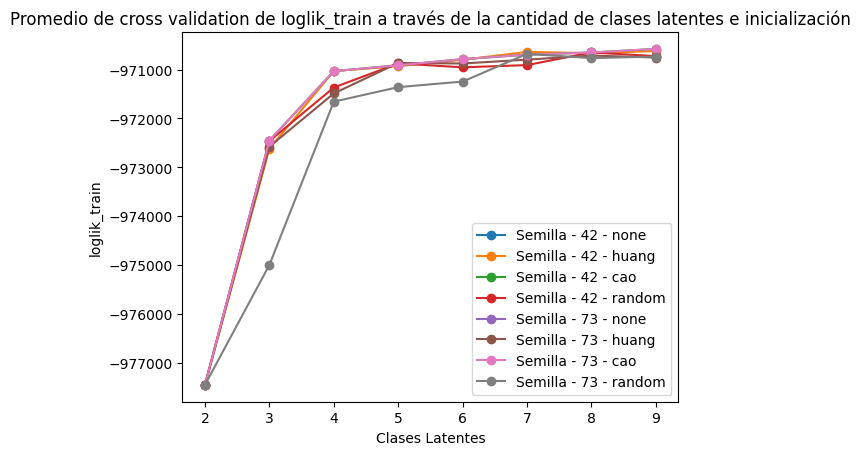

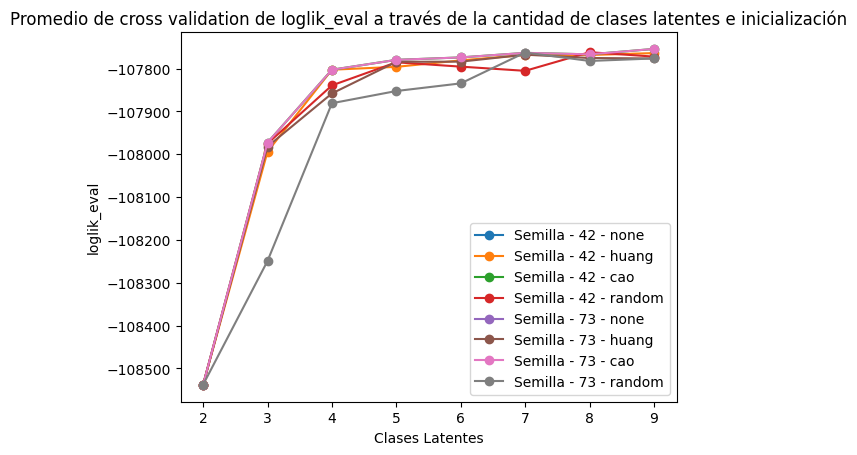

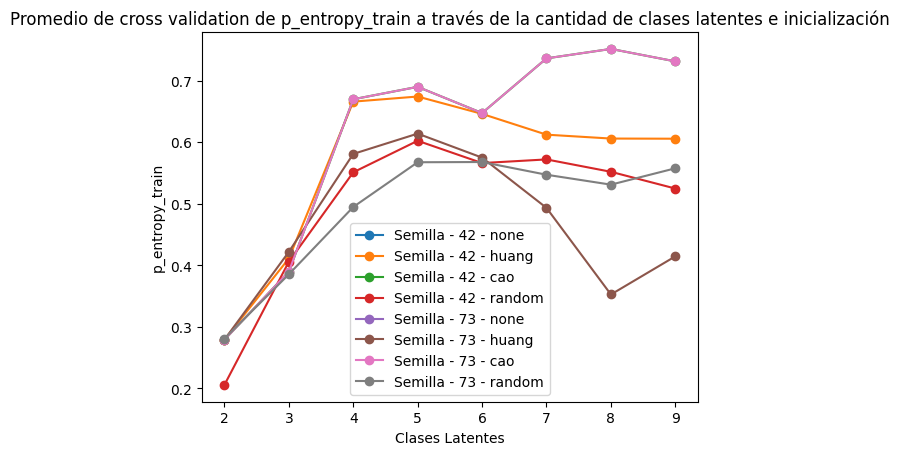

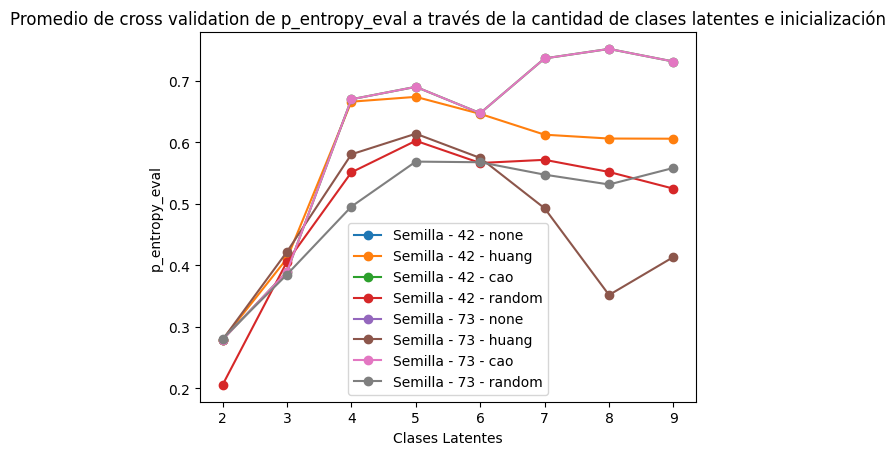

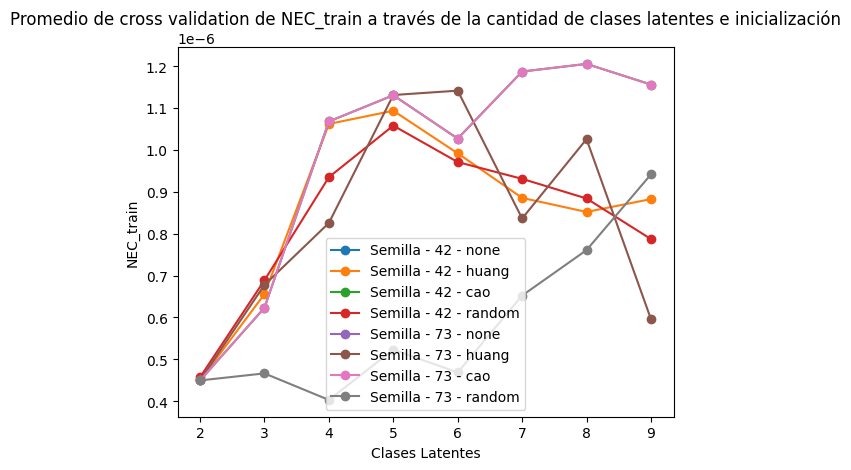

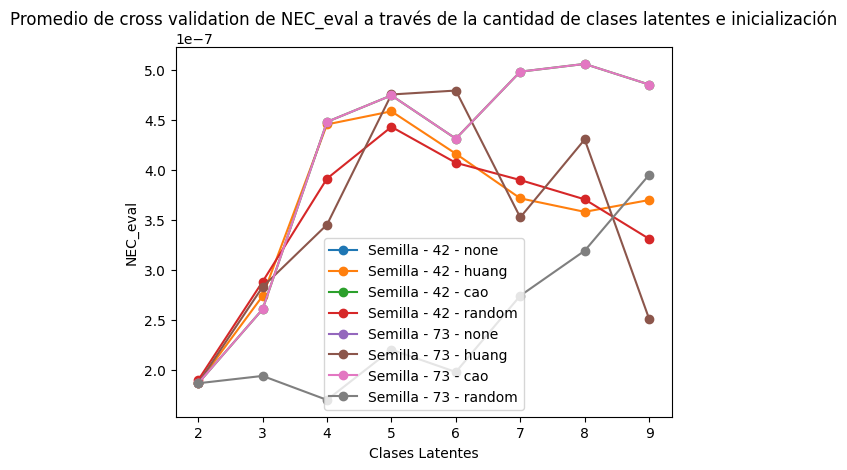

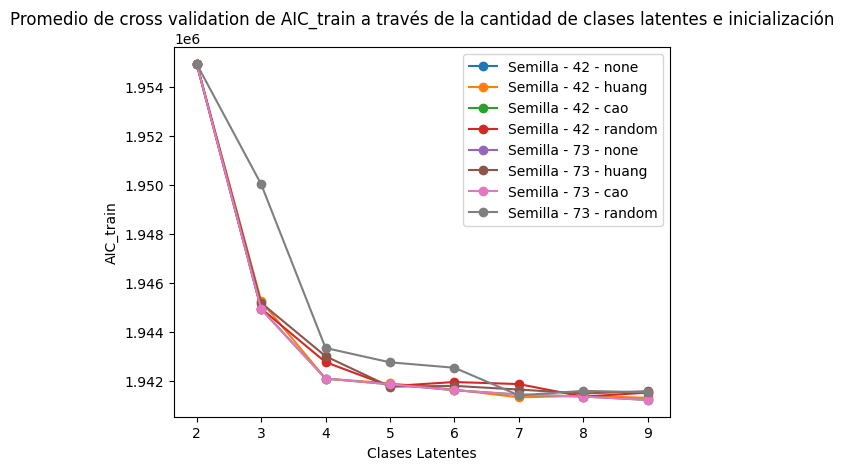

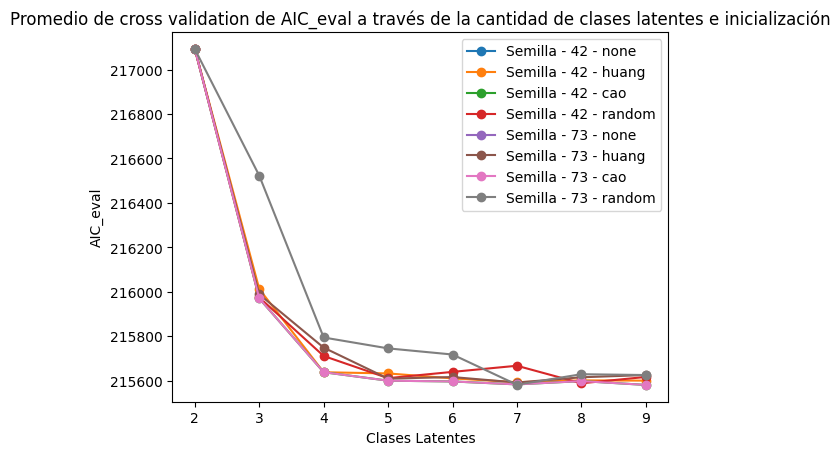

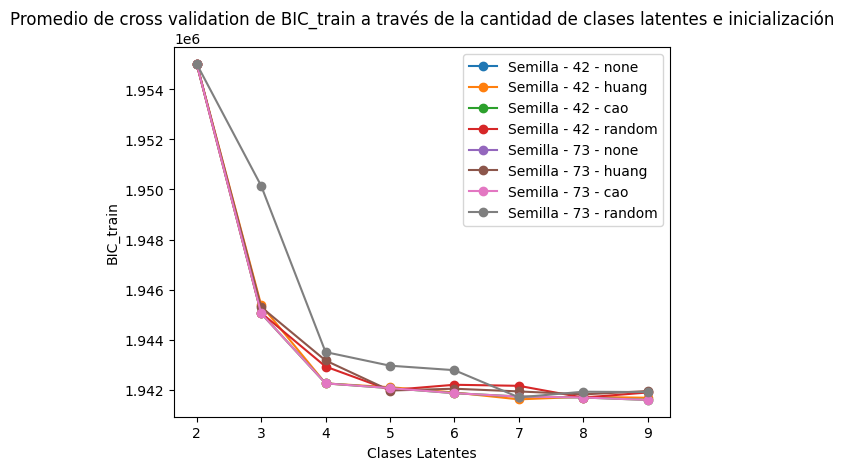

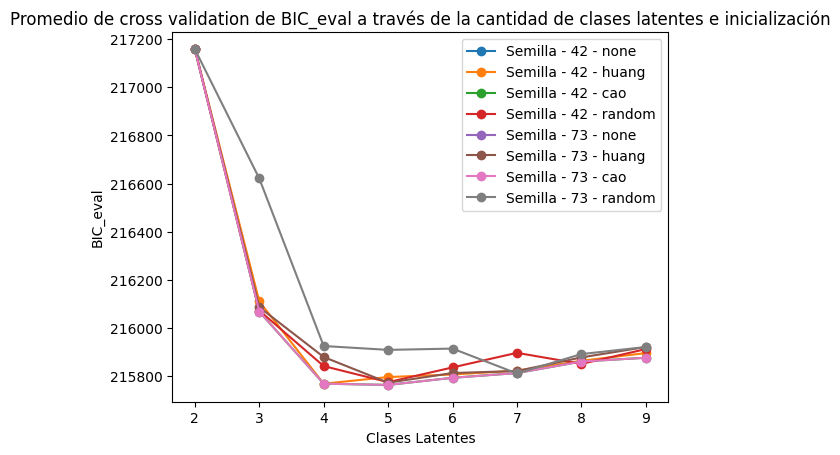

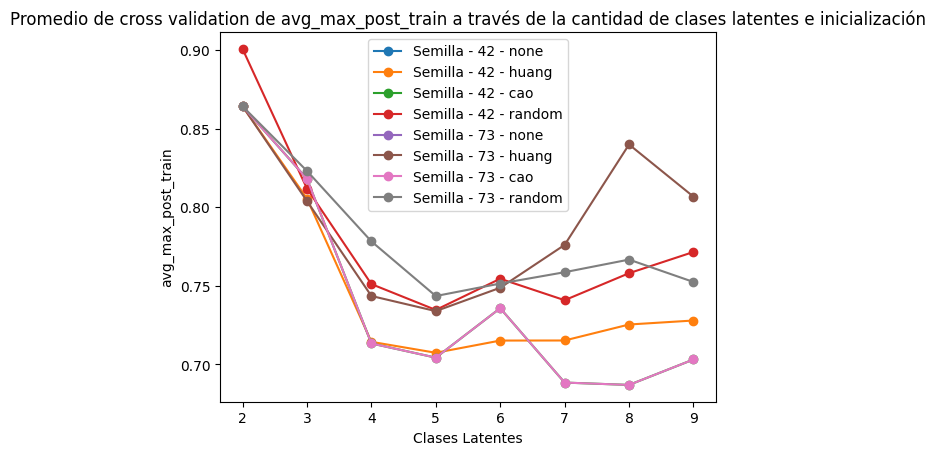

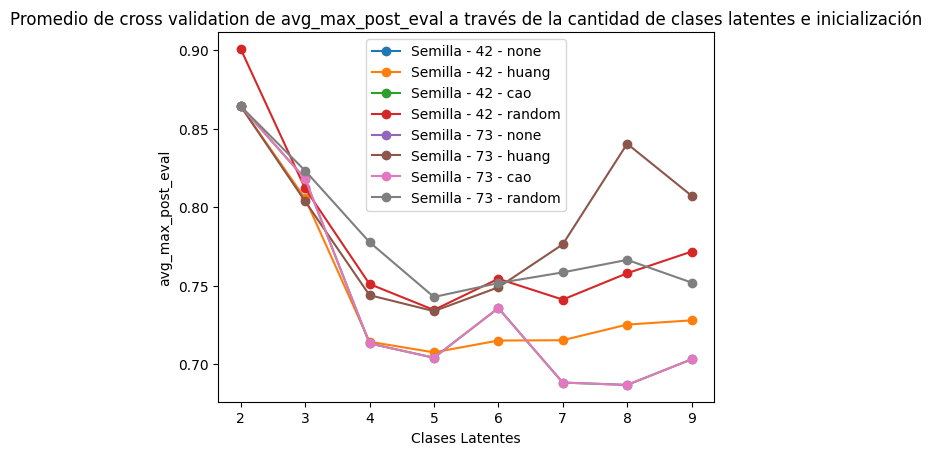

In [22]:

for metric in [
    'loglik_train',
    'loglik_eval',
    'p_entropy_train',
    'p_entropy_eval',
    'NEC_train',
    'NEC_eval',
    'AIC_train',
    'AIC_eval',
    'BIC_train',
    'BIC_eval',
    'avg_max_post_train',
    'avg_max_post_eval'
]:
    graph_metric(
        metric=metric,
        df=df_results_trainning_victims
    )

### Testeo

In [23]:
# ==== FINAL TEST EVALUATION ====
final_results = []

for (seed, num_class, initialization), info in best_models_2.items():
    priors_vals, kmodes_labels_np = None, None
    if initialization != 'no_kmodes':
        # Re-initialize KModes on full training set
        priors_vals, kmodes_labels_np = get_kmodes_init_data(
            X_train_full, n_clusters=num_class, max_iter=1000, device=device
        )
        kmodes_labels_np = torch.tensor(kmodes_labels_np, device=device)

    components_kmodes = []
    for i in range(num_class):
        X_cluster = X_train_full[kmodes_labels_np == i]
        component = Categorical(n_categories=n_cat, pseudocount=1e-6).to(device)
        if len(X_cluster) > 0:
            sample_weight = torch.ones((len(X_cluster), 1), dtype=torch.float32, device=device)
            component.fit(X_cluster, sample_weight=sample_weight)
        components_kmodes.append(component)
    gmm_final = GeneralMixtureModel(distributions=components_kmodes, priors=priors_vals, max_iter=100000, random_state=seed, inertia=1e-6, frozen=False).to(device)
    gmm_final.fit(X_train_full)
    final_row = calculate_metrics(X_train_full, X_test, gmm_full=gmm_final, L_1=L_1, num_class=num_class, seed=seed)
    final_row["init"] = initialization
    print(f"[TEST EVAL] seed={seed} C={num_class} init={initialization} test_NEC={final_row['NEC_eval']:.4f} test_loglik={final_row['loglik_eval']:.1f}")
    final_results.append(final_row)

[TEST EVAL] seed=42 C=2 init=no_kmodes test_NEC=0.0000 test_loglik=-471484.4
[TEST EVAL] seed=42 C=3 init=no_kmodes test_NEC=-0.0000 test_loglik=-479397.8
[TEST EVAL] seed=42 C=4 init=no_kmodes test_NEC=-0.0000 test_loglik=-479397.8
[TEST EVAL] seed=42 C=5 init=no_kmodes test_NEC=-0.0000 test_loglik=-479397.8
[TEST EVAL] seed=42 C=6 init=no_kmodes test_NEC=-0.0000 test_loglik=-479397.8
[TEST EVAL] seed=42 C=7 init=no_kmodes test_NEC=-0.0000 test_loglik=-479397.8
[TEST EVAL] seed=42 C=8 init=no_kmodes test_NEC=-0.0000 test_loglik=-479397.8
[TEST EVAL] seed=42 C=9 init=no_kmodes test_NEC=-0.0000 test_loglik=-479397.8
[TEST EVAL] seed=73 C=2 init=no_kmodes test_NEC=0.0000 test_loglik=-471484.4
[TEST EVAL] seed=73 C=3 init=no_kmodes test_NEC=0.0000 test_loglik=-471400.2
[TEST EVAL] seed=73 C=4 init=no_kmodes test_NEC=0.0000 test_loglik=-470598.1
[TEST EVAL] seed=73 C=5 init=no_kmodes test_NEC=0.0000 test_loglik=-462495.2
[TEST EVAL] seed=73 C=6 init=no_kmodes test_NEC=0.0000 test_loglik=-4

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3822631185.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kmodes_labels_np = torch.tensor(kmodes_labels_np, device=device)


[TEST EVAL] seed=42 C=2 init=huang test_NEC=0.0000 test_loglik=-465532.7
[TEST EVAL] seed=42 C=3 init=huang test_NEC=0.0000 test_loglik=-463631.5
[TEST EVAL] seed=42 C=4 init=huang test_NEC=0.0000 test_loglik=-462781.2
[TEST EVAL] seed=42 C=5 init=huang test_NEC=0.0000 test_loglik=-462611.9
[TEST EVAL] seed=42 C=6 init=huang test_NEC=0.0000 test_loglik=-462547.8
[TEST EVAL] seed=42 C=7 init=huang test_NEC=0.0000 test_loglik=-462445.7
[TEST EVAL] seed=42 C=8 init=huang test_NEC=0.0000 test_loglik=-462382.3
[TEST EVAL] seed=42 C=9 init=huang test_NEC=0.0000 test_loglik=-462537.2
[TEST EVAL] seed=73 C=2 init=huang test_NEC=0.0000 test_loglik=-478016.0
[TEST EVAL] seed=73 C=3 init=huang test_NEC=0.0000 test_loglik=-465483.2
[TEST EVAL] seed=73 C=4 init=huang test_NEC=0.0000 test_loglik=-462481.9
[TEST EVAL] seed=73 C=5 init=huang test_NEC=0.0000 test_loglik=-462752.3
[TEST EVAL] seed=73 C=6 init=huang test_NEC=0.0000 test_loglik=-462337.2
[TEST EVAL] seed=73 C=7 init=huang test_NEC=0.0000 

In [24]:
df_final_victim = pd.DataFrame(final_results)
df_final_victim.to_csv("./results_lca/final_test_results_kmodes_victims.csv", index=False)

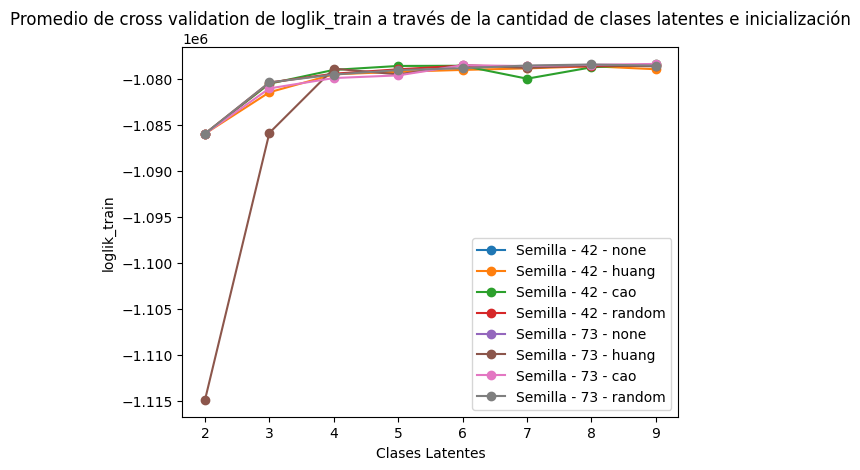

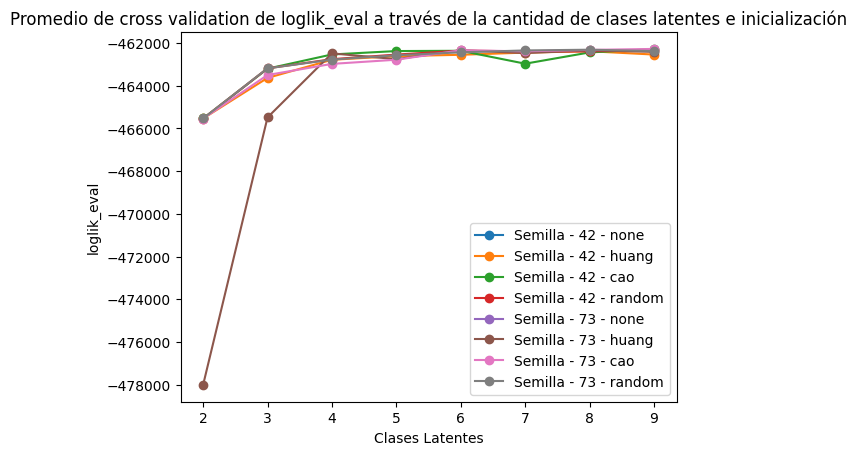

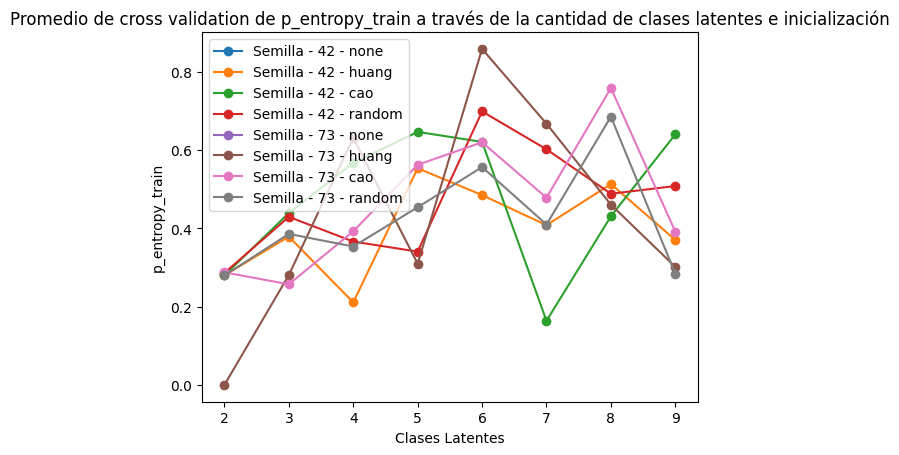

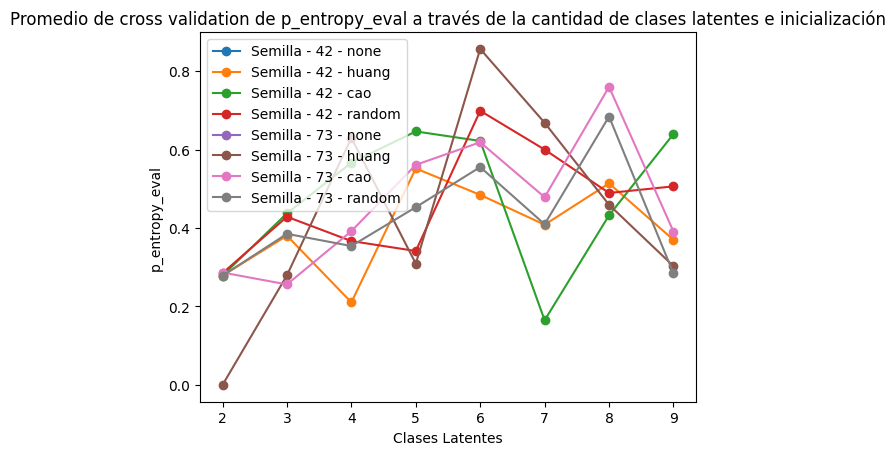

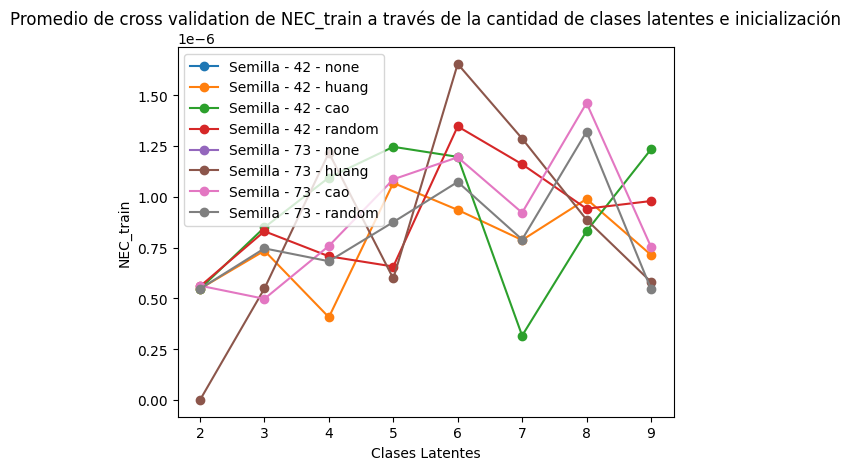

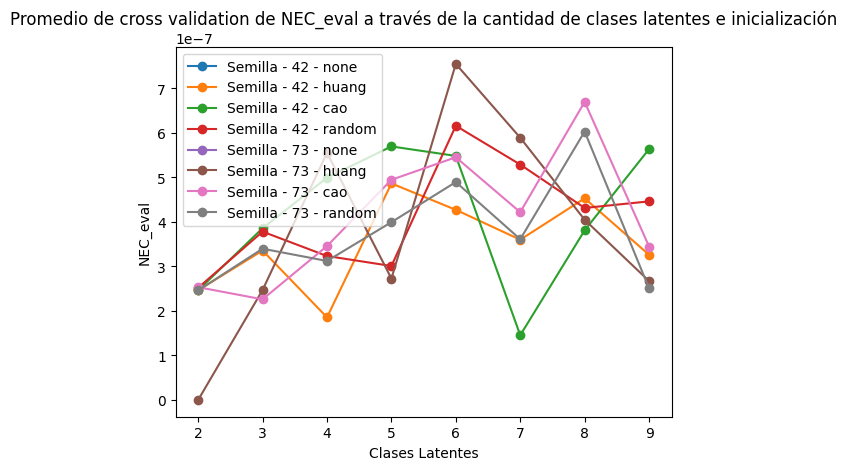

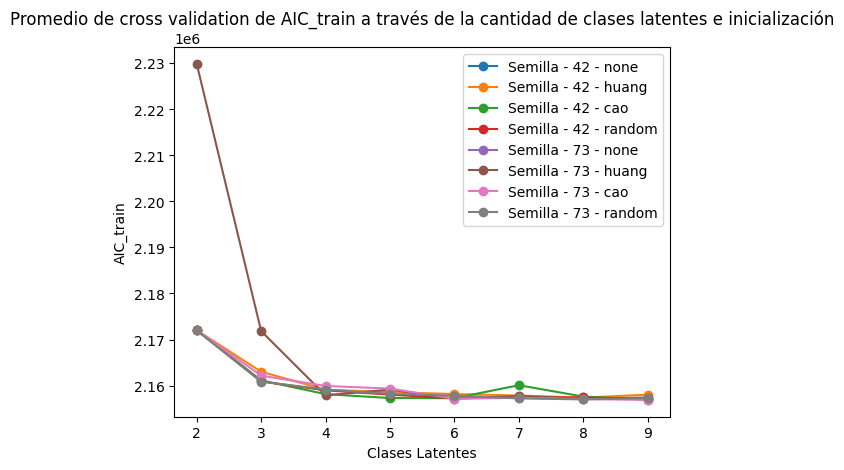

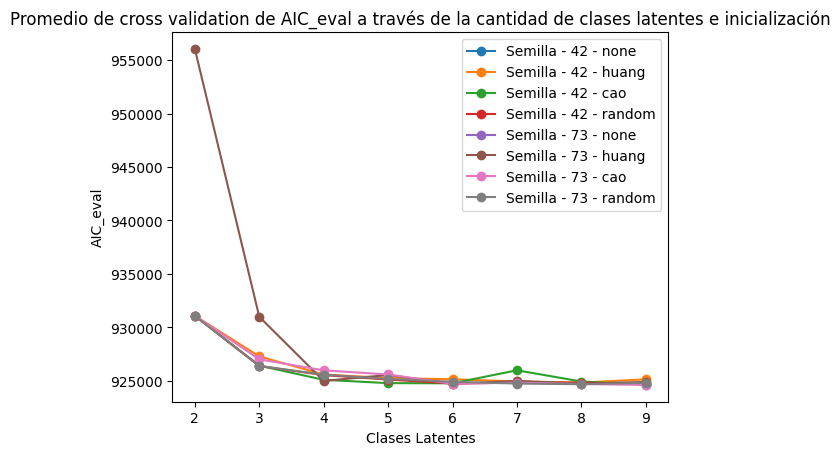

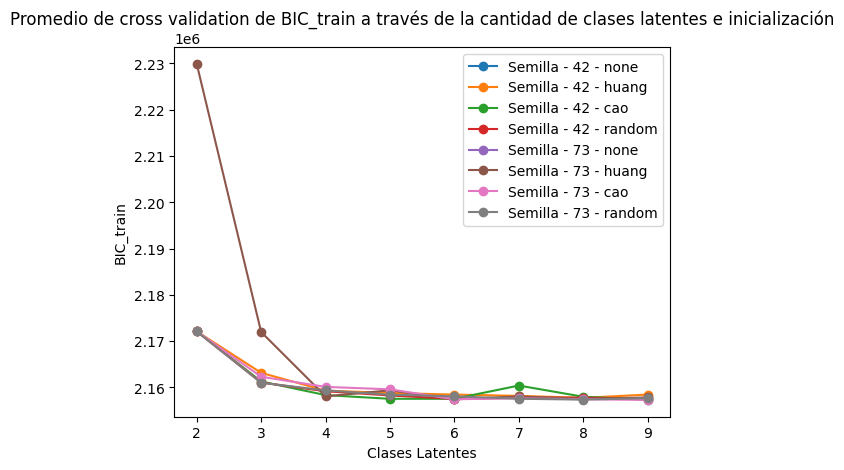

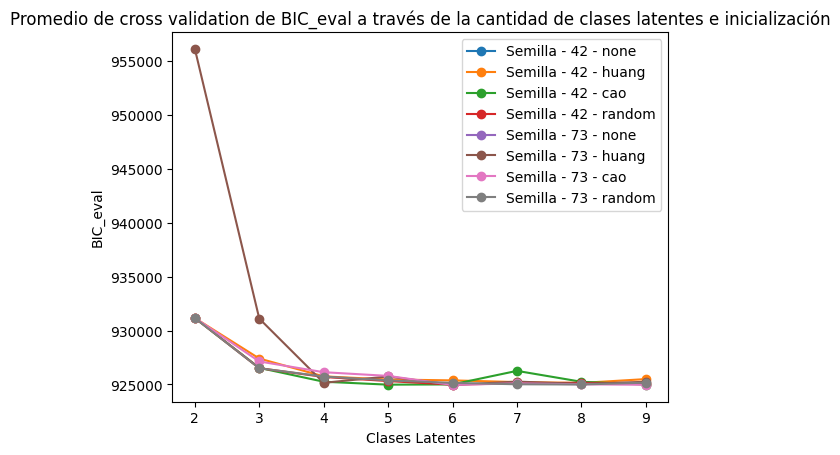

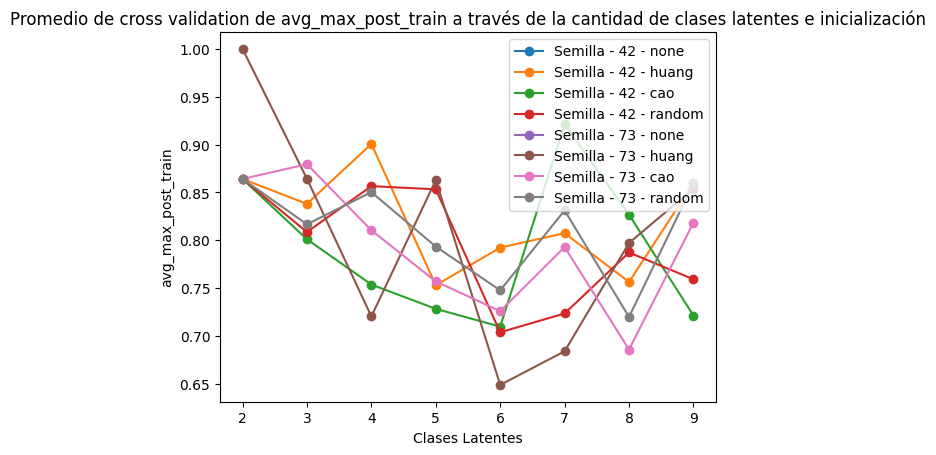

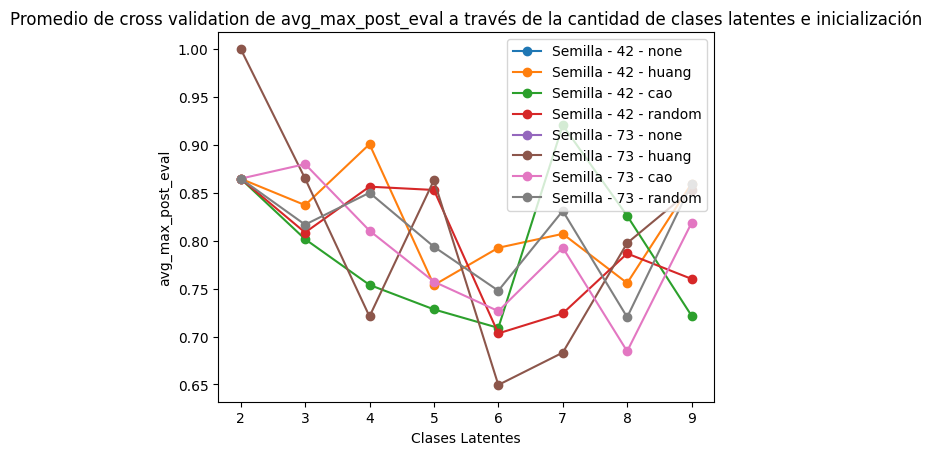

In [25]:
for metric in [
    'loglik_train',
    'loglik_eval',
    'p_entropy_train',
    'p_entropy_eval',
    'NEC_train',
    'NEC_eval',
    'AIC_train',
    'AIC_eval',
    'BIC_train',
    'BIC_eval',
    'avg_max_post_train',
    'avg_max_post_eval'
]:
    graph_metric(
        metric=metric,
        df=df_final_victim
    )

In [26]:
print(df_final_victim.columns)
df_final_victim.head(1)

Index(['num_class', 'seed', 'model', 'loglik_train', 'post_train',
       'labels_train', 'p_entropy_train', 'NEC_train', 'AIC_train',
       'BIC_train', 'avg_max_post_train', 'loglik_eval', 'post_eval',
       'labels_eval', 'p_entropy_eval', 'NEC_eval', 'AIC_eval', 'BIC_eval',
       'avg_max_post_eval', 'class_counts_train', 'class_counts_eval', 'init'],
      dtype='object')


num_class  seed                                              model  \
0          2    42  GeneralMixtureModel(\n  (distributions): Modul...   

                             loglik_train  \
0  tensor(-1099724.3750, device='cuda:0')   

                                          post_train  \
0  [[1.0, 1.0213214e-11], [1.0, 2.4526598e-11], [...   

                                        labels_train  p_entropy_train  \
0  [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...     1.223542e-09   

                             NEC_train                              AIC_train  \
0  tensor(2.4571e-15, device='cuda:0')  tensor(2199464.7500, device='cuda:0')   

                           BIC_train  ...  \
0  tensor(2199549., device='cuda:0')  ...   

                                           post_eval  \
0  [[1.0, 5.899557e-12], [1.1648473e-11, 1.0], [1...   

                                         labels_eval p_entropy_eval  \
0  [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...   1.213687e-09   

                              NEC_eval                              AIC_eval  \
0  tensor(1.0777e-15, device='cuda:0')  tensor(942984.7500, device='cuda:0')   

                               BIC_eval avg_max_post_eval  \
0  tensor(943062.3125, device='cuda:0')               1.0   

      class_counts_train     class_counts_eval       init  
0  {0: 183158, 1: 97286}  {0: 78430, 1: 41761}  no_kmodes  

[1 rows x 22 columns]

In [27]:
# Calificar los modelos
df_scored = normalize_and_score(df_final_victim, scaler='zscore',
                                imbalance_weight=5.0,
                                min_class_threshold=0.1,
                                min_class_penalty=5.0)
df_final_victim['score'] = df_scored['score_norm'].values


In [28]:
top_4_victim = df_final_victim.sort_values(by='score', ascending=False)[:4].reset_index().drop(columns=['index'], axis=1)

In [29]:
top_4_victim

num_class  seed                                              model  \
0          4    42  GeneralMixtureModel(\n  (distributions): Modul...   
1          3    73  GeneralMixtureModel(\n  (distributions): Modul...   
2          4    73  GeneralMixtureModel(\n  (distributions): Modul...   
3          4    42  GeneralMixtureModel(\n  (distributions): Modul...   

                             loglik_train  \
0  tensor(-1079547.7500, device='cuda:0')   
1      tensor(-1081073., device='cuda:0')   
2  tensor(-1079564.5000, device='cuda:0')   
3  tensor(-1079478.5000, device='cuda:0')   

                                          post_train  \
0  [[6.7443434e-05, 0.9999325, 3.899278e-09, 7.54...   
1  [[0.9999862, 1.3842302e-05, 1.4562397e-09], [0...   
2  [[0.10019842, 0.0033783442, 0.8964233, 4.16396...   
3  [[0.06623217, 0.0022678166, 4.2580253e-10, 0.9...   

                                        labels_train  p_entropy_train  \
0  [1, 1, 2, 2, 1, 3, 1, 0, 2, 2, 2, 2, 3, 1, 0, ...         0.210888   
1  [0, 0, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 2, ...         0.257100   
2  [2, 2, 0, 0, 2, 1, 2, 3, 0, 0, 0, 0, 1, 2, 1, ...         0.353738   
3  [3, 3, 0, 0, 3, 1, 3, 2, 0, 0, 0, 0, 1, 3, 1, ...         0.366391   

                             NEC_train                              AIC_train  \
0  tensor(4.0702e-07, device='cuda:0')  tensor(2159127.5000, device='cuda:0')   
1  tensor(4.9767e-07, device='cuda:0')      tensor(2162170., device='cuda:0')   
2  tensor(6.8274e-07, device='cuda:0')      tensor(2159161., device='cuda:0')   
3  tensor(7.0704e-07, device='cuda:0')      tensor(2158989., device='cuda:0')   

                               BIC_train  ...  \
0  tensor(2159296.2500, device='cuda:0')  ...   
1  tensor(2162296.5000, device='cuda:0')  ...   
2  tensor(2159329.7500, device='cuda:0')  ...   
3  tensor(2159157.7500, device='cuda:0')  ...   

                                         labels_eval p_entropy_eval  \
0  [2, 3, 2, 0, 2, 2, 0, 1, 0, 0, 2, 2, 1, 2, 2, ...       0.210533   
1  [0, 1, 2, 1, 2, 2, 1, 0, 2, 1, 0, 2, 0, 2, 0, ...       0.256244   
2  [0, 1, 0, 1, 0, 0, 1, 2, 3, 1, 0, 0, 2, 0, 0, ...       0.354200   
3  [0, 1, 0, 2, 0, 0, 2, 3, 2, 2, 0, 0, 3, 0, 0, ...       0.366842   

                              NEC_eval                              AIC_eval  \
0  tensor(1.8551e-07, device='cuda:0')  tensor(925594.5000, device='cuda:0')   
1  tensor(2.2593e-07, device='cuda:0')  tensor(927015.3750, device='cuda:0')   
2  tensor(3.1210e-07, device='cuda:0')  tensor(925580.5625, device='cuda:0')   
3  tensor(3.2323e-07, device='cuda:0')  tensor(925539.2500, device='cuda:0')   

                               BIC_eval avg_max_post_eval  \
0  tensor(925749.6250, device='cuda:0')          0.900652   
1  tensor(927131.7500, device='cuda:0')          0.879861   
2  tensor(925735.6875, device='cuda:0')          0.849994   
3  tensor(925694.3750, device='cuda:0')          0.856317   

                          class_counts_train  \
0  {0: 68064, 1: 59313, 2: 113810, 3: 39257}   
1            {0: 95143, 1: 65474, 2: 119827}   
2  {0: 113810, 1: 67443, 2: 58690, 3: 40501}   
3  {0: 115073, 1: 56144, 2: 50537, 3: 58690}   

                          class_counts_eval    init     score  
0  {0: 29302, 1: 25715, 2: 48504, 3: 16670}   huang  4.093073  
1            {0: 41012, 1: 27984, 2: 51195}     cao  2.902072  
2  {0: 48504, 1: 28931, 2: 25456, 3: 17300}  random  1.709813  
3  {0: 49044, 1: 23983, 2: 21708, 3: 25456}  random  1.625476  

[4 rows x 23 columns]

## Interpretando los resultados

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3555764215.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


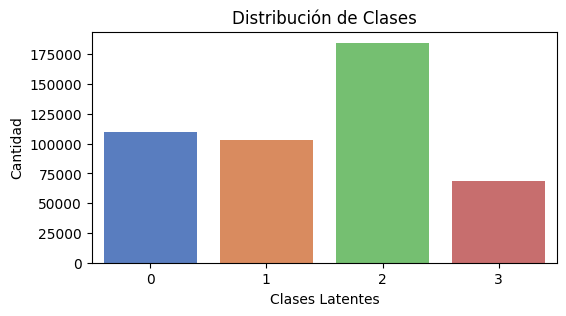

prediction_victim  VIC_EST_CIV  VIC_REL_AGR  AGR_EST_CIV  \
0                  0  casados(as)  esposos(as)  casados(as)   
1                  1  casados(as)  conviviente  casados(as)   
2                  2  casados(as)  esposos(as)  casados(as)   
3                  3  casados(as)  esposos(as)  casados(as)   

       AGR_ESCOLARIDAD      VIC_ESCOLARIDAD AGR_TRABAJA VIC_TRABAJA  
0       tercero basico       tercero basico          si          no  
1              ninguno              ninguno          si          no  
2       sexto primaria       sexto primaria          si          no  
3  sexto diversificado  sexto diversificado          si          si

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3555764215.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


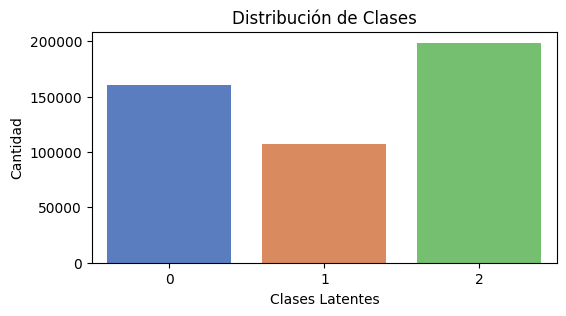

prediction_victim  VIC_EST_CIV  VIC_REL_AGR  AGR_EST_CIV  \
0                  0  casados(as)  esposos(as)  casados(as)   
1                  1  casados(as)  esposos(as)  casados(as)   
2                  2  casados(as)  conviviente  casados(as)   

       AGR_ESCOLARIDAD      VIC_ESCOLARIDAD AGR_TRABAJA VIC_TRABAJA  
0              ninguno              ninguno          si          no  
1  sexto diversificado  sexto diversificado          si          si  
2       sexto primaria       sexto primaria          si          no

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3555764215.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


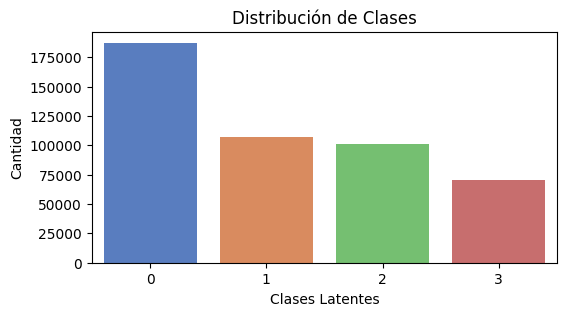

prediction_victim  VIC_EST_CIV  VIC_REL_AGR  AGR_EST_CIV  \
0                  0  casados(as)  esposos(as)  casados(as)   
1                  1  casados(as)  esposos(as)  casados(as)   
2                  2  casados(as)  conviviente  casados(as)   
3                  3  casados(as)  esposos(as)  casados(as)   

       AGR_ESCOLARIDAD      VIC_ESCOLARIDAD AGR_TRABAJA VIC_TRABAJA  
0       sexto primaria       sexto primaria          si          no  
1  sexto diversificado  sexto diversificado          si          si  
2              ninguno              ninguno          si          no  
3       tercero basico       tercero basico          si          no

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3555764215.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


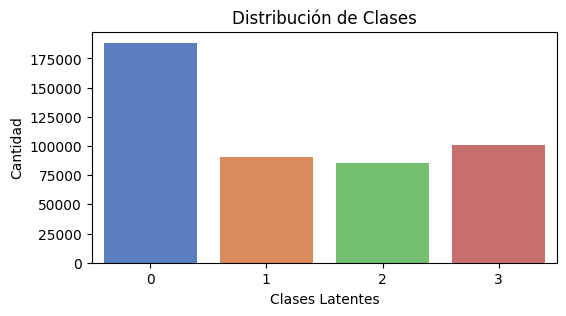

prediction_victim  VIC_EST_CIV  VIC_REL_AGR  AGR_EST_CIV  \
0                  0  casados(as)  esposos(as)  casados(as)   
1                  1  casados(as)  esposos(as)  casados(as)   
2                  2  casados(as)  esposos(as)  casados(as)   
3                  3  casados(as)  conviviente  casados(as)   

       AGR_ESCOLARIDAD      VIC_ESCOLARIDAD AGR_TRABAJA VIC_TRABAJA  
0       sexto primaria       sexto primaria          si          no  
1  sexto diversificado  sexto diversificado          si          si  
2       tercero basico       tercero basico          si          no  
3              ninguno              ninguno          si          no

In [151]:
for index in range(top_4_victim.shape[0]):
    top = top_4_victim.iloc[index]
    model_p = top['model'] 

    # sanity checks
    assert X.dim() == 2, "input must be 2D (n_samples, n_features)"
    assert (X >= 0).all().item(), "categorical codes must be non-negative"
    

    df['prediction_victim'] = model_p.predict(torch.tensor(df[ENCODED_VARS_VICTIM].to_numpy(), dtype=torch.int32)).cpu()
    df_complete_victim['prediction_victim'] = model_p.predict(torch.tensor(df_complete_victim[ENCODED_VARS_VICTIM].to_numpy(), dtype=torch.int32)).cpu()
    df['prediction_victim_probs'] = np.nan
    df['prediction_victim_probs'] = model_p.predict_proba(torch.tensor(df[ENCODED_VARS_VICTIM].to_numpy(), dtype=torch.int32)).cpu()
    df_complete_victim['prediction_victim_probs'] = np.nan
    df_complete_victim['prediction_victim_probs'] = model_p.predict_proba(torch.tensor(df_complete_victim[ENCODED_VARS_VICTIM].to_numpy(), dtype=torch.int32)).cpu()
    # -- class sizes
    unique, counts = np.unique(df['prediction_victim'], return_counts=True)
    plt.figure(figsize=(6,3))
    sns.barplot(x=unique, y=counts, palette="muted")
    plt.title(f"Distribución de Clases")
    plt.xlabel("Clases Latentes")
    plt.ylabel("Cantidad")
    plt.show()
    
    # Count most frequent combination of VARIABLES per prediction
    group_profiles = (
        df_complete_victim.groupby("prediction_victim")[VARIABLES]
        .agg(lambda x: x.value_counts().idxmax())   # most frequent
        .reset_index()
    )
    display(group_profiles)

In [31]:
model = top_4_victim.iloc[0]['model']

In [32]:
def get_posteriors_from_model(model, df, encoded_vars, device=None):
    """
    Obtiene posteriors (n_samples, n_classes) desde model.predict_proba.
    Acepta que model.predict_proba acepte numpy o torch.Tensor.
    - model: objeto pomegranate (o similar) con método predict_proba.
    - df: DataFrame original con columnas encoded_vars (enteros 0..C-1).
    - encoded_vars: lista de nombres de columnas en df usadas por el modelo.
    - device: torch device string si quieres usar tensores (ej. 'cuda:0') o None.
    Devuelve: ndarray (n, k) de posteriors en CPU (float64).
    """
    X = df[encoded_vars].to_numpy()
    # Intentar pasar tensores torch si el método acepta torch
    try:
        if device is not None:
            xt = torch.tensor(X, dtype=torch.long, device=device)
            post = model.predict_proba(xt)
            # Si devuelve tensor, convertir a cpu numpy
            if isinstance(post, torch.Tensor):
                return post.detach().cpu().numpy()
        # Si lo anterior falla, intentar con numpy
    except Exception:
        pass

    # Intentar con numpy (la opción más compatible)
    post = model.predict_proba(X)
    # Si devuelve tensor o lista, convertir a numpy
    if isinstance(post, torch.Tensor):
        return post.detach().cpu().numpy()
    return np.asarray(post)

def class_probability_matrix_from_posteriors(df, posteriors, vars_cat, category_maps=None):
    """
    Calcula P(X = c | class = j) para cada var en vars_cat usando posteriors (n,k).
    - df: DataFrame con las variables categóricas codificadas (valores reales o categorías).
    - posteriors: ndarray shape (n, k)
    - vars_cat: lista de variable names a procesar
    - category_maps: optional dict var -> list_of_categories (order to display). 
      Si no se da, usa df[var].astype('category').cat.categories
    Devuelve:
      - probs: dict var -> DataFrame index=categories, columns=Class_1..Class_k (prob.)
      - prevalences: Series con prevalencia esperada por clase
    """
    n, k = posteriors.shape
    prevalences = posteriors.sum(axis=0) / n
    class_cols = [f'Class_{j+1}' for j in range(k)]
    probs = {}

    for var in vars_cat:
        series = df[var].astype('category')
        if category_maps and var in category_maps:
            cats = list(category_maps[var])
            # asegurarse de que las categorías existan en la serie
            series = series.cat.set_categories(cats)
        else:
            cats = list(series.cat.categories)

        mat = np.zeros((len(cats), k), dtype=float)
        denom = posteriors.sum(axis=0)  # shape (k,)

        # calcular para cada categoría
        # vectorizado: construir matriz indicador (n, m_cats)
        indicators = np.vstack([(series == c).astype(float).values for c in cats])  # shape (m, n)
        # numerador por cat y clase: indicators @ posteriors -> (m, k)
        numer = indicators @ posteriors  # (m, k) because indicators (m,n) x (n,k) -> (m,k)
        # normalizar
        with np.errstate(divide='ignore', invalid='ignore'):
            mat = np.where(denom > 0, numer / denom[None, :], np.nan)

        probs[var] = pd.DataFrame(mat, index=cats, columns=class_cols)

    prevalences = pd.Series(prevalences, index=class_cols)
    return probs, prevalences


In [34]:
import joblib

for index in range(top_4_victim.shape[0]):
    top = top_4_victim.iloc[index]
    model_p = top['model'] 
    joblib.dump(model_p, f"./models/gmm_model_no_kmodes_victimas_top{index}.pkl")

In [166]:
import pickle as pkl

model_victim = pkl.load(open("./models/gmm_model_no_kmodes_victimas_top0.pkl", "rb"))

posteriors = get_posteriors_from_model(model_victim, df_complete_victim, ENCODED_VARS_VICTIM, device=None)  # o device='cuda:0' si tu model acepta

probs_dict, preval = class_probability_matrix_from_posteriors(df_complete_victim, posteriors, ENCODED_VARS_VICTIM)

print(preval)
for col in ENCODED_VARS_VICTIM:
    print(f"Probabilidades condicionales para {col}:")
    print(probs_dict[col].set_index(label_encoders[col.split('_ENC')[0]].inverse_transform(probs_dict[col].index)).round(3))

for var, table in probs_dict.items():
    table.index = label_encoders[var.split('_ENC')[0]].inverse_transform(table.index)
    latex = table.to_latex(float_format="%.3f")    
    with open(f"../documento/plantilla/results_lca/prob_matrix_victimas_{var}.tex", "w", encoding="utf8") as f:
        f.write(latex)


Class_1    0.247978
Class_2    0.212502
Class_3    0.369175
Class_4    0.170547
dtype: float64
Probabilidades condicionales para VIC_ES_INDIGENA_ENC:
    Class_1  Class_2  Class_3  Class_4
no    0.789    0.353    0.616    0.876
si    0.211    0.647    0.383    0.124
Probabilidades condicionales para VIC_NIV_ESCOLARIDAD_ENC:
               Class_1  Class_2  Class_3  Class_4
basicos          0.495    0.032    0.000    0.116
diversificado    0.448    0.000    0.000    0.508
ninguno          0.000    0.968    0.000    0.039
primaria         0.007    0.000    0.999    0.203
universidad      0.050    0.000    0.000    0.135
Probabilidades condicionales para VIC_TRABAJA_ENC:
    Class_1  Class_2  Class_3  Class_4
no    0.763    0.845    0.826      0.0
si    0.237    0.155    0.173      1.0
Probabilidades condicionales para CANTIDAD_HIJOS_ENC:
              Class_1  Class_2  Class_3  Class_4
hijo unico      0.305    0.140    0.198    0.240
hijos medios    0.386    0.315    0.382    0.437
mucho

In [36]:
df['prediction_victim'] = model_victim.predict(torch.tensor(df[ENCODED_VARS_VICTIM].to_numpy(), dtype=torch.int32, device=device)).cpu()

#### Generar incertidumbres con bootstrap

In [37]:
# Bootstrap robusto para pomegranate GeneralMixtureModel
import numpy as np
import torch
from copy import deepcopy
from tqdm import trange
from scipy.special import logsumexp

# ---------- Ajustes que puedes cambiar ----------
B = 1000
method = 'parametric'   # 'parametric' o 'nonparametric'
rng = np.random.default_rng(12345)
n, d = X_train_full.shape
S = len(model.distributions)
max_iter_replica = 2000
tol_replica = 1e-6
n_retries = 3

# ---------- Helpers de conversión y validación ----------
def to_numpy_safe(x):
    """Convierte torch.Tensor (CPU/GPU), numpy array, list/tuple a numpy.ndarray (float)."""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        x = np.asarray(x)
    return np.asarray(x)

def to_numpy_1d(x, dtype=float):
    arr = to_numpy_safe(x)
    arr = arr.reshape(-1)
    return arr.astype(dtype)

def ensure_2d_numeric(x):
    arr = to_numpy_safe(x).astype(float)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    if arr.ndim != 2:
        raise ValueError(f"Se esperaba arreglo 2D; ndim={arr.ndim}")
    return arr

# ---------- Extraer MLE inicial (copias) de forma segura ----------
# forzar modelo a CPU para depuración si es posible
try:
    model = model.to('cpu')
except Exception:
    pass

# convertir X a numpy para réplicas no paramétricas
X_np = X_train_full.detach().cpu().numpy()

# priors (pi_hat) y copias de componentes
raw_priors = getattr(model, 'priors', None)
if raw_priors is None:
    pi_hat = np.full(S, 1.0 / S)
else:
    pi_hat = to_numpy_1d(raw_priors)

components_hat = [deepcopy(c) for c in model.distributions]

# ---------- Almacenamiento ----------
EN_boot = np.full(B, np.nan, dtype=float)
E_boot  = np.full(B, np.nan, dtype=float)
e_boot  = np.full((B, n), np.nan, dtype=float) if method == 'parametric' else None
success = np.zeros(B, dtype=bool)
error_msgs = [None] * B

# ---------- Funciones para crear y ajustar modelos ----------
def make_model_from_mle(pi_init, comps_init, max_iter=2000, tol=1e-6, random_state=None):
    comps_copy = [deepcopy(c) for c in comps_init]
    # pasar priors como numpy array
    return GeneralMixtureModel(distributions=comps_copy, priors=np.array(pi_init), max_iter=max_iter, tol=tol, random_state=random_state)

def get_posteriors_from_model(m, X):
    """
    Devuelve matriz (n, S) de posterioris p(component | x).
    Intenta usar predict_proba; si no existe usa _emission_matrix y normaliza.
    Acepta X como numpy array (n,d).
    """
    if hasattr(m, 'predict_proba'):
        a = m.predict_proba(X)
        a = to_numpy_safe(a).astype(float)
        if a.ndim == 1:
            a = a.reshape(1, -1)
        return a
    if hasattr(m, '_emission_matrix'):
        logp = m._emission_matrix(X)
        logp = to_numpy_safe(logp).astype(float)
        # logp: (n, S) log p(x | component) + log prior? (API interna), normalizar de forma estable
        lse = logsumexp(logp, axis=1, keepdims=True)
        a = np.exp(logp - lse)
        return a
    raise RuntimeError("No se puede extraer posterioris: adapta según tu versión de pomegranate.")

def safe_fit_with_retries(factory, Xb, n_retries=3, increase_smooth=False):
    """
    Intenta ajustar el modelo hasta n_retries. Si increase_smooth=True
    modifica levemente componentes para añadir pseudocounts en los intentos.
    """
    last_err = None
    for attempt in range(n_retries):
        m = factory()
        try:
            # forzar cpu en el modelo si es posible
            try:
                m = m.to('cpu')
            except Exception:
                pass
            m.fit(Xb)
            # comprobar log-probabilidad si disponible
            if hasattr(m, 'log_probability'):
                lp = m.log_probability(Xb)
                lp_np = to_numpy_safe(lp)
                if np.any(np.isnan(lp_np)) or not np.isfinite(lp_np).all():
                    raise RuntimeError("log_probability contiene NaN/Inf")
            return m, None
        except Exception as e:
            last_err = e
            # si pedimos suavizado para el próximo intento, aplicamos a una copia de componentes aunque sea heurístico
            if increase_smooth:
                # heurística: si componente tiene atributo 'pseudocount' lo aumentamos; si no, ignoramos
                for comp in factory().__dict__.get('distributions', []):
                    if hasattr(comp, 'pseudocount'):
                        comp.pseudocount = max(getattr(comp, 'pseudocount', 0), 1e-3)
            # continuar al siguiente intento
    return None, last_err

# factory que inicializa desde la MLE guardada
def factory_from_mle(pi=pi_hat, comps=components_hat, max_iter=max_iter_replica, tol=tol_replica):
    return make_model_from_mle(pi, comps, max_iter=max_iter_replica, tol=tol_replica, random_state=None)

# ---------- Loop bootstrap robusto ----------
for b in trange(B):
    try:
        # 1) generar réplica
        if method == 'parametric':
            sampled = model.sample(n)  # puede devolver tensor
            if isinstance(sampled, torch.Tensor):
                Xb = sampled.detach().cpu().numpy()
            else:
                Xb = np.asarray(sampled)
        else:
            idx = rng.integers(0, n, size=n)
            Xb = X_np[idx]

        # asegurar 2D numpy float/int según seas categórico o no
        Xb = np.asarray(Xb)

        # 2) ajustar con reintentos si falla (prueba smoothing)
        model_b, err = safe_fit_with_retries(lambda: factory_from_mle(), Xb, n_retries=n_retries, increase_smooth=True)
        if model_b is None:
            success[b] = False
            error_msgs[b] = str(err)
            continue

        # 3) obtener posterioris sobre Xb
        a_b = get_posteriors_from_model(model_b, Xb)
        # validar a_b
        if not (a_b.ndim == 2 and a_b.shape[1] == S):
            raise RuntimeError(f"Posterioris con forma inesperada: {a_b.shape}")

        # 4) calcular métricas
        hi_b = -np.sum(a_b * np.log(a_b + 1e-16), axis=1)
        EN_b = float(hi_b.sum())
        E_b  = float(1.0 - EN_b / (n * np.log(S)))
        EN_boot[b] = EN_b
        E_boot[b]  = E_b
        if method == 'parametric':
            e_b = 1.0 - np.max(a_b, axis=1)
            e_boot[b, :] = e_b
        success[b] = True

    except Exception as ex:
        success[b] = False
        error_msgs[b] = str(ex)

# ---------- Resumen y protección contra NaNs ----------
def summarize_scalar_boot_safe(arr_boot, orig, alpha=0.05):
    valid = arr_boot[~np.isnan(arr_boot)]
    n_valid = valid.size
    if n_valid == 0:
        return {'mean': np.nan, 'bias': np.nan, 'se': np.nan, 'ci': (np.nan, np.nan), 'n_valid': 0}
    mean_b = float(np.mean(valid))
    bias = float(mean_b - orig)
    se = float(np.std(valid, ddof=1)) if n_valid > 1 else np.nan
    lower, upper = np.percentile(valid, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': mean_b, 'bias': bias, 'se': se, 'ci': (float(lower), float(upper)), 'n_valid': int(n_valid)}

def summarize_vector_boot_safe(arr_boot_2d, orig_vec, alpha=0.05):
    B_loc, n_loc = arr_boot_2d.shape
    mean_b = np.nanmean(arr_boot_2d, axis=0)
    bias = mean_b - orig_vec
    se = np.nanstd(arr_boot_2d, axis=0, ddof=1)
    # manejar columnas con todo NaN
    lower = np.nanpercentile(arr_boot_2d, 100*alpha/2, axis=0)
    upper = np.nanpercentile(arr_boot_2d, 100*(1-alpha/2), axis=0)
    allnan = np.all(np.isnan(arr_boot_2d), axis=0)
    lower[allnan] = np.nan
    upper[allnan] = np.nan
    return {'mean': mean_b, 'bias': bias, 'se': se, 'ci': (lower, upper), 'n_valid_per_obs': np.sum(~np.isnan(arr_boot_2d), axis=0)}

# calcular estadísticas originales (a_hat, e_hat, EN_hat, E_hat)
a_hat = get_posteriors_from_model(model, X_np)
a_hat = ensure_2d_numeric(a_hat)
max_post = np.max(a_hat, axis=1)
e_hat = 1.0 - max_post
hi = -np.sum(a_hat * np.log(a_hat + 1e-16), axis=1)
EN_hat = float(hi.sum())
E_hat = float(1.0 - EN_hat / (n * np.log(S)))

summary_EN = summarize_scalar_boot_safe(EN_boot, EN_hat)
summary_E  = summarize_scalar_boot_safe(E_boot, E_hat)
summary_e = None
if method == 'parametric':
    summary_e = summarize_vector_boot_safe(e_boot, e_hat)

# reporte rápido
n_valid = int(success.sum())
print(f"Bootstrap finished: {n_valid}/{B} valid replicas; {B-n_valid} failed.")
if n_valid < max(10, B // 10):
    print("Advertencia: pocas réplicas válidas. Revisa error_msgs para las primeras fallidas:")
    failed_idx = np.where(~success)[0]
    print([error_msgs[i] for i in failed_idx[:10]])


100%|██████████| 1000/1000 [51:13<00:00,  3.07s/it] 


Bootstrap finished: 1000/1000 valid replicas; 0 failed.


In [38]:
summary_EN

{'mean': 58748.885114433695,
 'bias': -393.4659526201722,
 'se': 405.6425899811496,
 'ci': (57891.83005785317, 59570.346095883055),
 'n_valid': 1000}

In [39]:
summary_e

{'mean': array([0.09941513, 0.10148917, 0.09940783, ..., 0.10547841, 0.09294107,
        0.09982641]),
 'bias': array([0.09934766, 0.06922613, 0.09118489, ..., 0.10547841, 0.09294107,
        0.07768227]),
 'se': array([0.1523226 , 0.15688927, 0.15231053, ..., 0.15568555, 0.14579391,
        0.15410849]),
 'ci': (array([8.79301805e-09, 8.61385964e-09, 8.58003576e-09, ...,
         8.61048557e-09, 8.67893674e-09, 8.66602684e-09]),
  array([0.4741235 , 0.47605926, 0.47531126, ..., 0.4767355 , 0.47136509,
         0.47449125])),
 'n_valid_per_obs': array([1000, 1000, 1000, ..., 1000, 1000, 1000])}

In [ ]:
summary_E

{'mean': 0.9910328464166158,
 'bias': 1.0347152047840424e-05,
 'se': 0.0001658322543706168,
 'ci': (0.99070443986845, 0.9913464835614839),
 'n_valid': 1000}

In [ ]:
EN_boot

array([nan, nan, nan, ..., nan, nan, nan])

## Generar el perfil para la situación

In [40]:
print(df['AGR_ALFAB'].value_counts())
print(df['AGR_ES_INDIGENA'].value_counts())
print(df['AGR_NIV_ESCOLARIDAD'].value_counts())
print(df['AGR_TRABAJA'].value_counts())
print(df['AGR_SEXO'].value_counts())
print(df['OTROS_AGRESORES'].value_counts()) 
print(df['VIOLENCIA_FISICA'].value_counts()) 
print(df['VIOLENCIA_PSICOLOGICA'].value_counts()) 
print(df['VIOLENCIA_SEXUAL'].value_counts()) 
print(df['VIOLENCIA_PATRIMONIAL'].value_counts()) 
print(df['VIC_OTRAS_VICTIMAS'].value_counts()) 

AGR_ALFAB
alfabeta      396147
analfabeta     59470
ignorado       10405
Name: count, dtype: int64
AGR_ES_INDIGENA
no          261207
si          145705
ignorado     59110
Name: count, dtype: int64
AGR_NIV_ESCOLARIDAD
primaria         197111
diversificado     82397
basicos           76861
ninguno           72425
ignorado          23996
universidad       13232
Name: count, dtype: int64
AGR_TRABAJA
si          394035
no           56443
ignorado     15544
Name: count, dtype: int64
AGR_SEXO
hombres    440279
mujeres     25743
Name: count, dtype: int64
OTROS_AGRESORES
ignorado    320824
no          128230
si           16968
Name: count, dtype: int64
VIOLENCIA_FISICA
presente       279237
no presente    186785
Name: count, dtype: int64
VIOLENCIA_PSICOLOGICA
presente       402231
no presente     63791
Name: count, dtype: int64
VIOLENCIA_SEXUAL
no presente    454610
presente        11412
Name: count, dtype: int64
VIOLENCIA_PATRIMONIAL
no presente    402967
presente        63055
Name: count, dt

In [41]:
df_complete = df.copy()
mask = (
    # (df_complete['AGR_ALFAB']!='ignorado')
    # & 
    (df_complete['AGR_ES_INDIGENA']!='ignorado')
    & (df_complete['AGR_NIV_ESCOLARIDAD']!='ignorado')
    # & (df_complete['AGR_TRABAJA']!='ignorado')
    # & (df_complete['AGR_SEXO']!='ignorado')
    # & (df_complete['VIC_OTRAS_VICTIMAS']!='ignorado') # Este no se tomara en cuenta dado la falta de datos
    # & (df_complete['OTROS_AGRESORES']!='ignorado') # Este no se tomara en cuenta dado la falta de datos
    & (df_complete['VIOLENCIA_FISICA']!='ignorado')
    & (df_complete['VIOLENCIA_PSICOLOGICA']!='ignorado')
    # & (df_complete['VIOLENCIA_SEXUAL']!='ignorado')
    # & (df_complete['VIOLENCIA_PATRIMONIAL']!='ignorado')
)
df_complete = df_complete[mask]
print(f"Filtered complete cases: {len(df_complete)} rows (from {len(df)}), {len(df_complete)/len(df):.2%} of original")

Filtered complete cases: 389761 rows (from 466022), 83.64% of original


In [ ]:
VARIABLES = [
    'AGR_ALFAB',
    'AGR_ES_INDIGENA',
    'AGR_ESCOLARIDAD',
    # 'AGR_TRABAJA',
    'AGR_SEXO',
    'VIOLENCIA_FISICA',
    'VIOLENCIA_PSICOLOGICA',
    'VIOLENCIA_SEXUAL',
    'VIOLENCIA_PATRIMONIAL',
]
ENCODED_VARS = [v + '_ENC' for v in VARIABLES]
ENCODED_VARS_SITUATION = [v + '_ENC' for v in VARIABLES]

In [43]:
df_complete[ENCODED_VARS_SITUATION].describe()

AGR_ES_INDIGENA_ENC  AGR_NIV_ESCOLARIDAD_ENC  VIOLENCIA_FISICA_ENC  \
count        389761.000000            389761.000000         389761.000000   
mean              1.358887                 2.598569              0.600494   
std               0.479674                 1.657826              0.489798   
min               1.000000                 0.000000              0.000000   
25%               1.000000                 1.000000              0.000000   
50%               1.000000                 3.000000              1.000000   
75%               2.000000                 4.000000              1.000000   
max               2.000000                 5.000000              1.000000   

       VIOLENCIA_PSICOLOGICA_ENC  
count              389761.000000  
mean                    0.869656  
std                     0.336682  
min                     0.000000  
25%                     1.000000  
50%                     1.000000  
75%                     1.000000  
max                     1.000000

In [44]:
# ==== CONFIG ====
K = len(ENCODED_VARS_SITUATION)
max_classes = 10
n_cat = int(df_complete[ENCODED_VARS_SITUATION].describe().iloc[-1].max()+1)
seeds = [42, 73]
# ==== Execution ====
X = torch.tensor(df_complete[ENCODED_VARS_SITUATION].values, dtype=torch.int64, device=device)

# ==== CV settings ====
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
# ==== Split Train/Test ====
X_train_full, X_test = train_test_split(X.cpu().numpy(), test_size=0.3, random_state=123)
X_train_full = torch.tensor(X_train_full, dtype=torch.int64, device=device)
X_test = torch.tensor(X_test, dtype=torch.int64, device=device)
# Single-class baseline on the training pool (used across CV)
L_1 = loglik_single_class_mle(X, [1] * X.__len__())
print("L(1) on TRAIN pool =", L_1)

# ==== Containers ====
best_models_1 = {}                      # (seed, num_class) -> dict with kmodes/random and best_init
grid_results_nokmodes = [] 
grid_results_huang = []                # aggregated CV results for kmodes init
grid_results_cao = []
grid_results_random = []
for seed in seeds:
    for num_class in range(2, max_classes):
        mean_nokmodes, mean_kmodes_cao, mean_kmodes_random, mean_kmodes_huang = trainning_model(
            X_train=X_train_full, 
            kfold=kf, seed=seed, 
            num_class=num_class, 
            device=device, 
            n_cat=n_cat, 
            L_1=L_1
        )
        grid_results_nokmodes.append(mean_nokmodes)
        grid_results_huang.append(mean_kmodes_huang)
        grid_results_cao.append(mean_kmodes_cao)
        grid_results_random.append(mean_kmodes_random)


L(1) on TRAIN pool = -1205881.2518949024
[initialization=none seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=167648.0312 BIC_eval=167713.7500


C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3433366126.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kmodes_labels = torch.tensor(kmodes_labels_np, device=device)


[initialization=random seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=166265.2903 BIC_eval=166331.0028
[initialization=cao seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=166032.7474 BIC_eval=166098.4599
[initialization=huang seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=166064.0743 BIC_eval=166129.7867
[initialization=none seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=167691.4062 BIC_eval=167757.1250
[initialization=random seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=166361.4308 BIC_eval=166427.1433
[initialization=cao seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=165886.2416 BIC_eval=165951.9540
[initialization=huang seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=166120.8164 BIC_eval=166186.5289
[initialization=none seed=42 C=2 fold=3/10] KModes NEC_eval=0.0000 AIC_eval=167822.5625 BIC_eval=167888.2812
[initialization=random seed=42 C=2 fold=3/10] KModes NEC_eval=0.0000 AIC_eval=168756.5586 BIC_eval=168822.2707
[initializati

In [45]:
df_results_trainning_situation = pd.concat(
    [
        pd.DataFrame(grid_results_nokmodes),
        pd.DataFrame(grid_results_huang),
        pd.DataFrame(grid_results_random),
        pd.DataFrame(grid_results_cao)
    ]
)

df_results_trainning_situation.to_csv("./results_lca/cv_kmodes_results_situation.csv", index=False)

In [46]:
# Calificar los modelos y seleccionar el top 10
df_scored = normalize_and_score(df_results_trainning_situation, scaler='zscore',
                                imbalance_weight=5.0,
                                min_class_threshold=0.1,
                                min_class_penalty=5.0)
df_results_trainning_situation['score'] = df_scored['score_norm'].values
best_models_1 = {}
for index in range(df_results_trainning_situation.shape[0]):
    top = df_results_trainning_situation.iloc[index]
    best_models_1[(top['seed'], top['num_class'], top['init'])] = {
        top['init']:{
            "num_class": top['num_class'],
            "seed": top['seed'],
            'init':top['init'],
            "model": top['model'],
            
            'loglik_train':top['loglik_train'],
            'post_train':top['post_train'],
            'labels_train':top['labels_train'],
            'p_entropy_train':top['p_entropy_train'],
            'NEC_train':top['NEC_train'],
            'AIC_train':top['AIC_train'],
            'BIC_train':top['BIC_train'],
            'avg_max_post_train':top['avg_max_post_train'],
            
            'loglik_eval':top['loglik_eval'],
            'post_eval':top['post_eval'],
            'labels_eval':top['labels_eval'],
            'p_entropy_eval':top['p_entropy_eval'],
            'NEC_eval':top['NEC_eval'],
            'AIC_eval':top['AIC_eval'],
            'BIC_eval':top['BIC_eval'],
            'avg_max_post_eval':top['avg_max_post_eval'],
            
            'class_counts_train':top['class_counts_train'],
            'class_counts_eval':top['class_counts_eval']
        }
    }

In [47]:
def graph_metric(metric, df):
    for seed in seeds:
        for initialization in ['none', 'huang', 'cao', 'random']:
            df_temp = df[
                (df['seed']==seed)
                & (df['init']==initialization)
            ]
            x = np.array(range(df_temp[metric].shape[0]))+2
            plt.plot(
                x, 
                df_temp[metric].apply(lambda tensor:tensor.cpu().item() if isinstance(tensor, torch.Tensor) else tensor), 
                marker='o', 
                label=f'Semilla - {seed} - {initialization}'
            )
            plt.title(f'Promedio de cross validation de {metric} a través de la cantidad de clases latentes e inicialización')
            plt.xlabel("Clases Latentes")
            plt.ylabel(metric)
            plt.legend()
    plt.show()


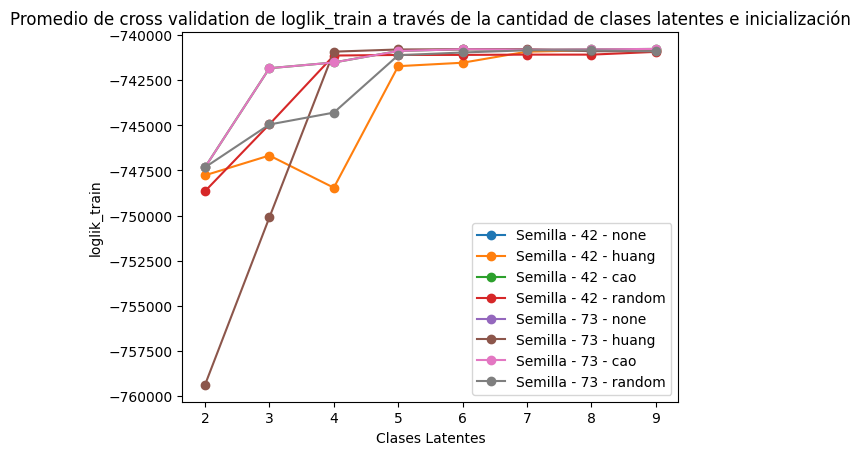

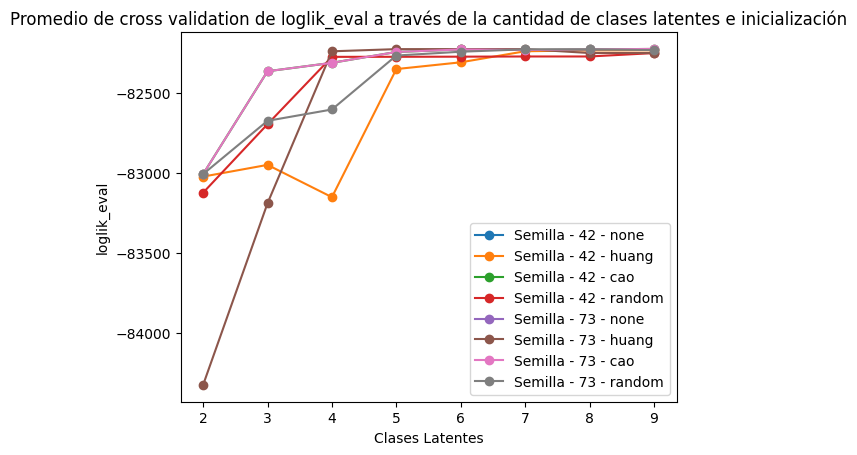

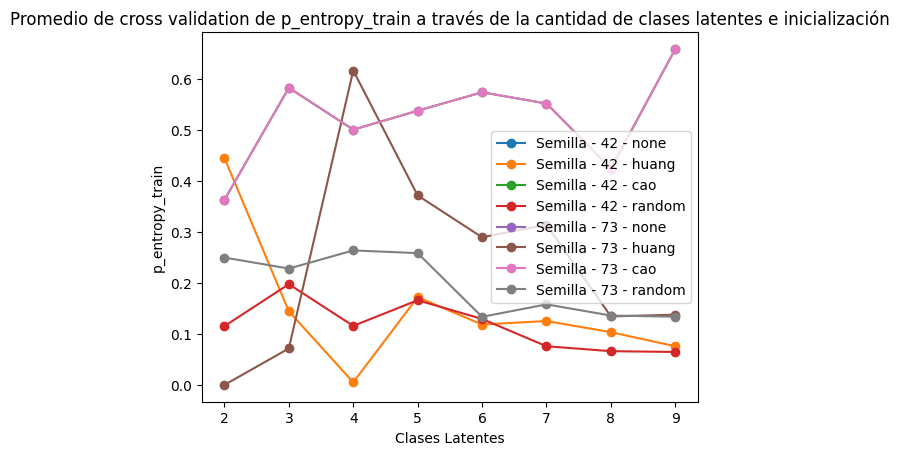

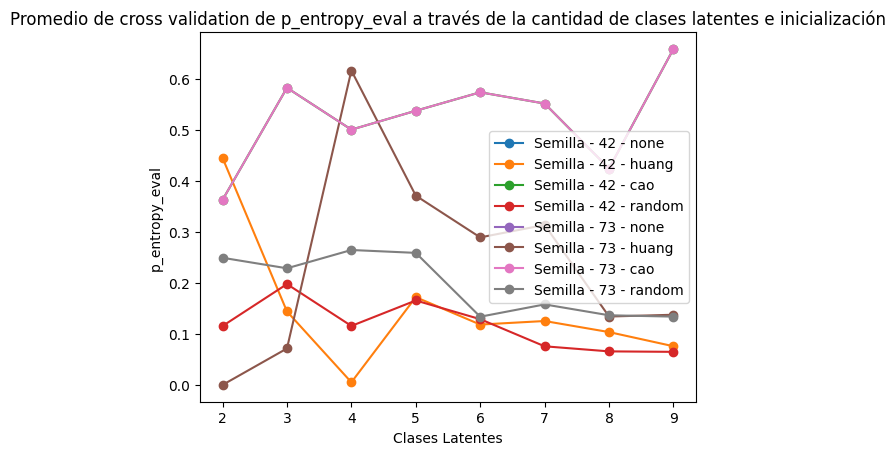

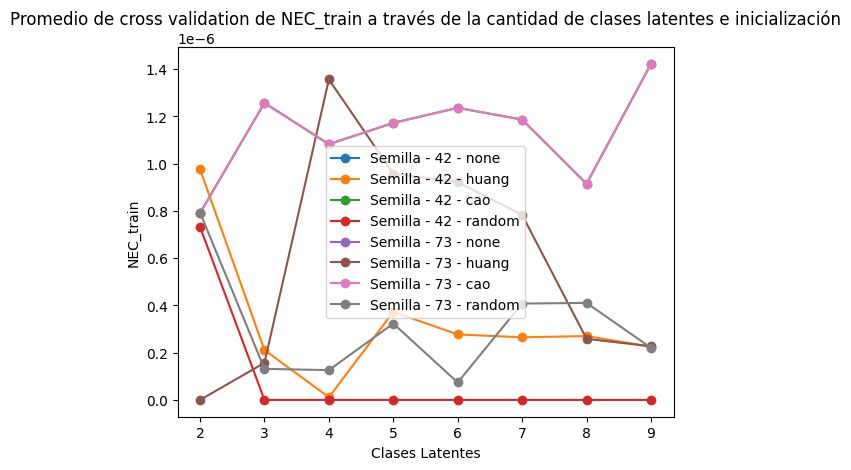

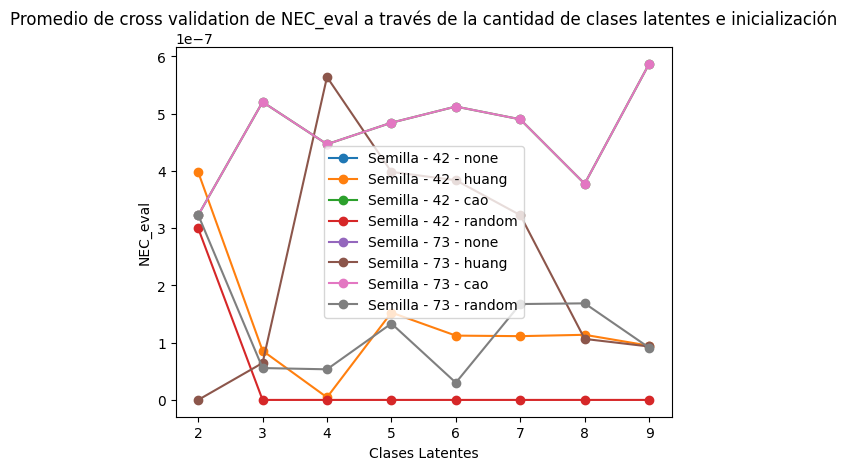

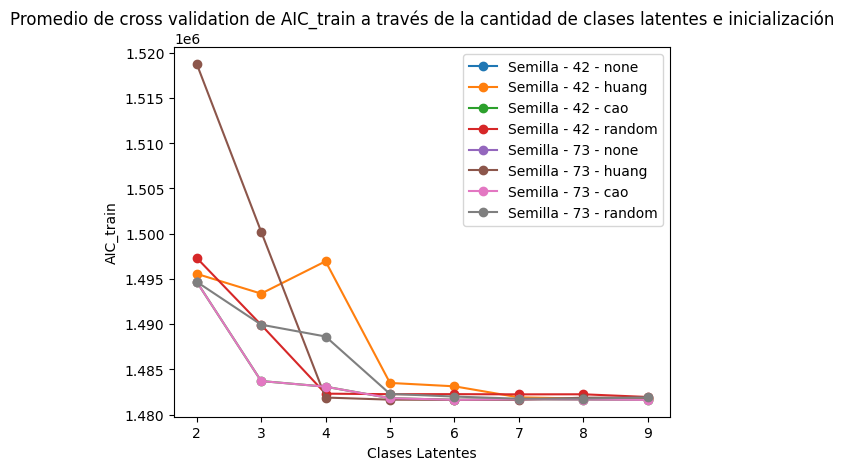

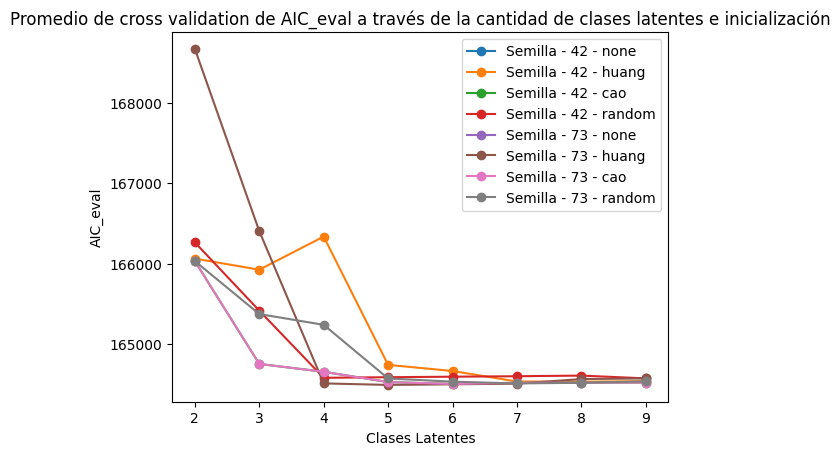

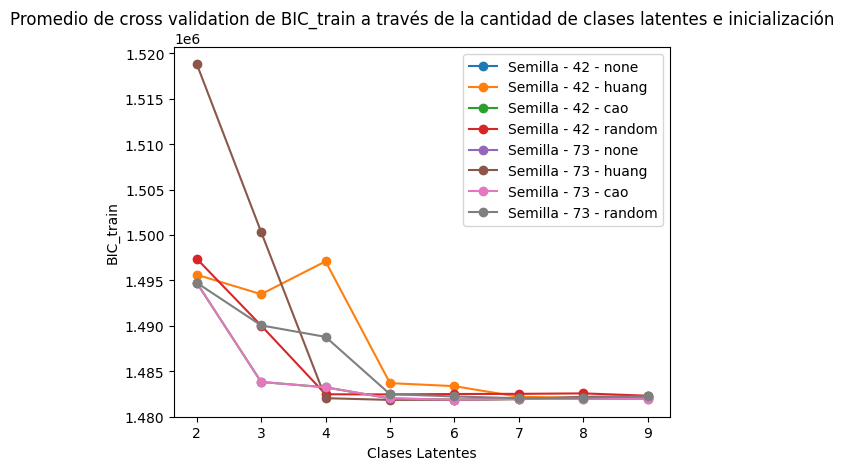

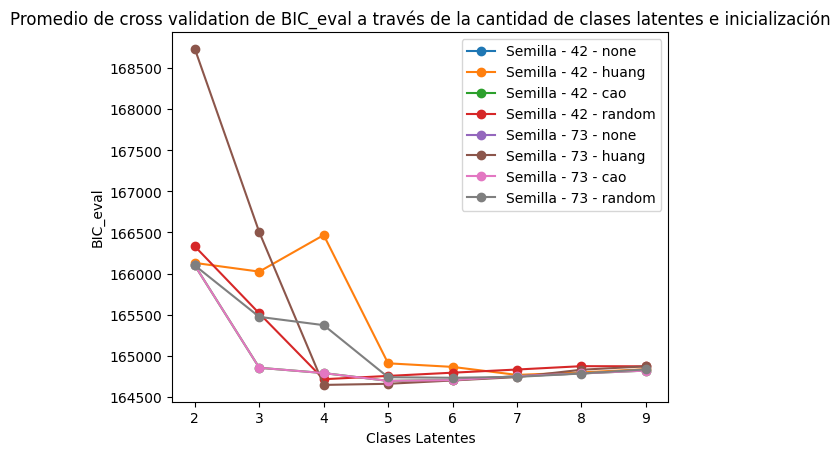

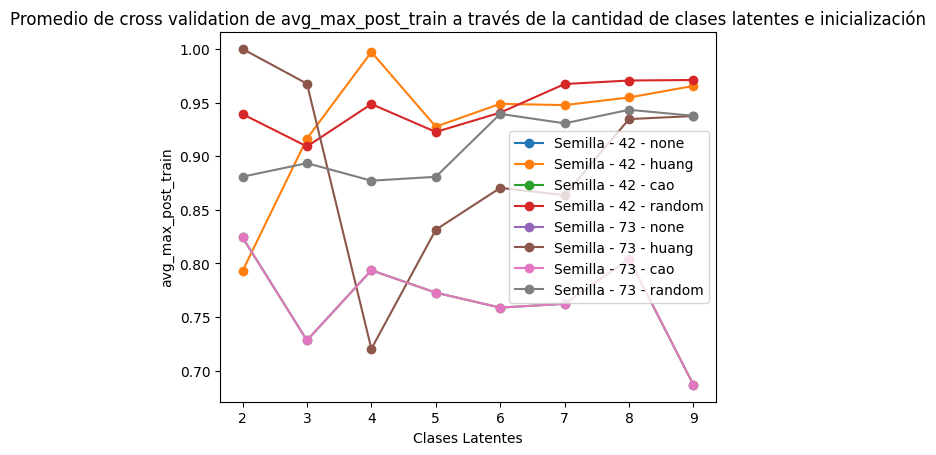

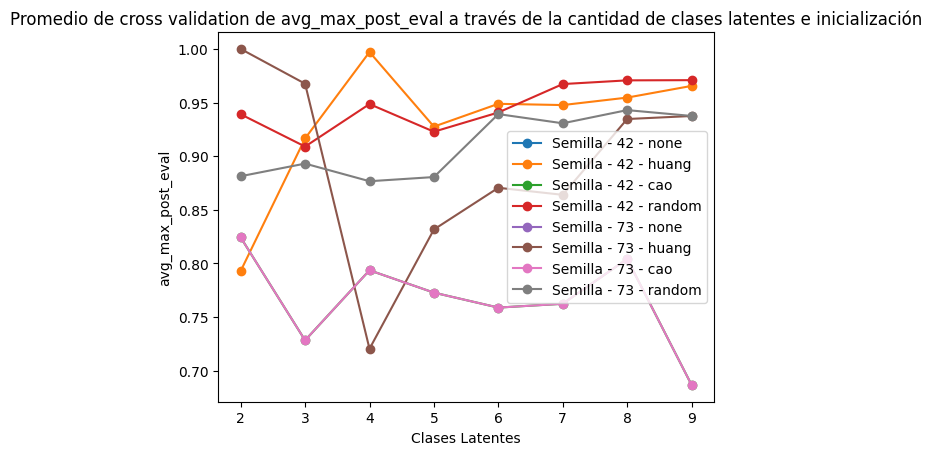

In [48]:

for metric in [
    'loglik_train',
    'loglik_eval',
    'p_entropy_train',
    'p_entropy_eval',
    'NEC_train',
    'NEC_eval',
    'AIC_train',
    'AIC_eval',
    'BIC_train',
    'BIC_eval',
    'avg_max_post_train',
    'avg_max_post_eval'
]:
    graph_metric(
        metric=metric,
        df=df_results_trainning_situation
    )

### Testeo

In [49]:
# ==== FINAL TEST EVALUATION ====
final_results_situation = []

for (seed, num_class, initialization), info in best_models_1.items():
    priors_vals, kmodes_labels_np = None, None
    if initialization != 'no_kmodes':
        # Re-initialize KModes on full training set
        priors_vals, kmodes_labels_np = get_kmodes_init_data(
            X_train_full, n_clusters=num_class, max_iter=1000, device=device
        )
        kmodes_labels = torch.tensor(kmodes_labels_np, device=device)
        # Ensure priors_vals is a numpy 1D array
        priors_vals = np.array(priors_vals.cpu(), dtype=np.float64).flatten()
        # === Detect missing clusters ===
        n_found = len(priors_vals)
        if n_found == num_class:
            components_kmodes = []
            for i in range(num_class):
                X_cluster = X_train_full[kmodes_labels == i]
                component = Categorical(n_categories=n_cat, pseudocount=1e-6).to(device)
                if len(X_cluster) > 0:
                    sample_weight = torch.ones((len(X_cluster), 1), dtype=torch.float32, device=device)
                    component.fit(X_cluster, sample_weight=sample_weight)
                components_kmodes.append(component)
            gmm_final = GeneralMixtureModel(distributions=components_kmodes, priors=priors_vals, max_iter=100000, random_state=seed, inertia=1e-6, frozen=False).to(device)
            gmm_final.fit(X_train_full)
            final_row = calculate_metrics(X_train_full, X_test, gmm_full=gmm_final, L_1=L_1, num_class=num_class, seed=seed)
            final_row["init"] = initialization
            print(f"[TEST EVAL] seed={seed} C={num_class} init={initialization} test_NEC={final_row['NEC_eval']:.4f} test_loglik={final_row['loglik_eval']:.1f}")
            final_results_situation.append(final_row)

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3904234338.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kmodes_labels = torch.tensor(kmodes_labels_np, device=device)


[TEST EVAL] seed=42 C=2 init=huang test_NEC=0.0000 test_loglik=-357723.7
[TEST EVAL] seed=42 C=3 init=huang test_NEC=0.0000 test_loglik=-352874.1
[TEST EVAL] seed=42 C=4 init=huang test_NEC=0.0000 test_loglik=-354125.0
[TEST EVAL] seed=42 C=5 init=huang test_NEC=0.0000 test_loglik=-353382.9
[TEST EVAL] seed=42 C=6 init=huang test_NEC=0.0000 test_loglik=-352928.4
[TEST EVAL] seed=42 C=8 init=huang test_NEC=0.0000 test_loglik=-352860.9
[TEST EVAL] seed=42 C=9 init=huang test_NEC=0.0000 test_loglik=-352810.3
[TEST EVAL] seed=73 C=2 init=huang test_NEC=0.0000 test_loglik=-355523.2
[TEST EVAL] seed=73 C=3 init=huang test_NEC=0.0000 test_loglik=-354526.4
[TEST EVAL] seed=73 C=4 init=huang test_NEC=0.0000 test_loglik=-354818.9
[TEST EVAL] seed=73 C=5 init=huang test_NEC=0.0000 test_loglik=-352969.5
[TEST EVAL] seed=73 C=6 init=huang test_NEC=0.0000 test_loglik=-352525.1
[TEST EVAL] seed=73 C=7 init=huang test_NEC=0.0000 test_loglik=-352469.5
[TEST EVAL] seed=73 C=8 init=huang test_NEC=0.0000 

In [50]:
df_final_situation = pd.DataFrame(final_results_situation)
df_final_situation.to_csv("./results_lca/final_test_results_kmodes_situation.csv", index=False)

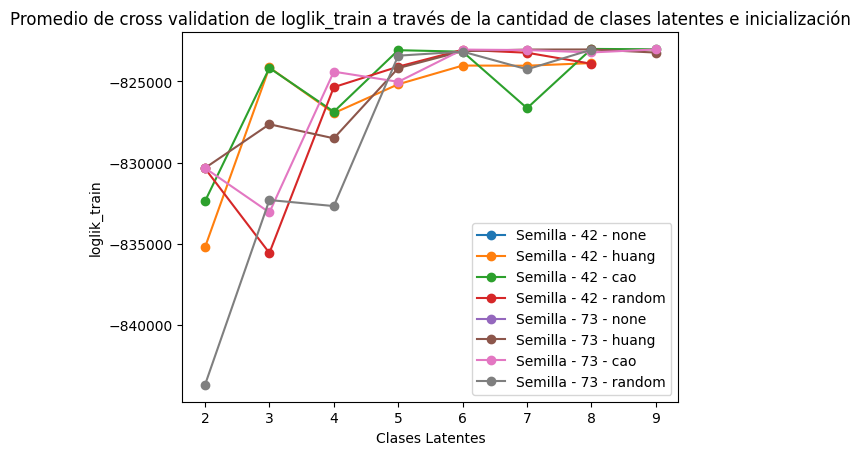

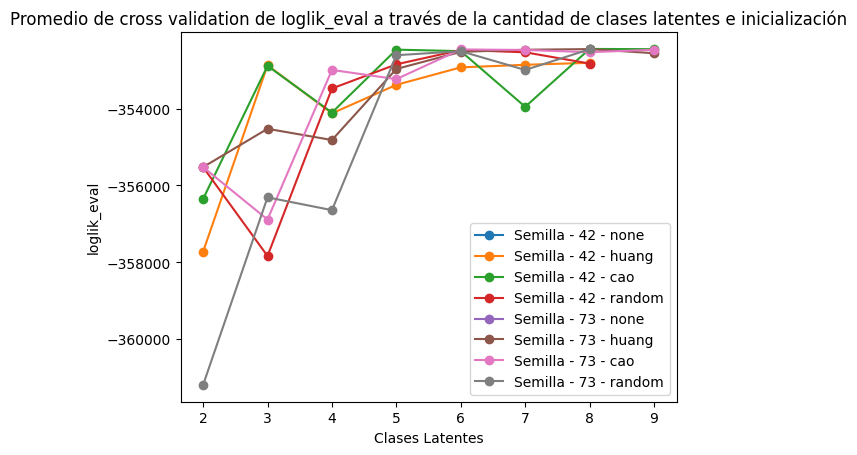

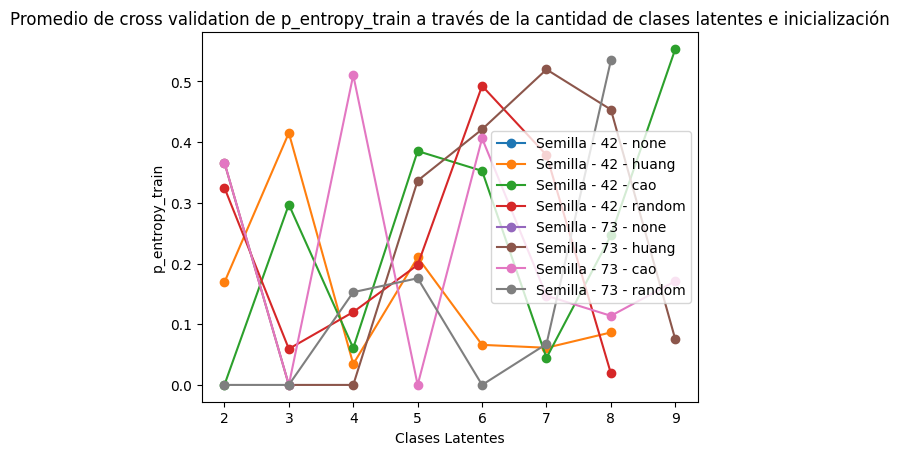

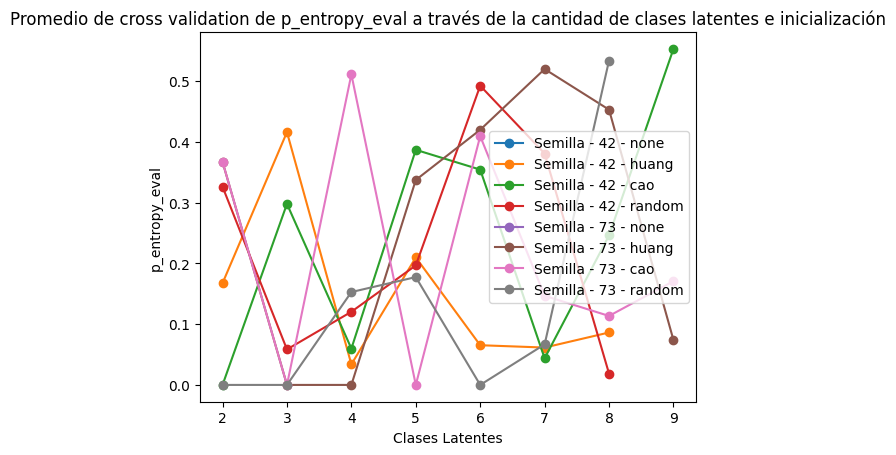

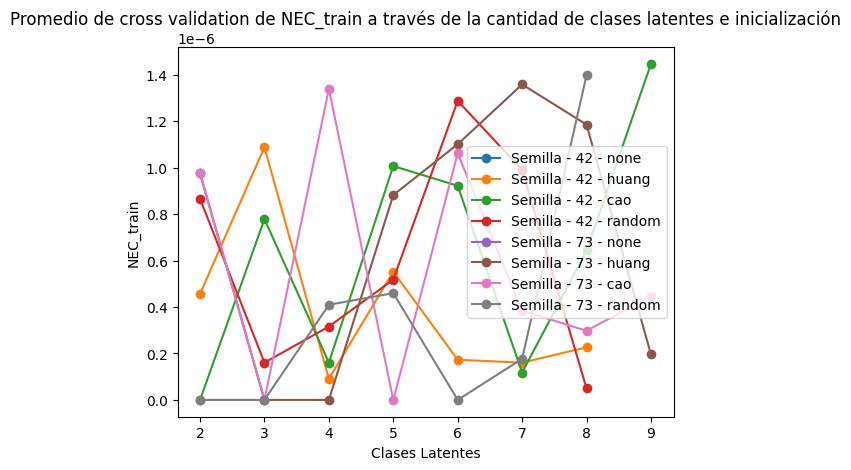

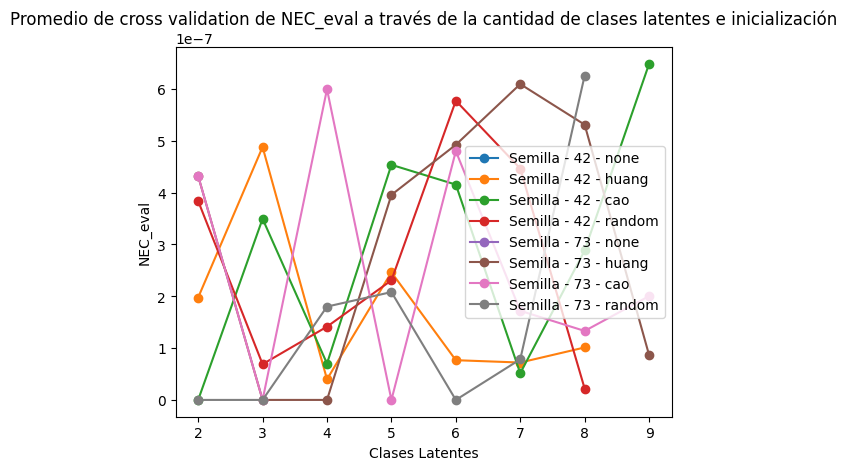

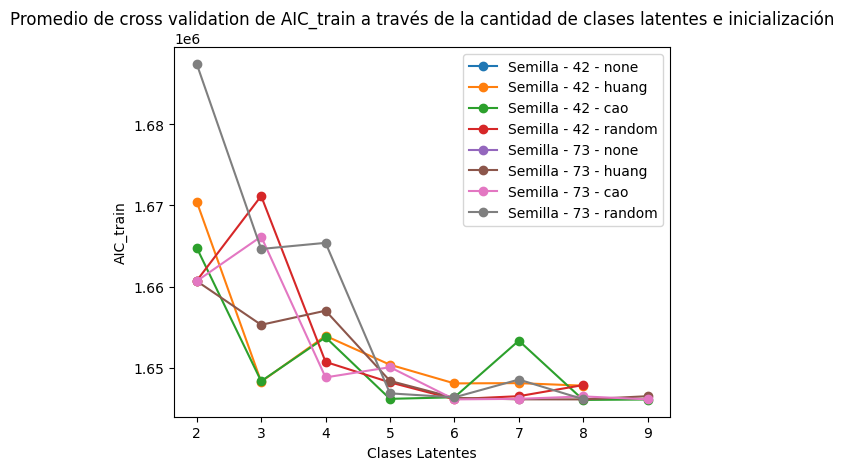

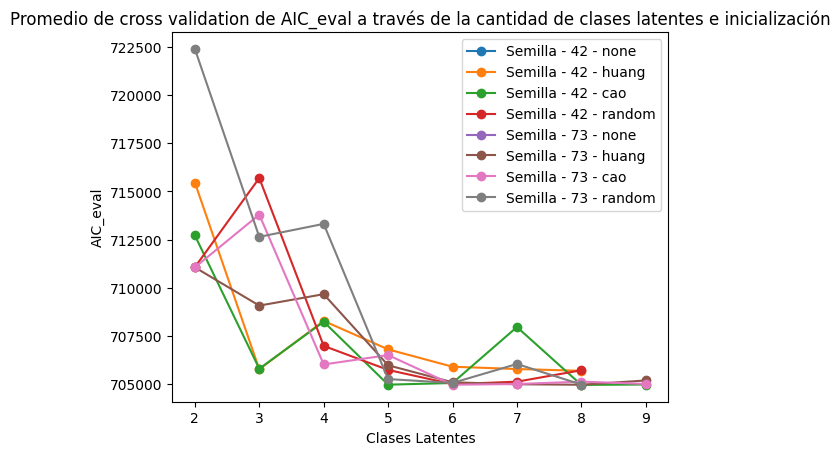

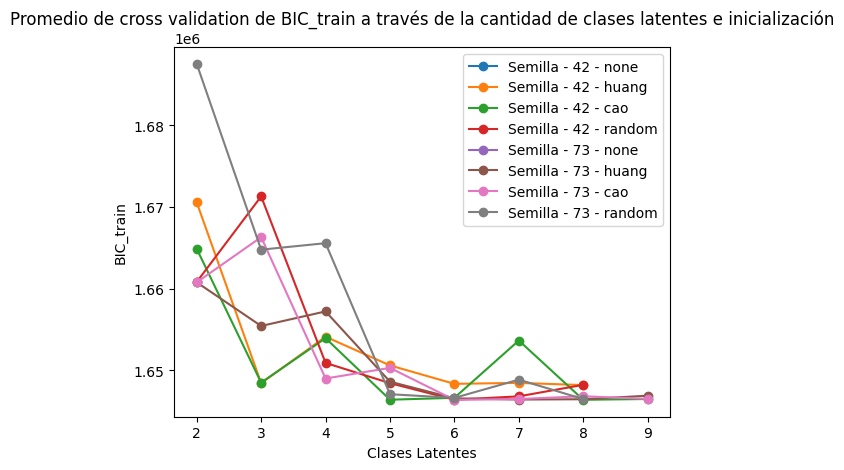

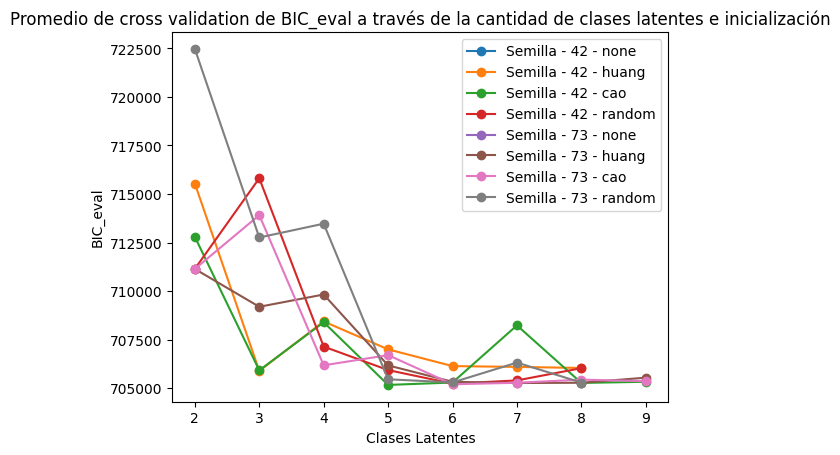

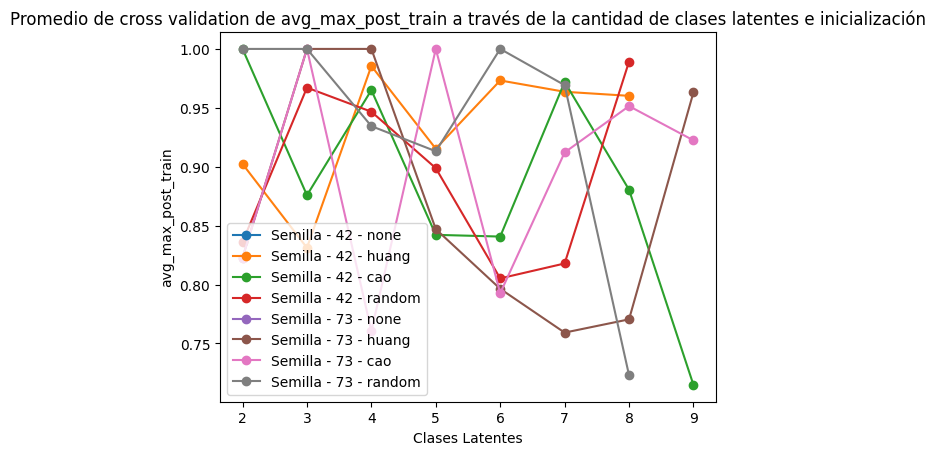

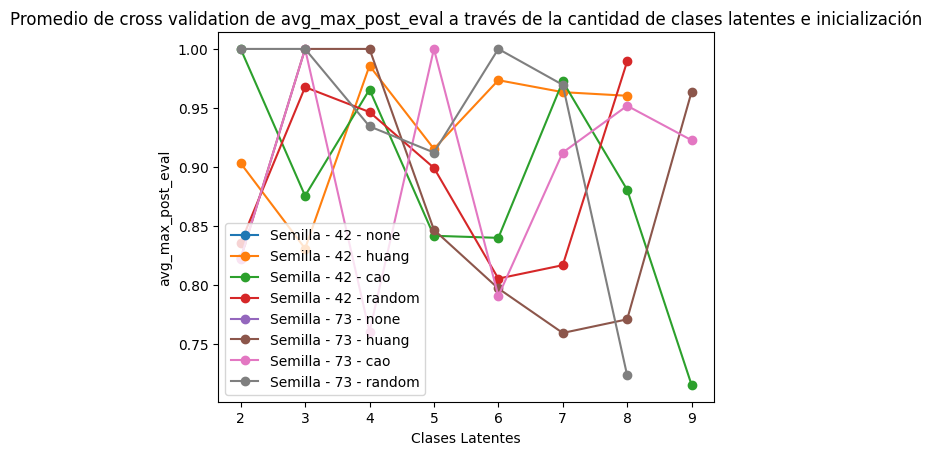

In [51]:
for metric in [
    'loglik_train',
    'loglik_eval',
    'p_entropy_train',
    'p_entropy_eval',
    'NEC_train',
    'NEC_eval',
    'AIC_train',
    'AIC_eval',
    'BIC_train',
    'BIC_eval',
    'avg_max_post_train',
    'avg_max_post_eval'
]:
    graph_metric(
        metric=metric,
        df=df_final_situation
    )

In [52]:
print(df_final_situation.columns)
df_final_situation.head(1)

Index(['num_class', 'seed', 'model', 'loglik_train', 'post_train',
       'labels_train', 'p_entropy_train', 'NEC_train', 'AIC_train',
       'BIC_train', 'avg_max_post_train', 'loglik_eval', 'post_eval',
       'labels_eval', 'p_entropy_eval', 'NEC_eval', 'AIC_eval', 'BIC_eval',
       'avg_max_post_eval', 'class_counts_train', 'class_counts_eval', 'init'],
      dtype='object')


num_class  seed                                              model  \
0          2    42  GeneralMixtureModel(\n  (distributions): Modul...   

                                        loglik_train  \
0  tensor(-835220.1335, device='cuda:0', dtype=to...   

                                          post_train  \
0  [[0.9999999999999996, 4.508150053827171e-16], ...   

                                        labels_train  p_entropy_train  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...         0.169094   

                                           NEC_train  \
0  tensor(4.5620e-07, device='cuda:0', dtype=torc...   

                                           AIC_train  \
0  tensor(1670456.2671, device='cuda:0', dtype=to...   

                                           BIC_train  ...  \
0  tensor(1670540.4000, device='cuda:0', dtype=to...  ...   

                                           post_eval  \
0  [[0.9999999999999964, 3.661946998044705e-15], ...   

                                         labels_eval p_entropy_eval  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...       0.167536   

                                            NEC_eval  \
0  tensor(1.9753e-07, device='cuda:0', dtype=torc...   

                                            AIC_eval  \
0  tensor(715463.4554, device='cuda:0', dtype=tor...   

                                            BIC_eval avg_max_post_eval  \
0  tensor(715540.8099, device='cuda:0', dtype=tor...           0.90311   

      class_counts_train      class_counts_eval   init  
0  {0: 234975, 1: 37857}  {0: 100902, 1: 16027}  huang  

[1 rows x 22 columns]

In [53]:
# Calificar los modelos
df_scored = normalize_and_score(df_final_situation, scaler='zscore',
                                imbalance_weight=5.0,
                                min_class_threshold=0.1,
                                min_class_penalty=5.0)
df_final_situation['score'] = df_scored['score_norm'].values


In [54]:
top_4_situation = df_final_situation.sort_values(by='score', ascending=False)[:4].reset_index().drop(columns=['index'], axis=1)

In [55]:
top_4_situation

num_class  seed                                              model  \
0          5    73  GeneralMixtureModel(\n  (distributions): Modul...   
1          3    73  GeneralMixtureModel(\n  (distributions): Modul...   
2          4    42  GeneralMixtureModel(\n  (distributions): Modul...   
3          4    42  GeneralMixtureModel(\n  (distributions): Modul...   

                                        loglik_train  \
0  tensor(-825025.2912, device='cuda:0', dtype=to...   
1  tensor(-827639.8783, device='cuda:0', dtype=to...   
2  tensor(-826956.3312, device='cuda:0', dtype=to...   
3  tensor(-825353.9864, device='cuda:0', dtype=to...   

                                          post_train  \
0  [[9.454277456102224e-11, 2.3270101646278961e-1...   
1  [[0.9999999999726352, 2.73649260072515e-11, 8....   
2  [[3.541996107122011e-10, 5.237664101022336e-10...   
3  [[2.8683925571384137e-08, 0.9999995221896043, ...   

                                        labels_train  p_entropy_train  \
0  [3, 2, 2, 4, 3, 1, 3, 4, 2, 3, 3, 2, 0, 1, 2, ...     3.761075e-06   
1  [0, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2, ...     9.672974e-10   
2  [2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0, ...     3.442459e-02   
3  [1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 1, 2, 3, 0, 2, ...     1.201339e-01   

                                           NEC_train  \
0  tensor(9.8753e-12, device='cuda:0', dtype=torc...   
1  tensor(2.5574e-15, device='cuda:0', dtype=torc...   
2  tensor(9.0848e-08, device='cuda:0', dtype=torc...   
3  tensor(3.1570e-07, device='cuda:0', dtype=torc...   

                                           AIC_train  \
0  tensor(1650090.5825, device='cuda:0', dtype=to...   
1  tensor(1655303.7567, device='cuda:0', dtype=to...   
2  tensor(1653944.6625, device='cuda:0', dtype=to...   
3  tensor(1650739.9728, device='cuda:0', dtype=to...   

                                           BIC_train  ...  \
0  tensor(1650300.9147, device='cuda:0', dtype=to...  ...   
1  tensor(1655429.9560, device='cuda:0', dtype=to...  ...   
2  tensor(1654112.9283, device='cuda:0', dtype=to...  ...   
3  tensor(1650908.2386, device='cuda:0', dtype=to...  ...   

                                         labels_eval p_entropy_eval  \
0  [0, 1, 1, 1, 0, 0, 1, 1, 2, 4, 1, 2, 3, 4, 3, ...   3.344532e-06   
1  [0, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 2, 0, 0, 0, ...   9.714711e-10   
2  [0, 3, 3, 1, 2, 1, 3, 1, 0, 0, 1, 0, 2, 0, 2, ...   3.389771e-02   
3  [1, 3, 3, 0, 1, 0, 3, 0, 2, 2, 0, 2, 1, 2, 1, ...   1.204277e-01   

                                            NEC_eval  \
0  tensor(3.9225e-12, device='cuda:0', dtype=torc...   
1  tensor(1.1411e-15, device='cuda:0', dtype=torc...   
2  tensor(3.9797e-08, device='cuda:0', dtype=torc...   
3  tensor(1.4128e-07, device='cuda:0', dtype=torc...   

                                            AIC_eval  \
0  tensor(706508.2995, device='cuda:0', dtype=tor...   
1  tensor(709076.7805, device='cuda:0', dtype=tor...   
2  tensor(708282.0766, device='cuda:0', dtype=tor...   
3  tensor(706986.7182, device='cuda:0', dtype=tor...   

                                            BIC_eval avg_max_post_eval  \
0  tensor(706701.6859, device='cuda:0', dtype=tor...          1.000000   
1  tensor(709192.8124, device='cuda:0', dtype=tor...          1.000000   
2  tensor(708436.7858, device='cuda:0', dtype=tor...          0.985733   
3  tensor(707141.4274, device='cuda:0', dtype=tor...          0.946499   

                                  class_counts_train  \
0  {0: 35558, 1: 80543, 2: 74193, 3: 51122, 4: 31...   
1                     {0: 98028, 1: 97836, 2: 76968}   
2          {0: 109175, 1: 70376, 2: 49686, 3: 43595}   
3          {0: 59524, 1: 57853, 2: 101008, 3: 54447}   

                                   class_counts_eval    init     score  
0  {0: 15245, 1: 34901, 2: 31451, 3: 21710, 4: 13...     cao  6.241660  
1                     {0: 41852, 1: 42461, 2: 32616}   huang  4.355959  
2           {0: 46537, 1: 30460, 2: 21042, 3: 18890}

## Interpretando los resultados

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\4222716296.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


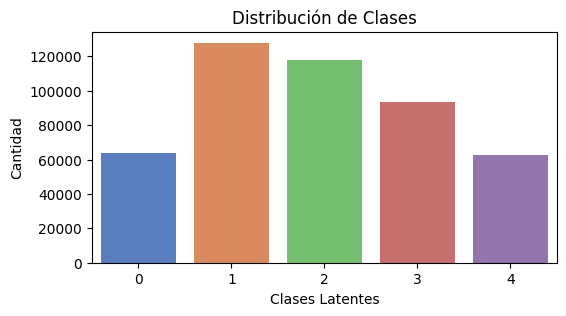

prediction_situation  VIC_EST_CIV  VIC_REL_AGR  AGR_EST_CIV  \
0                     0  casados(as)  esposos(as)  casados(as)   
1                     1  casados(as)  esposos(as)  casados(as)   
2                     2  casados(as)  esposos(as)  casados(as)   
3                     3  casados(as)  esposos(as)  casados(as)   
4                     4  casados(as)  esposos(as)  casados(as)   

  AGR_ESCOLARIDAD VIC_ESCOLARIDAD AGR_TRABAJA VIC_TRABAJA  
0         ninguno         ninguno          si          no  
1  sexto primaria  sexto primaria          si          no  
2  sexto primaria  sexto primaria          si          no  
3         ninguno         ninguno          si          no  
4         ninguno         ninguno          si          no

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\4222716296.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


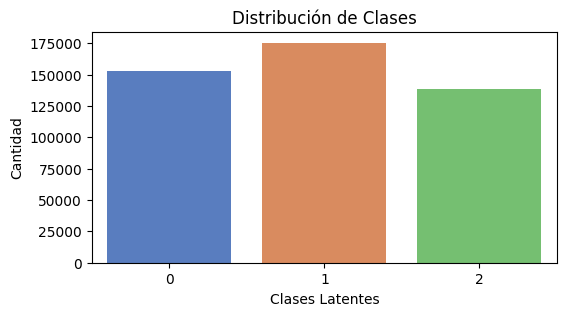

prediction_situation  VIC_EST_CIV  VIC_REL_AGR  AGR_EST_CIV  \
0                     0  casados(as)  esposos(as)  casados(as)   
1                     1  casados(as)  esposos(as)  casados(as)   
2                     2  casados(as)  esposos(as)  casados(as)   

  AGR_ESCOLARIDAD VIC_ESCOLARIDAD AGR_TRABAJA VIC_TRABAJA  
0         ninguno         ninguno          si          no  
1  sexto primaria  sexto primaria          si          no  
2  sexto primaria  sexto primaria          si          no

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\4222716296.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


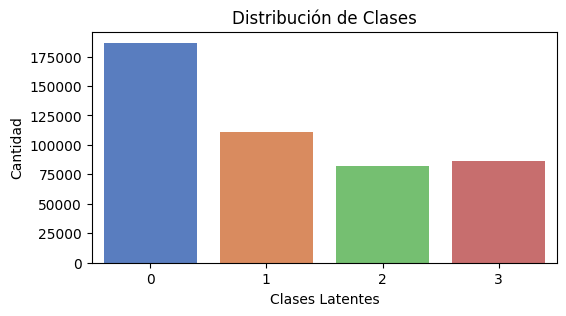

prediction_situation  VIC_EST_CIV  VIC_REL_AGR  AGR_EST_CIV  \
0                     0  casados(as)  esposos(as)  casados(as)   
1                     1  casados(as)  esposos(as)  casados(as)   
2                     2  casados(as)  esposos(as)  casados(as)   
3                     3  casados(as)  esposos(as)  casados(as)   

  AGR_ESCOLARIDAD          VIC_ESCOLARIDAD AGR_TRABAJA VIC_TRABAJA  
0  sexto primaria                  ninguno          si          no  
1  tercero basico      sexto diversificado          si          no  
2         ninguno                  ninguno          si          no  
3  sexto primaria  primaria grado ignorado          si          no

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\4222716296.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


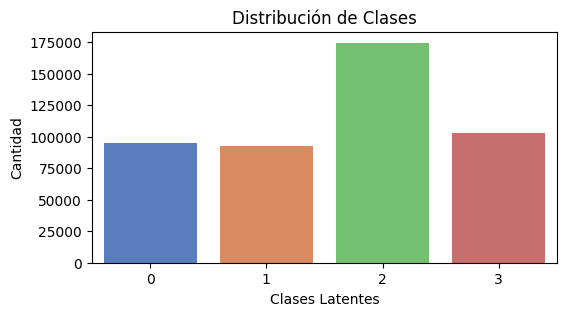

prediction_situation  VIC_EST_CIV  VIC_REL_AGR  AGR_EST_CIV  \
0                     0  casados(as)  esposos(as)  casados(as)   
1                     1  casados(as)  esposos(as)  casados(as)   
2                     2  casados(as)  esposos(as)  casados(as)   
3                     3  casados(as)  conviviente  casados(as)   

  AGR_ESCOLARIDAD      VIC_ESCOLARIDAD AGR_TRABAJA VIC_TRABAJA  
0  tercero basico  sexto diversificado          si          no  
1         ninguno              ninguno          si          no  
2  sexto primaria              ninguno          si          no  
3  sexto primaria              ninguno          si          no

In [152]:
for index in range(top_4_situation.shape[0]):
    top = top_4_situation.iloc[index]
    model_p = top['model'] 

    # sanity checks
    assert X.dim() == 2, "input must be 2D (n_samples, n_features)"
    assert (X >= 0).all().item(), "categorical codes must be non-negative"
    

    df['prediction_situation'] = model_p.predict(torch.tensor(df[ENCODED_VARS_SITUATION].to_numpy(), dtype=torch.int32, device=device)).cpu()
    df_complete['prediction_situation'] = model_p.predict(torch.tensor(df_complete[ENCODED_VARS_SITUATION].to_numpy(), dtype=torch.int32, device=device)).cpu()
    df['prediction_situation_probs'] = np.nan
    df['prediction_situation_probs'] = model_p.predict_proba(torch.tensor(df[ENCODED_VARS_SITUATION].to_numpy(), dtype=torch.int32, device=device)).cpu()
    df_complete['prediction_situation_probs'] = np.nan
    df_complete['prediction_situation_probs'] = model_p.predict_proba(torch.tensor(df_complete[ENCODED_VARS_SITUATION].to_numpy(), dtype=torch.int32, device=device)).cpu()
    # -- class sizes
    unique, counts = np.unique(df['prediction_situation'], return_counts=True)
    plt.figure(figsize=(6,3))
    sns.barplot(x=unique, y=counts, palette="muted")
    plt.title(f"Distribución de Clases")
    plt.xlabel("Clases Latentes")
    plt.ylabel("Cantidad")
    plt.show()
    
    # Count most frequent combination of VARIABLES per prediction
    group_profiles = (
        df_complete.groupby("prediction_situation")[VARIABLES]
        .agg(lambda x: x.value_counts().idxmax())   # most frequent
        .reset_index()
    )
    display(group_profiles)

In [57]:
model = top_4_situation.iloc[0]['model']

In [58]:
import joblib

for index in range(top_4_situation.shape[0]):
    top = top_4_situation.iloc[index]
    model_p = top['model'] 
    joblib.dump(model_p, f"./models/gmm_model_no_kmodes_situation_top{index}.pkl")

In [60]:
# Bootstrap robusto GPU-first para pomegranate GeneralMixtureModel
import os
import time
import pickle
import numpy as np
import torch
from copy import deepcopy
from tqdm import trange
from scipy.special import logsumexp  # solo usado si necesitas numpy fallback

# ---------- Configuración ----------
B = 1000
method = 'parametric'   # 'parametric' o 'nonparametric'
rng = np.random.default_rng(12345)
n, d = X_train_full.shape
S = len(model.distributions)
max_iter_replica = 2000
tol_replica = 1e-6
n_retries = 3
checkpoint_every = 100  # guarda checkpoint cada K réplicas
checkpoint_dir = "./bootstrap_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ---------- Device ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ---------- Helpers de conversión y validación ----------
def to_torch(x, dtype=torch.float32, device=device):
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    return torch.as_tensor(x, dtype=dtype, device=device)

def to_cpu_scalar(x):
    if isinstance(x, torch.Tensor):
        return float(x.detach().cpu().item())
    return float(x)

def safe_detach_cpu_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

# ---------- Preparar modelo y datos en device ----------
# mover modelo al device (pomegranate GeneralMixtureModel soporta .to(device))
try:
    model = model.to(device)
except Exception:
    # si falla, dejamos modelo como está; intentaremos pasar tensores al mismo device
    pass

# asegurar X como tensor en device
X_t = X_train_full.detach().to(device)

# si necesitas X en numpy para NP resampling, crea X_np
X_np = None
if method == 'nonparametric':
    X_np = safe_detach_cpu_np(X_t)

# priors (pi_hat) y copias de componentes (mantener como objetos pomegranate)
raw_priors = getattr(model, 'priors', None)
if raw_priors is None:
    pi_hat = np.full(S, 1.0 / S)
else:
    pi_hat = safe_detach_cpu_np(raw_priors)

components_hat = [deepcopy(c) for c in model.distributions]

# ---------- Almacenamiento (escalares en CPU, vectores grandes opcionales en disco) ----------
EN_boot = np.full(B, np.nan, dtype=float)
E_boot  = np.full(B, np.nan, dtype=float)
# si n grande evita reservar B x n en memoria GPU; lo guardamos en disco por bloques
store_e_per_obs = False  # si True, requerirá mucha memoria; usa con precaución
if method == 'parametric' and store_e_per_obs:
    e_boot = np.full((B, n), np.nan, dtype=float)
else:
    e_boot = None

success = np.zeros(B, dtype=bool)
error_msgs = [None] * B

# ---------- Funciones auxiliares ----------

def make_model_from_mle(pi_init, comps_init, max_iter=2000, tol=1e-6, random_state=None, device=device):
    comps_copy = [deepcopy(c) for c in comps_init]
    m = GeneralMixtureModel(distributions=comps_copy, priors=np.array(pi_init), max_iter=max_iter, tol=tol, random_state=random_state)
    try:
        m = m.to(device)
    except Exception:
        pass
    return m

def get_posteriors_from_model_tensor(m, X_t):
    """
    Devuelve tensor (n, S) con posterioris en el mismo device que X_t.
    Intenta usar m.predict_proba si devuelve torch.Tensor; si no, usa internals y torch ops.
    """
    # intentar predict_proba (puede devolver numpy or torch)
    if hasattr(m, 'predict_proba'):
        a = m.predict_proba(X_t)
        if isinstance(a, torch.Tensor):
            return a.to(device=X_t.device, dtype=torch.float32)
        else:
            return torch.as_tensor(a, device=X_t.device, dtype=torch.float32)

    # fallback a _emission_matrix que en pomegranate devuelve tensor si X_t es tensor
    if hasattr(m, '_emission_matrix'):
        logp = m._emission_matrix(X_t)  # esperado tensor (n, S) en device
        if not isinstance(logp, torch.Tensor):
            logp = torch.as_tensor(logp, device=X_t.device, dtype=torch.float32)
        lse = torch.logsumexp(logp, dim=1, keepdim=True)
        a = torch.exp(logp - lse)
        return a

    raise RuntimeError("No se puede extraer posterioris: adapta según tu versión de pomegranate.")

def safe_fit_with_retries(factory, Xb_t, n_retries=3, increase_smooth=False):
    last_err = None
    for attempt in range(n_retries):
        m = factory()
        try:
            try:
                m = m.to(device)
            except Exception:
                pass
            # fit acepta tensors; si no, intentará convertir
            m.fit(Xb_t)
            # comprobar log_probability si hay (devuelve tensor o scalar)
            if hasattr(m, 'log_probability'):
                lp = m.log_probability(Xb_t)
                # convertir a numpy/torch y comprobar finitos
                if isinstance(lp, torch.Tensor):
                    lp_np = lp.detach().cpu().numpy()
                else:
                    lp_np = np.asarray(lp)
                if np.any(np.isnan(lp_np)) or not np.isfinite(lp_np).all():
                    raise RuntimeError("log_probability contiene NaN/Inf")
            return m, None
        except Exception as e:
            last_err = e
            # intento heurístico de smoothing: modificar pseudocounts si existen
            if increase_smooth:
                try:
                    comps = factory().__dict__.get('distributions', [])
                    for comp in comps:
                        if hasattr(comp, 'pseudocount'):
                            comp.pseudocount = max(getattr(comp, 'pseudocount', 0), 1e-3)
                except Exception:
                    pass
            # seguir con siguiente intento
    return None, last_err

# ---------- Loop bootstrap GPU-first ----------
start_time = time.time()
for b in trange(B):
    try:
        # 1) generar réplica como tensor en device
        if method == 'parametric':
            sampled = model.sample(n)  # normalmente devuelve torch.Tensor en device
            Xb_t = sampled if isinstance(sampled, torch.Tensor) else torch.as_tensor(sampled, device=device)
        else:
            idx = rng.integers(0, n, size=n)
            Xb_np = X_np[idx]
            Xb_t = torch.as_tensor(Xb_np, device=device)

        # 2) ajustar con reintentos (inicializar desde MLE)
        model_b, err = safe_fit_with_retries(lambda: make_model_from_mle(pi_hat, components_hat, max_iter=max_iter_replica, tol=tol_replica), Xb_t, n_retries=n_retries, increase_smooth=True)
        if model_b is None:
            success[b] = False
            error_msgs[b] = str(err)
            continue

        # 3) obtener posterioris en tensor
        a_b_t = get_posteriors_from_model_tensor(model_b, Xb_t)   # (n, S) tensor
        if a_b_t.ndim != 2 or a_b_t.shape[1] != S:
            raise RuntimeError(f"Posterioris con forma inesperada: {tuple(a_b_t.shape)}")

        # 4) métricas (torch)
        hi_b_t = -(a_b_t * torch.log(a_b_t + 1e-16)).sum(dim=1)    # (n,)
        EN_b_t = hi_b_t.sum()                                      # tensor scalar
        E_b_val = 1.0 - (EN_b_t / (n * torch.log(torch.tensor(float(S), device=device))))
        # guardar escalares en CPU numpy
        EN_boot[b] = to_cpu_scalar(EN_b_t)
        E_boot[b]  = to_cpu_scalar(E_b_val)

        if method == 'parametric' and store_e_per_obs:
            e_b_t = 1.0 - torch.max(a_b_t, dim=1).values
            e_boot[b, :] = safe_detach_cpu_np(e_b_t)

        success[b] = True

    except Exception as ex:
        success[b] = False
        error_msgs[b] = str(ex)

    # checkpointing cada K réplicas
    if (b + 1) % checkpoint_every == 0:
        ck = {
            'b': b + 1,
            'EN_boot': EN_boot,
            'E_boot': E_boot,
            'e_boot': e_boot,
            'success': success,
            'error_msgs': error_msgs,
            'elapsed_seconds': time.time() - start_time
        }
        with open(os.path.join(checkpoint_dir, f'bootstrap_ck_b{b+1}.pkl'), 'wb') as f:
            pickle.dump(ck, f)

# ---------- Resumen y protección contra NaNs ----------
def summarize_scalar_boot_safe(arr_boot, orig, alpha=0.05):
    valid = arr_boot[~np.isnan(arr_boot)]
    n_valid = valid.size
    if n_valid == 0:
        return {'mean': np.nan, 'bias': np.nan, 'se': np.nan, 'ci': (np.nan, np.nan), 'n_valid': 0}
    mean_b = float(np.mean(valid))
    bias = float(mean_b - orig)
    se = float(np.std(valid, ddof=1)) if n_valid > 1 else np.nan
    lower, upper = np.percentile(valid, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': mean_b, 'bias': bias, 'se': se, 'ci': (float(lower), float(upper)), 'n_valid': int(n_valid)}

def summarize_vector_boot_safe(arr_boot_2d, orig_vec, alpha=0.05):
    mean_b = np.nanmean(arr_boot_2d, axis=0)
    bias = mean_b - orig_vec
    se = np.nanstd(arr_boot_2d, axis=0, ddof=1)
    lower = np.nanpercentile(arr_boot_2d, 100*alpha/2, axis=0)
    upper = np.nanpercentile(arr_boot_2d, 100*(1-alpha/2), axis=0)
    allnan = np.all(np.isnan(arr_boot_2d), axis=0)
    lower[allnan] = np.nan
    upper[allnan] = np.nan
    return {'mean': mean_b, 'bias': bias, 'se': se, 'ci': (lower, upper), 'n_valid_per_obs': np.sum(~np.isnan(arr_boot_2d), axis=0)}

# calcular estadísticas originales (a_hat, e_hat, EN_hat, E_hat) en device y mover escalars a CPU
a_hat_t = get_posteriors_from_model_tensor(model, X_t)
max_post_t = torch.max(a_hat_t, dim=1).values
e_hat = safe_detach_cpu_np(1.0 - max_post_t)
hi_t = -(a_hat_t * torch.log(a_hat_t + 1e-16)).sum(dim=1)
EN_hat = to_cpu_scalar(hi_t.sum())
E_hat = 1.0 - EN_hat / (n * np.log(S))

summary_EN = summarize_scalar_boot_safe(EN_boot, EN_hat)
summary_E  = summarize_scalar_boot_safe(E_boot, E_hat)
summary_e = None
if method == 'parametric' and store_e_per_obs:
    summary_e = summarize_vector_boot_safe(e_boot, e_hat)

# reporte final y checkpoint final
n_valid = int(success.sum())
print(f"Bootstrap finished: {n_valid}/{B} valid replicas; {B-n_valid} failed.")
if n_valid < max(10, B // 10):
    print("Advertencia: pocas réplicas válidas. Revisa error_msgs para las primeras fallidas:")
    failed_idx = np.where(~success)[0]
    print([error_msgs[i] for i in failed_idx[:10]])

with open(os.path.join(checkpoint_dir, 'bootstrap_final_summary.pkl'), 'wb') as f:
    pickle.dump({'EN_boot': EN_boot, 'E_boot': E_boot, 'e_boot': e_boot, 'success': success, 'error_msgs': error_msgs, 'summary_EN': summary_EN, 'summary_E': summary_E, 'summary_e': summary_e, 'EN_hat': EN_hat, 'E_hat': E_hat, 'e_hat': e_hat}, f)

print("Summary E:", summary_E)


Using device: cuda


100%|██████████| 1000/1000 [02:21<00:00,  7.08it/s]

Bootstrap finished: 1000/1000 valid replicas; 0 failed.
Summary E: {'mean': 0.9999965872764588, 'bias': -1.07611852684375e-06, 'se': 2.4914410648202304e-07, 'ci': (0.9999960660934448, 0.9999970197677612), 'n_valid': 1000}


In [62]:
def get_posteriors_from_model(model, df, encoded_vars, device=None):
    """
    Obtiene posteriors (n_samples, n_classes) desde model.predict_proba.
    Acepta que model.predict_proba acepte numpy o torch.Tensor.
    - model: objeto pomegranate (o similar) con método predict_proba.
    - df: DataFrame original con columnas encoded_vars (enteros 0..C-1).
    - encoded_vars: lista de nombres de columnas en df usadas por el modelo.
    - device: torch device string si quieres usar tensores (ej. 'cuda:0') o None.
    Devuelve: ndarray (n, k) de posteriors en CPU (float64).
    """
    X = df[encoded_vars].to_numpy()
    # Intentar pasar tensores torch si el método acepta torch
    try:
        if device is not None:
            xt = torch.tensor(X, dtype=torch.long, device=device)
            post = model.predict_proba(xt)
            # Si devuelve tensor, convertir a cpu numpy
            if isinstance(post, torch.Tensor):
                return post.detach().cpu().numpy()
        # Si lo anterior falla, intentar con numpy
    except Exception:
        pass

    # Intentar con numpy (la opción más compatible)
    post = model.predict_proba(X)
    # Si devuelve tensor o lista, convertir a numpy
    if isinstance(post, torch.Tensor):
        return post.detach().cpu().numpy()
    return np.asarray(post)

def class_probability_matrix_from_posteriors(df, posteriors, vars_cat, category_maps=None):
    """
    Calcula P(X = c | class = j) para cada var en vars_cat usando posteriors (n,k).
    - df: DataFrame con las variables categóricas codificadas (valores reales o categorías).
    - posteriors: ndarray shape (n, k)
    - vars_cat: lista de variable names a procesar
    - category_maps: optional dict var -> list_of_categories (order to display). 
      Si no se da, usa df[var].astype('category').cat.categories
    Devuelve:
      - probs: dict var -> DataFrame index=categories, columns=Class_1..Class_k (prob.)
      - prevalences: Series con prevalencia esperada por clase
    """
    n, k = posteriors.shape
    prevalences = posteriors.sum(axis=0) / n
    class_cols = [f'Class_{j+1}' for j in range(k)]
    probs = {}

    for var in vars_cat:
        series = df[var].astype('category')
        if category_maps and var in category_maps:
            cats = list(category_maps[var])
            # asegurarse de que las categorías existan en la serie
            series = series.cat.set_categories(cats)
        else:
            cats = list(series.cat.categories)

        mat = np.zeros((len(cats), k), dtype=float)
        denom = posteriors.sum(axis=0)  # shape (k,)

        # calcular para cada categoría
        # vectorizado: construir matriz indicador (n, m_cats)
        indicators = np.vstack([(series == c).astype(float).values for c in cats])  # shape (m, n)
        # numerador por cat y clase: indicators @ posteriors -> (m, k)
        numer = indicators @ posteriors  # (m, k) because indicators (m,n) x (n,k) -> (m,k)
        # normalizar
        with np.errstate(divide='ignore', invalid='ignore'):
            mat = np.where(denom > 0, numer / denom[None, :], np.nan)

        probs[var] = pd.DataFrame(mat, index=cats, columns=class_cols)

    prevalences = pd.Series(prevalences, index=class_cols)
    return probs, prevalences


In [ ]:
import pickle as pkl

model_situation = pkl.load(open("./models/gmm_model_no_kmodes_situation_top0.pkl", "rb"))
df['prediction_situation'] = model_situation.predict(torch.tensor(df[ENCODED_VARS_SITUATION].to_numpy(), dtype=torch.int32, device=device)).cpu()
posteriors = get_posteriors_from_model(model_situation, df_complete, ENCODED_VARS_SITUATION, device=None)

probs_dict, preval = class_probability_matrix_from_posteriors(df_complete, posteriors, ENCODED_VARS_SITUATION)

print(preval)
for col in ENCODED_VARS_SITUATION:
    print(f"Probabilidades condicionales para {col}:")
    print(probs_dict[col].set_index(label_encoders[col.split('_ENC')[0]].inverse_transform(probs_dict[col].index)).round(3))

for var, table in probs_dict.items():
    table.index = label_encoders[var.split('_ENC')[0]].inverse_transform(table.index)
    latex = table.to_latex(float_format="%.3f")
    with open(f"../documento/plantilla/results_lca/prob_matrix_situation_{var}.tex", "w", encoding="utf8") as f:
        f.write(latex)


Class_1    0.134862
Class_2    0.288768
Class_3    0.237156
Class_4    0.208281
Class_5    0.130934
dtype: float64
Probabilidades condicionales para AGR_ES_INDIGENA_ENC:
          Class_1  Class_2  Class_3  Class_4  Class_5
ignorado    0.139     0.09    0.089    0.127    0.168
no          0.460     0.91    0.911    0.000    0.000
si          0.400     0.00    0.000    0.873    0.832
Probabilidades condicionales para AGR_NIV_ESCOLARIDAD_ENC:
               Class_1  Class_2  Class_3  Class_4  Class_5
basicos          0.155    0.199    0.189    0.131    0.135
diversificado    0.135    0.214    0.253    0.115    0.126
ninguno          0.222    0.105    0.098    0.256    0.246
primaria         0.473    0.450    0.405    0.488    0.476
universidad      0.015    0.033    0.055    0.011    0.016
Probabilidades condicionales para VIOLENCIA_FISICA_ENC:
             Class_1  Class_2  Class_3  Class_4  Class_5
no presente    0.083      0.0      1.0      0.0      1.0
presente       0.917      1.0  

#### Generar incertidumbres con bootstrap

## Generar el perfil para determinar la relación entre la víctima y el agresor

In [215]:
print(df['VIC_EST_CIV'].value_counts())
print(df['VIC_REL_AGR'].value_counts())
print(df['AGR_EST_CIV'].value_counts())
print(df['GANA_MAS_LA_VICTIMA'].value_counts())

VIC_EST_CIV
casados(as)     202033
unidos(as)      117967
solteros(as)     72482
ignorado         62035
otro             11505
Name: count, dtype: int64
VIC_REL_AGR
esposos(as)    165805
conviviente    148675
otros           77462
ex-conyuges     74080
Name: count, dtype: int64
AGR_EST_CIV
casados(as)     202401
unidos(as)      118888
solteros(as)     68475
ignorado         65037
otro             11221
Name: count, dtype: int64
GANA_MAS_LA_VICTIMA
no    410377
si     55645
Name: count, dtype: int64


In [216]:
df_complete = df.copy()
mask = (
    (df_complete['VIC_EST_CIV']!='ignorado')
    & (df_complete['VIC_REL_AGR']!='ignorado')
    & (df_complete['AGR_EST_CIV']!='ignorado')
    & (df_complete['AGR_TRABAJA']!='ignorado')
    & (df_complete['VIC_TRABAJA']!='ignorado')
    & (df_complete['AGR_NIV_ESCOLARIDAD']!='ignorado')
    & (df_complete['VIC_NIV_ESCOLARIDAD']!='ignorado')
    # & (df_complete['GANA_MAS_LA_VICTIMA']!='ignorado')
)
df_complete = df_complete[mask]
print(f"Filtered complete cases: {len(df_complete)} rows (from {len(df)}), {len(df_complete)/len(df):.2%} of original")

Filtered complete cases: 367672 rows (from 466022), 78.90% of original


In [ ]:
VARIABLES = ['VIC_EST_CIV', 'VIC_REL_AGR', 'AGR_EST_CIV',
            #  'AGR_NIV_ESCOLARIDAD','VIC_NIV_ESCOLARIDAD',
            #  'GANA_MAS_LA_VICTIMA',
             'AGR_TRABAJA','VIC_TRABAJA', 
            #  'DIF_ESCOLARIDAD_AGR_VIC'
]
ENCODED_VARS = [v + '_ENC' for v in VARIABLES]
ENCODED_VARS_RELATION = [v + '_ENC' for v in VARIABLES]

In [218]:
df_complete[ENCODED_VARS_RELATION].describe()

VIC_EST_CIV_ENC  VIC_REL_AGR_ENC  AGR_EST_CIV_ENC
count    367672.000000    367672.000000    367672.000000
mean          1.757197         1.152405         1.756511
std           1.816373         1.040821         1.820544
min           0.000000         0.000000         0.000000
25%           0.000000         0.000000         0.000000
50%           0.000000         1.000000         0.000000
75%           4.000000         2.000000         4.000000
max           4.000000         3.000000         4.000000

In [219]:
# ==== CONFIG ====
K = len(ENCODED_VARS_RELATION)
max_classes = 10
n_cat = int(df_complete[ENCODED_VARS_RELATION].describe().iloc[-1].max()+1)
seeds = [42, 73]
# ==== Execution ====
X = torch.tensor(df_complete[ENCODED_VARS_RELATION].values, dtype=torch.int64, device=device)

# ==== CV settings ====
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
# ==== Split Train/Test ====
X_train_full, X_test = train_test_split(X.cpu().numpy(), test_size=0.3, random_state=123)
X_train_full = torch.tensor(X_train_full, dtype=torch.int64, device=device)
X_test = torch.tensor(X_test, dtype=torch.int64, device=device)
# Single-class baseline on the training pool (used across CV)
L_1 = loglik_single_class_mle(X, [1] * X.__len__())
print("L(1) on TRAIN pool =", L_1)

# ==== Containers ====
best_models_0 = {}                      # (seed, num_class) -> dict with kmodes/random and best_init
grid_results_nokmodes = [] 
grid_results_huang = []                # aggregated CV results for kmodes init
grid_results_cao = []
grid_results_random = []
for seed in seeds:
    for num_class in range(2, max_classes):
        mean_nokmodes, mean_kmodes_cao, mean_kmodes_random, mean_kmodes_huang = trainning_model(
            X_train=X_train_full, 
            kfold=kf, seed=seed, 
            num_class=num_class, 
            device=device, 
            n_cat=n_cat, 
            L_1=L_1
        )
        grid_results_nokmodes.append(mean_nokmodes)
        grid_results_huang.append(mean_kmodes_huang)
        grid_results_cao.append(mean_kmodes_cao)
        grid_results_random.append(mean_kmodes_random)


L(1) on TRAIN pool = -1281697.1040786821
[initialization=none seed=42 C=2 fold=1/10] KModes NEC_eval=-0.0000 AIC_eval=179230.7031 BIC_eval=179279.6406


C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3433366126.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kmodes_labels = torch.tensor(kmodes_labels_np, device=device)


[initialization=random seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=134511.9172 BIC_eval=134560.8513
[initialization=cao seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=134511.8014 BIC_eval=134560.7355
[initialization=huang seed=42 C=2 fold=1/10] KModes NEC_eval=0.0000 AIC_eval=134511.8027 BIC_eval=134560.7368
[initialization=none seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=134948.7188 BIC_eval=134997.6562
[initialization=random seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=134948.7333 BIC_eval=134997.6674
[initialization=cao seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=134948.7333 BIC_eval=134997.6674
[initialization=huang seed=42 C=2 fold=2/10] KModes NEC_eval=0.0000 AIC_eval=134948.7321 BIC_eval=134997.6662
[initialization=none seed=42 C=2 fold=3/10] KModes NEC_eval=0.0000 AIC_eval=134908.5156 BIC_eval=134957.4531
[initialization=random seed=42 C=2 fold=3/10] KModes NEC_eval=0.0000 AIC_eval=134908.4695 BIC_eval=134957.4036
[initializati

In [220]:
df_results_trainning_relation = pd.concat(
    [
        pd.DataFrame(grid_results_nokmodes),
        pd.DataFrame(grid_results_huang),
        pd.DataFrame(grid_results_random),
        pd.DataFrame(grid_results_cao)
    ]
)

df_results_trainning_relation.to_csv("./results_lca/cv_kmodes_results_relation.csv", index=False)

In [221]:
# Calificar los modelos y seleccionar el top 10
df_scored = normalize_and_score(df_results_trainning_relation, scaler='zscore',
                                imbalance_weight=5.0,
                                min_class_threshold=0.1,
                                min_class_penalty=5.0)
df_results_trainning_relation['score'] = df_scored['score_norm'].values
best_models_0 = {}
for index in range(df_results_trainning_relation.shape[0]):
    top = df_results_trainning_relation.iloc[index]
    best_models_0[(top['seed'], top['num_class'], top['init'])] = {
        top['init']:{
            "num_class": top['num_class'],
            "seed": top['seed'],
            'init':top['init'],
            "model": top['model'],
            
            'loglik_train':top['loglik_train'],
            'post_train':top['post_train'],
            'labels_train':top['labels_train'],
            'p_entropy_train':top['p_entropy_train'],
            'NEC_train':top['NEC_train'],
            'AIC_train':top['AIC_train'],
            'BIC_train':top['BIC_train'],
            'avg_max_post_train':top['avg_max_post_train'],
            
            'loglik_eval':top['loglik_eval'],
            'post_eval':top['post_eval'],
            'labels_eval':top['labels_eval'],
            'p_entropy_eval':top['p_entropy_eval'],
            'NEC_eval':top['NEC_eval'],
            'AIC_eval':top['AIC_eval'],
            'BIC_eval':top['BIC_eval'],
            'avg_max_post_eval':top['avg_max_post_eval'],
            
            'class_counts_train':top['class_counts_train'],
            'class_counts_eval':top['class_counts_eval']
        }
    }

In [222]:
def graph_metric(metric, df):
    for seed in seeds:
        for initialization in ['none', 'huang', 'cao', 'random']:
            df_temp = df[
                (df['seed']==seed)
                & (df['init']==initialization)
            ]
            x = np.array(range(df_temp[metric].shape[0]))+2
            plt.plot(
                x, 
                df_temp[metric].apply(lambda tensor:tensor.cpu().item() if isinstance(tensor, torch.Tensor) else tensor), 
                marker='o', 
                label=f'Semilla - {seed} - {initialization}'
            )
            plt.title(f'Promedio de cross validation de {metric} a través de la cantidad de clases latentes e inicialización')
            plt.xlabel("Clases Latentes")
            plt.ylabel(metric)
            plt.legend()
    plt.show()


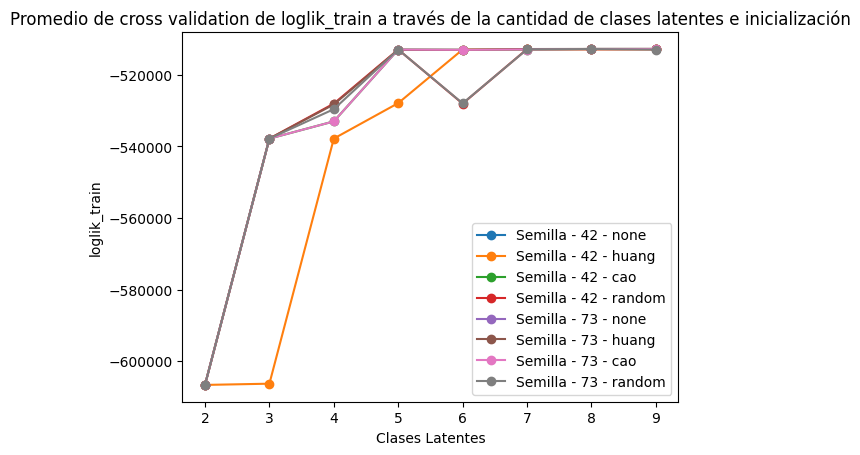

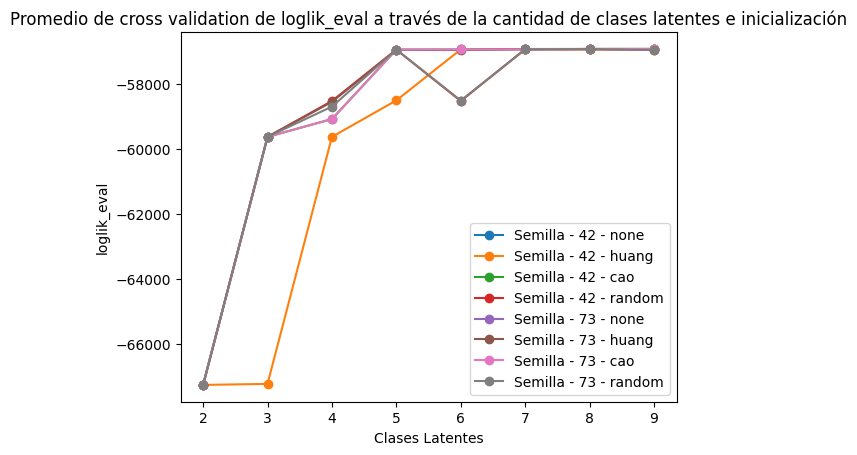

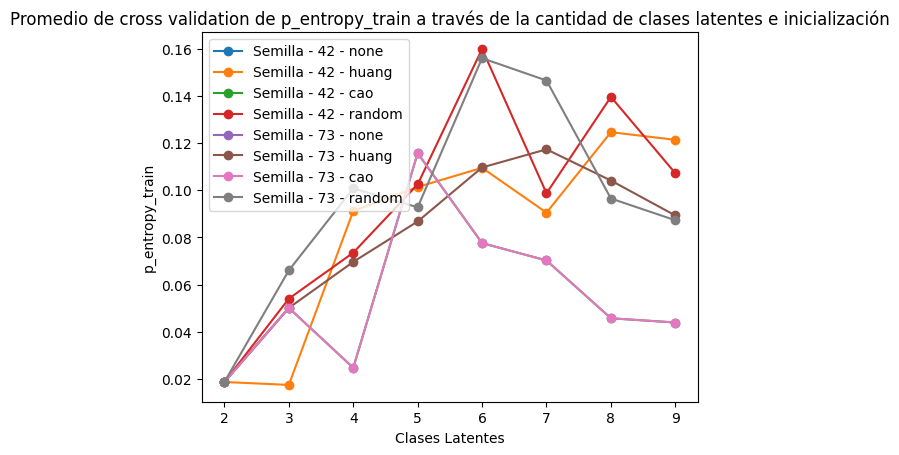

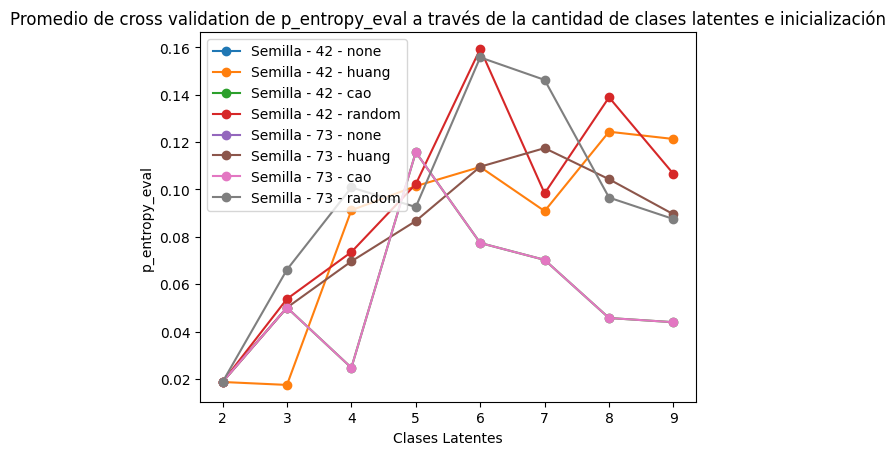

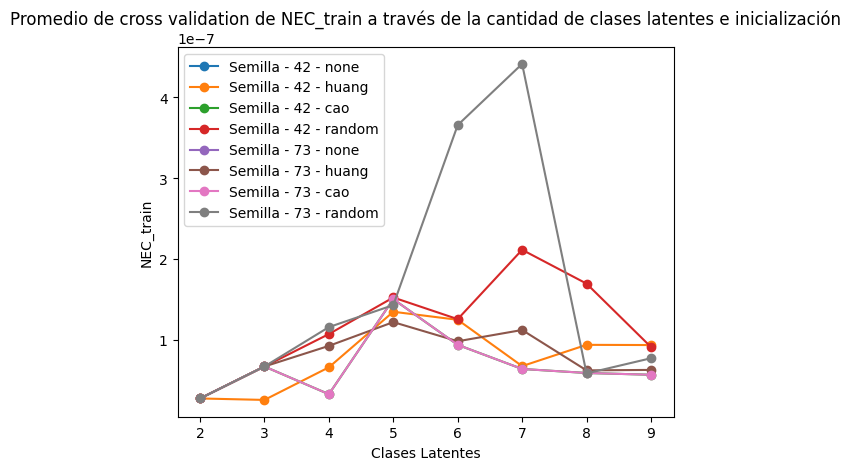

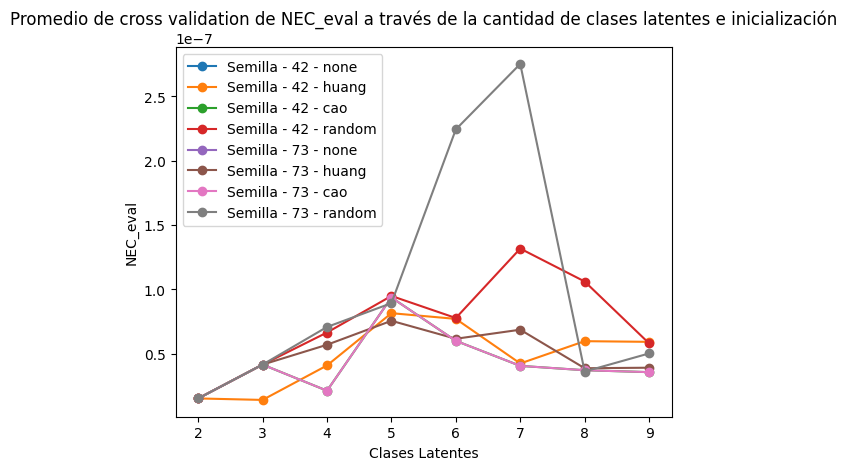

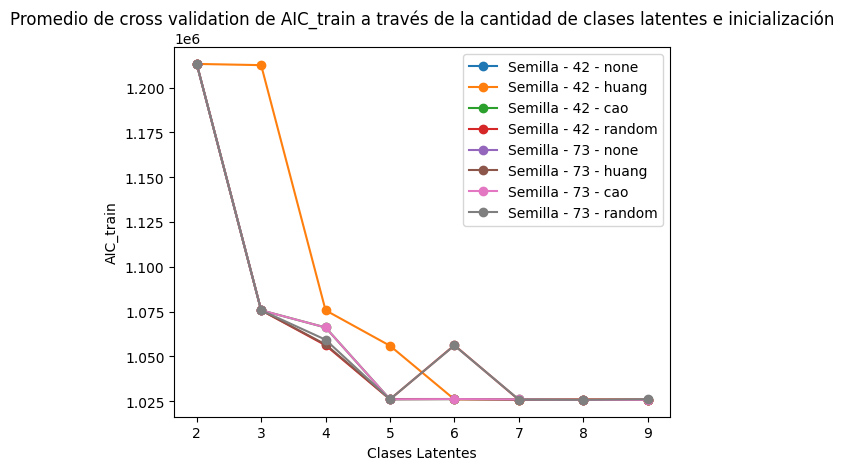

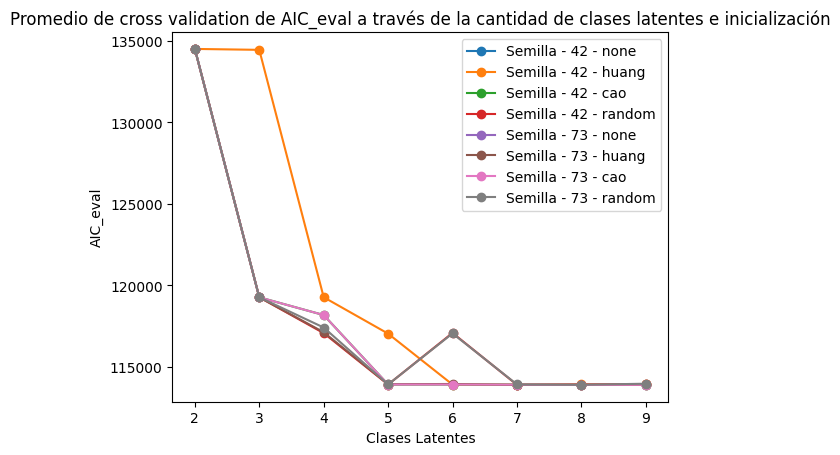

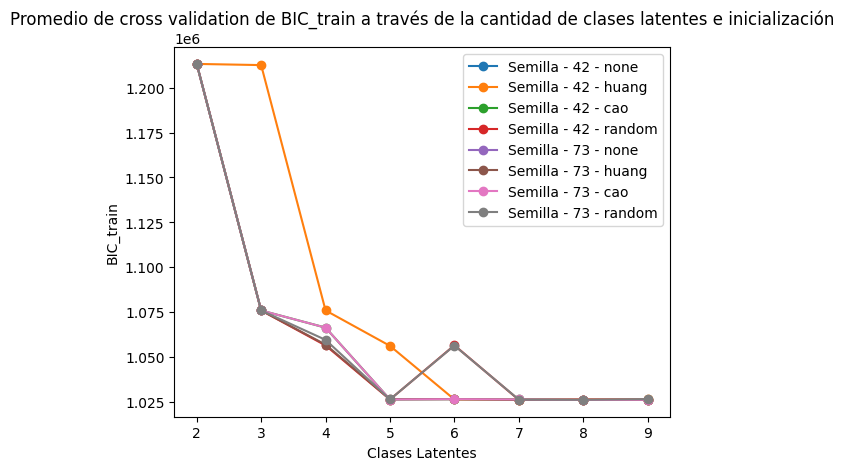

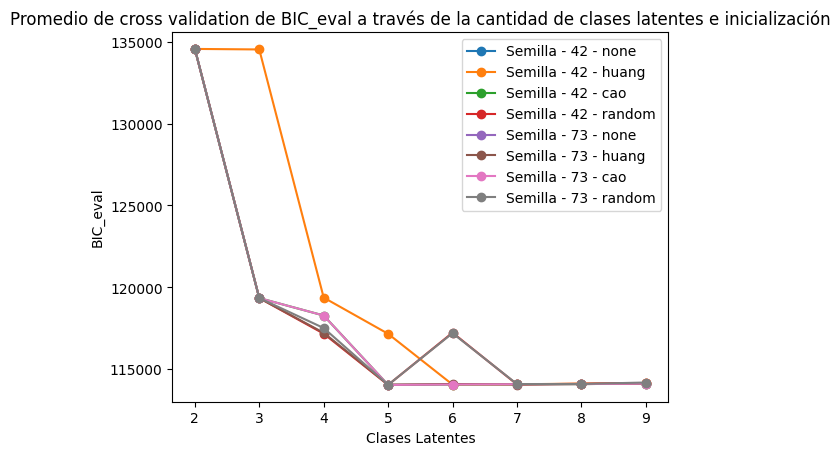

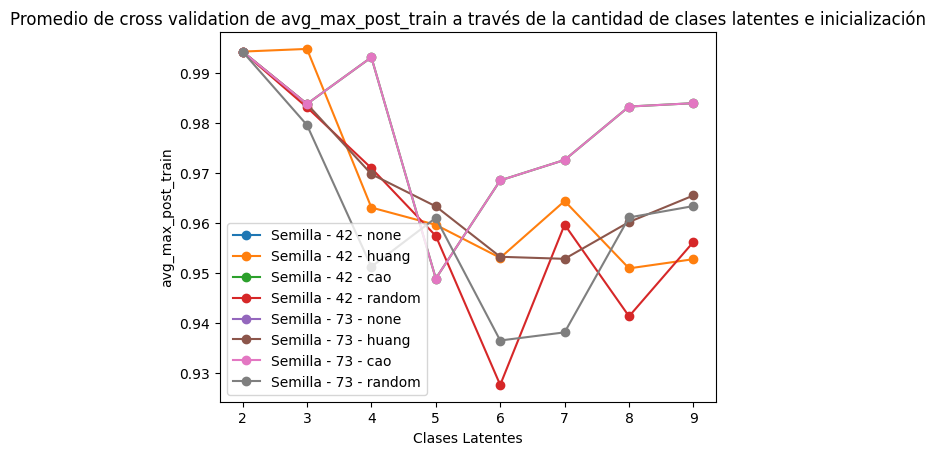

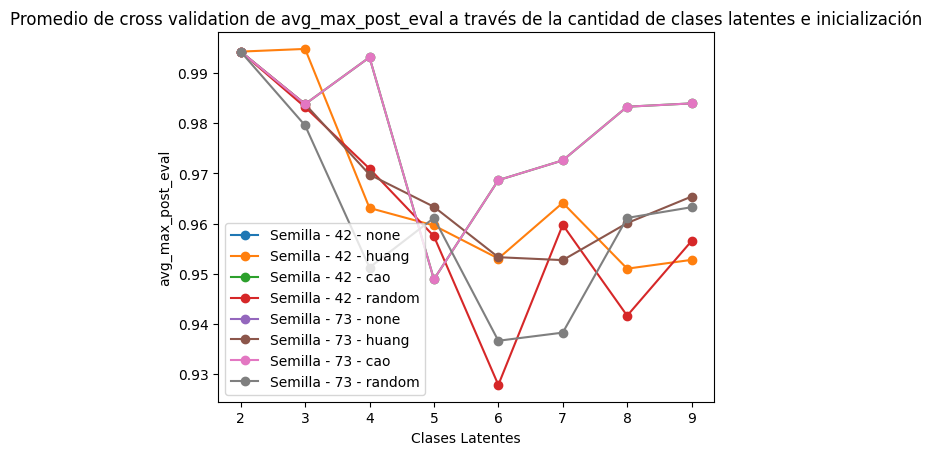

In [223]:

for metric in [
    'loglik_train',
    'loglik_eval',
    'p_entropy_train',
    'p_entropy_eval',
    'NEC_train',
    'NEC_eval',
    'AIC_train',
    'AIC_eval',
    'BIC_train',
    'BIC_eval',
    'avg_max_post_train',
    'avg_max_post_eval'
]:
    graph_metric(
        metric=metric,
        df=df_results_trainning_relation
    )

### Testeo

In [224]:
# ==== FINAL TEST EVALUATION ====
final_results_relation = []

for (seed, num_class, initialization), info in best_models_0.items():
    priors_vals, kmodes_labels_np = None, None
    if initialization != 'no_kmodes':
        # Re-initialize KModes on full training set
        priors_vals, kmodes_labels_np = get_kmodes_init_data(
            X_train_full, n_clusters=num_class, max_iter=1000, device=device
        )
        kmodes_labels = torch.tensor(kmodes_labels_np, device=device)
        # Ensure priors_vals is a numpy 1D array
        priors_vals = np.array(priors_vals.cpu(), dtype=np.float64).flatten()
        # === Ignore those with missing clusters ===
        n_found = len(priors_vals)
        if n_found == num_class:
            components_kmodes = []
            for i in range(num_class):
                X_cluster = X_train_full[kmodes_labels == i]
                component = Categorical(n_categories=n_cat, pseudocount=1e-6).to(device)
                if len(X_cluster) > 0:
                    sample_weight = torch.ones((len(X_cluster), 1), dtype=torch.float32, device=device)
                    component.fit(X_cluster, sample_weight=sample_weight)
                components_kmodes.append(component)
            gmm_final = GeneralMixtureModel(distributions=components_kmodes, priors=priors_vals, max_iter=100000, random_state=seed, inertia=1e-6, frozen=False).to(device)
            gmm_final.fit(X_train_full)
            final_row = calculate_metrics(X_train_full, X_test, gmm_full=gmm_final, L_1=L_1, num_class=num_class, seed=seed)
            final_row["init"] = initialization
            print(f"[TEST EVAL] seed={seed} C={num_class} init={initialization} test_NEC={final_row['NEC_eval']:.4f} test_loglik={final_row['loglik_eval']:.1f}")
            final_results_relation.append(final_row)

    

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\1875290507.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kmodes_labels = torch.tensor(kmodes_labels_np, device=device)


[TEST EVAL] seed=42 C=2 init=huang test_NEC=0.0000 test_loglik=-288362.9
[TEST EVAL] seed=42 C=3 init=huang test_NEC=0.0000 test_loglik=-255723.3
[TEST EVAL] seed=42 C=4 init=huang test_NEC=0.0000 test_loglik=-251718.3
[TEST EVAL] seed=42 C=5 init=huang test_NEC=0.0000 test_loglik=-248348.0
[TEST EVAL] seed=42 C=6 init=huang test_NEC=0.0000 test_loglik=-244432.4
[TEST EVAL] seed=42 C=7 init=huang test_NEC=0.0000 test_loglik=-244433.9
[TEST EVAL] seed=42 C=8 init=huang test_NEC=0.0000 test_loglik=-244350.8
[TEST EVAL] seed=42 C=9 init=huang test_NEC=0.0000 test_loglik=-244441.6
[TEST EVAL] seed=73 C=2 init=huang test_NEC=0.0000 test_loglik=-288362.9
[TEST EVAL] seed=73 C=3 init=huang test_NEC=0.0000 test_loglik=-255723.3
[TEST EVAL] seed=73 C=4 init=huang test_NEC=0.0000 test_loglik=-256153.0
[TEST EVAL] seed=73 C=5 init=huang test_NEC=0.0000 test_loglik=-244556.7
[TEST EVAL] seed=73 C=6 init=huang test_NEC=0.0000 test_loglik=-244397.0
[TEST EVAL] seed=73 C=7 init=huang test_NEC=0.0000 

In [225]:
df_final_relation = pd.DataFrame(final_results_relation)
df_final_relation.to_csv("./results_lca/final_test_results_kmodes_relation.csv", index=False)

In [226]:
df_final_relation

num_class  seed                                              model  \
0           2    42  GeneralMixtureModel(\n  (distributions): Modul...   
1           3    42  GeneralMixtureModel(\n  (distributions): Modul...   
2           4    42  GeneralMixtureModel(\n  (distributions): Modul...   
3           5    42  GeneralMixtureModel(\n  (distributions): Modul...   
4           6    42  GeneralMixtureModel(\n  (distributions): Modul...   
5           7    42  GeneralMixtureModel(\n  (distributions): Modul...   
6           8    42  GeneralMixtureModel(\n  (distributions): Modul...   
7           9    42  GeneralMixtureModel(\n  (distributions): Modul...   
8           2    73  GeneralMixtureModel(\n  (distributions): Modul...   
9           3    73  GeneralMixtureModel(\n  (distributions): Modul...   
10          4    73  GeneralMixtureModel(\n  (distributions): Modul...   
11          5    73  GeneralMixtureModel(\n  (distributions): Modul...   
12          6    73  GeneralMixtureModel(\n  (distributions): Modul...   
13          7    73  GeneralMixtureModel(\n  (distributions): Modul...   
14          8    73  GeneralMixtureModel(\n  (distributions): Modul...   
15          2    42  GeneralMixtureModel(\n  (distributions): Modul...   
16          3    42  GeneralMixtureModel(\n  (distributions): Modul...   
17          4    42  GeneralMixtureModel(\n  (distributions): Modul...   
18          5    42  GeneralMixtureModel(\n  (distributions): Modul...   
19          6    42  GeneralMixtureModel(\n  (distributions): Modul...   
20          7    42  GeneralMixtureModel(\n  (distributions): Modul...   
21          2    73  GeneralMixtureModel(\n  (distributions): Modul...   
22          3    73  GeneralMixtureModel(\n  (distributions): Modul...   
23          4    73  GeneralMixtureModel(\n  (distributions): Modul...   
24          5    73  GeneralMixtureModel(\n  (distributions): Modul...   
25          6    73  GeneralMixtureModel(\n  (distributions): Modul...   
26          7    73  GeneralMixtureModel(\n  (distributions): Modul...   
27          2    42  GeneralMixtureModel(\n  (distributions): Modul...   
28          3    42  GeneralMixtureModel(\n  (distributions): Modul...   
29          4    42  GeneralMixtureModel(\n  (distributions): Modul...   
30          5    42  GeneralMixtureModel(\n  (distributions): Modul...   
31          6    42  GeneralMixtureModel(\n  (distributions): Modul...   
32          7    42  GeneralMixtureModel(\n  (distributions): Modul...   
33          8    42  GeneralMixtureModel(\n  (distributions): Modul...   
34          2    73  GeneralMixtureModel(\n  (distributions): Modul...   
35          3    73  GeneralMixtureModel(\n  (distributions): Modul...   
36          4    73  GeneralMixtureModel(\n  (distributions): Modul...   
37          5    73  GeneralMixtureModel(\n  (distributions): Modul...   
38          7    73  GeneralMixtureModel(\n  (distributions): Modul...   
39          8    73  GeneralMixtureModel(\n  (distributions): Modul...   
40          9    73  GeneralMixtureModel(\n  (distributions): Modul...   

                                         loglik_train  \
0   tensor(-673851.9686, device='cuda:0', dtype=to...   
1   tensor(-597480.2174, device='cuda:0', dtype=to...   
2   tensor(-587906.4546, device='cuda:0', dtype=to...   
3   tensor(-579328.9957, device='cuda:0', dtype=to...   
4   tensor(-570001.8097, device='cuda:0', dtype=to...   
5   tensor(-569909.0045, device='cuda:0', dtype=to...   
6   tensor(-569748.8875, device='cuda:0', dtype=to...   
7   tensor(-569978.3922, device='cuda:0', dtype=to...   
8   tensor(-673851.9686, device='cuda:0', dtype=to...   
9   tensor(-597480.2841, device='cuda:0', dtype=to...   
10  tensor(-598512.4730, device='cuda:0', dtype=to...   
11  tensor(-570284.0869, device='cuda:0', dtype=to...   
12  tensor(-569893.2667, device='cuda:0', dtype=to...   
13  tensor(-569788.8381, device='cuda:0', dtype=to...   
14  tensor(-569734.6656, device='cuda:0'

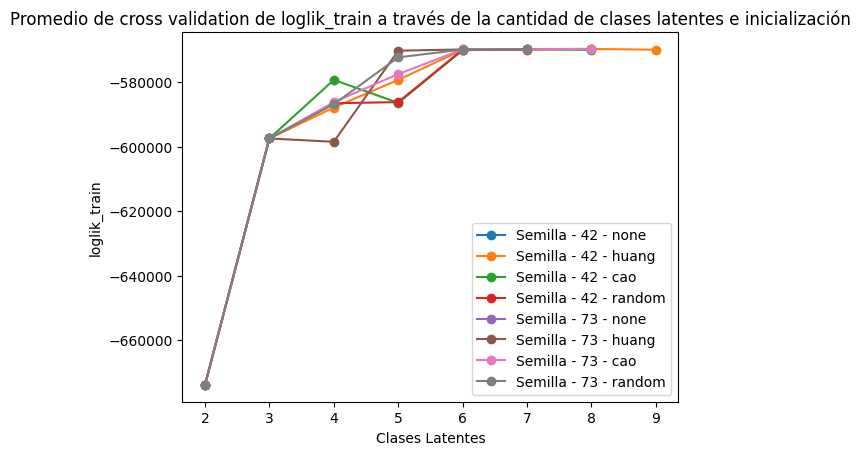

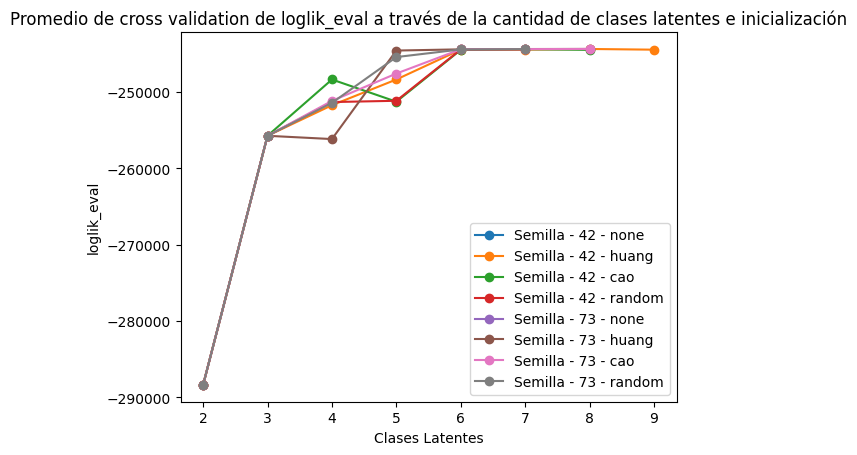

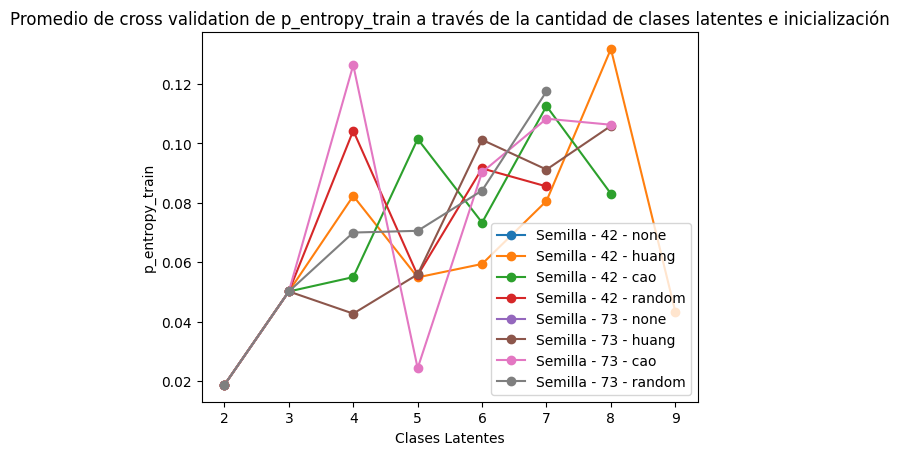

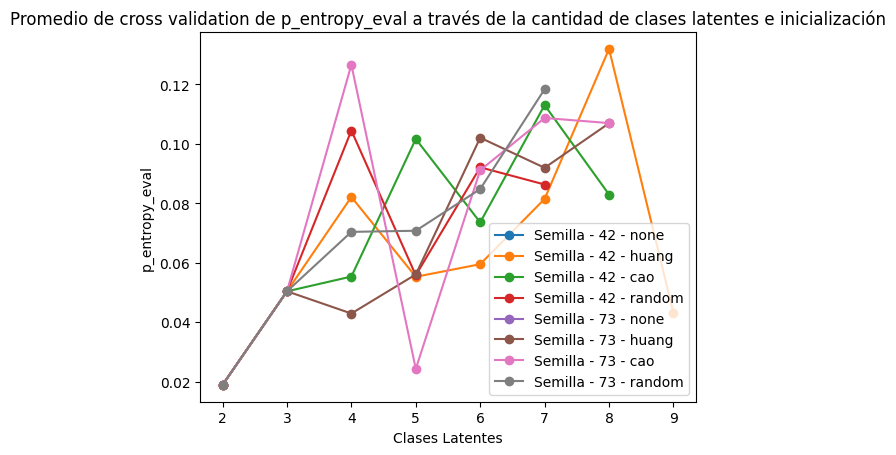

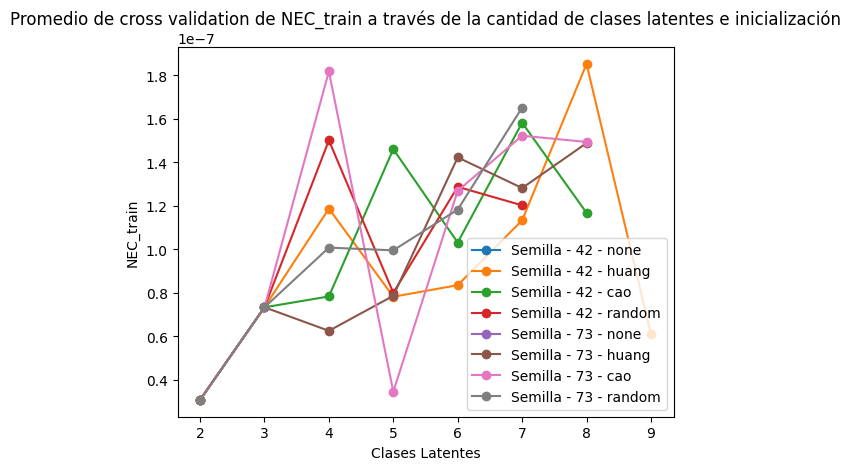

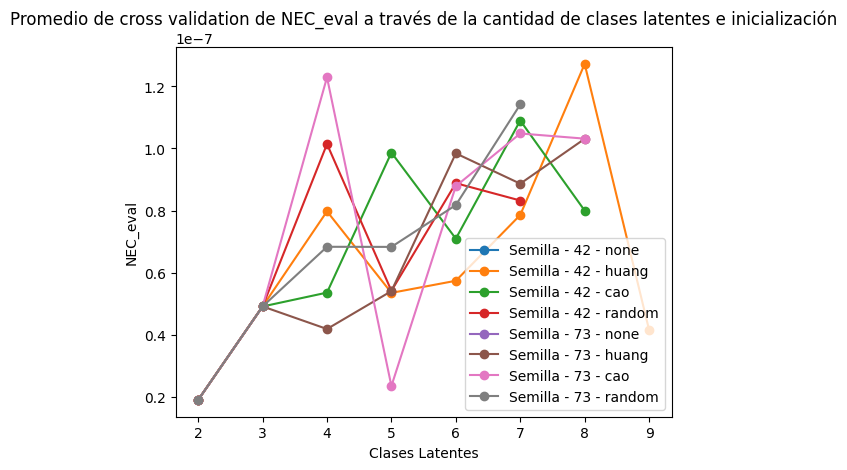

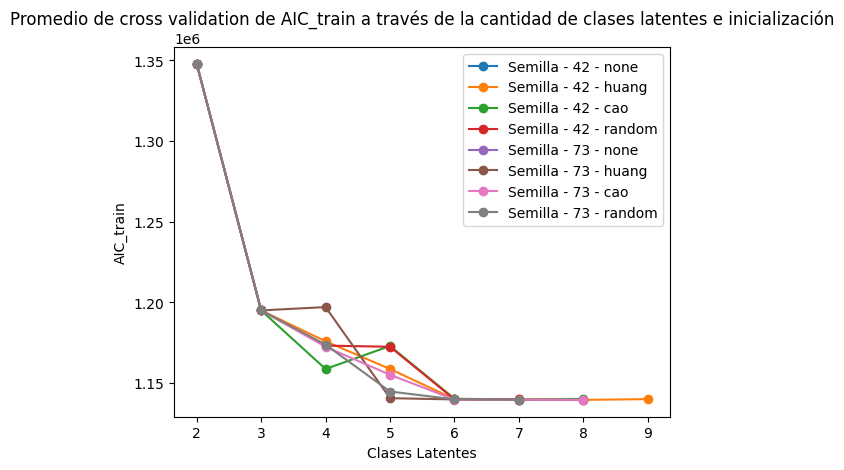

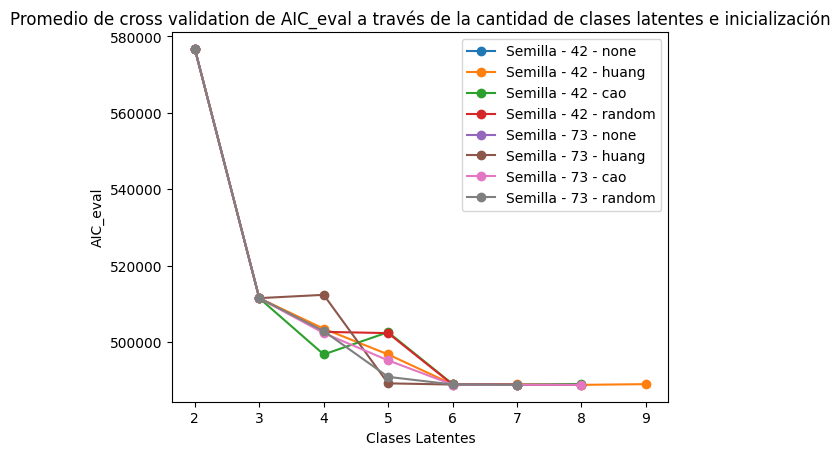

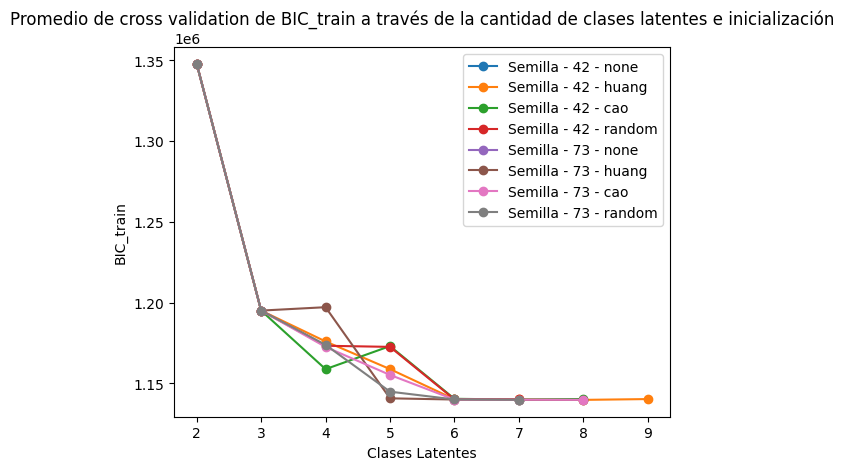

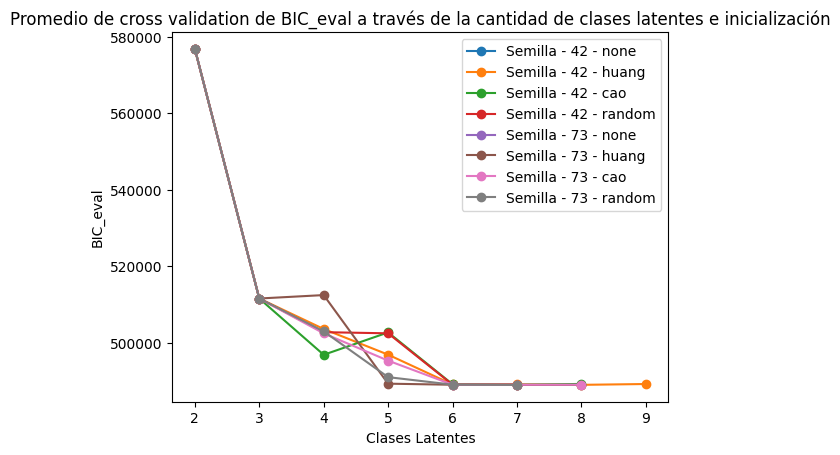

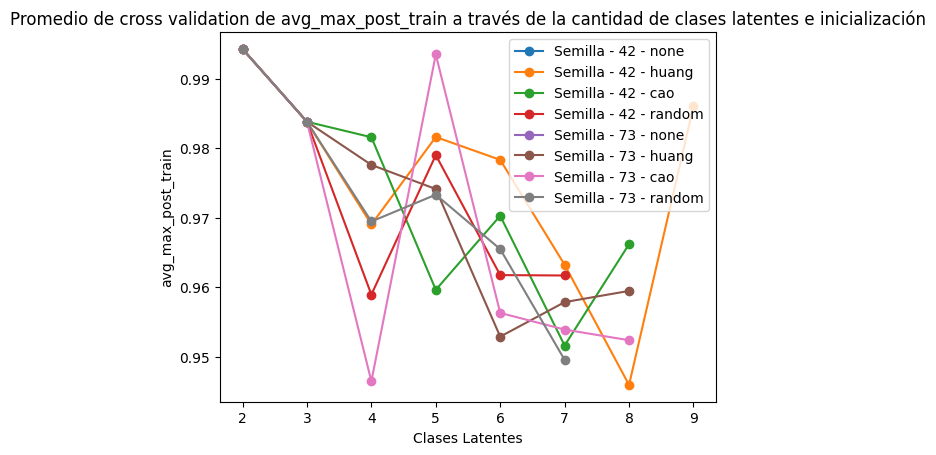

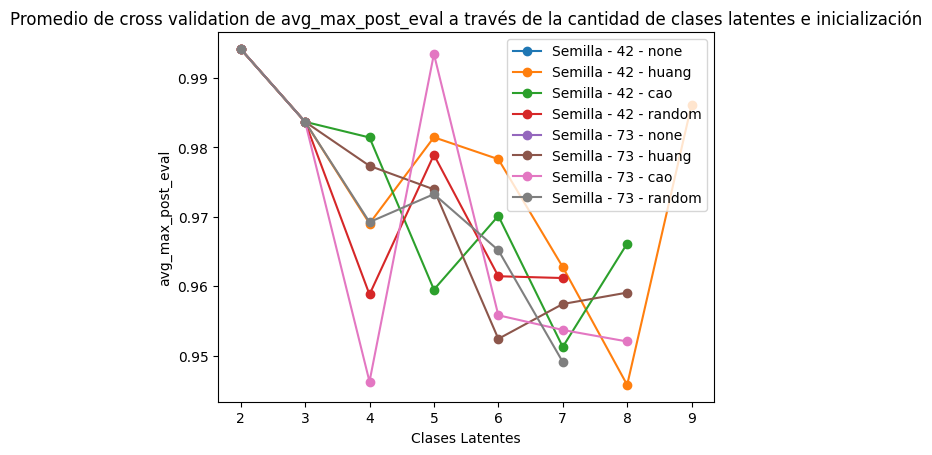

In [227]:
for metric in [
    'loglik_train',
    'loglik_eval',
    'p_entropy_train',
    'p_entropy_eval',
    'NEC_train',
    'NEC_eval',
    'AIC_train',
    'AIC_eval',
    'BIC_train',
    'BIC_eval',
    'avg_max_post_train',
    'avg_max_post_eval'
]:
    graph_metric(
        metric=metric,
        df=df_final_relation
    )

In [228]:
print(df_final_relation.columns)
df_final_relation.head(1)

Index(['num_class', 'seed', 'model', 'loglik_train', 'post_train',
       'labels_train', 'p_entropy_train', 'NEC_train', 'AIC_train',
       'BIC_train', 'avg_max_post_train', 'loglik_eval', 'post_eval',
       'labels_eval', 'p_entropy_eval', 'NEC_eval', 'AIC_eval', 'BIC_eval',
       'avg_max_post_eval', 'class_counts_train', 'class_counts_eval', 'init'],
      dtype='object')


num_class  seed                                              model  \
0          2    42  GeneralMixtureModel(\n  (distributions): Modul...   

                                        loglik_train  \
0  tensor(-673851.9686, device='cuda:0', dtype=to...   

                                          post_train  \
0  [[0.9999993248442683, 6.751557313236687e-07], ...   

                                        labels_train  p_entropy_train  \
0  [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, ...         0.018678   

                                           NEC_train  \
0  tensor(3.0728e-08, device='cuda:0', dtype=torc...   

                                           AIC_train  \
0  tensor(1347715.9373, device='cuda:0', dtype=to...   

                                           BIC_train  ...  \
0  tensor(1347778.6869, device='cuda:0', dtype=to...  ...   

                                           post_eval  \
0  [[0.9999999911682025, 8.831797152714893e-09], ...   

                                         labels_eval p_entropy_eval  \
0  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, ...       0.018929   

                                            NEC_eval  \
0  tensor(1.9056e-08, device='cuda:0', dtype=torc...   

                                            AIC_eval  \
0  tensor(576737.7508, device='cuda:0', dtype=tor...   

                                            BIC_eval avg_max_post_eval  \
0  tensor(576795.4167, device='cuda:0', dtype=tor...          0.994179   

       class_counts_train     class_counts_eval   init  
0  {0: 138815, 1: 118555}  {0: 59271, 1: 51031}  huang  

[1 rows x 22 columns]

In [229]:
df_final_relation.columns

Index(['num_class', 'seed', 'model', 'loglik_train', 'post_train',
       'labels_train', 'p_entropy_train', 'NEC_train', 'AIC_train',
       'BIC_train', 'avg_max_post_train', 'loglik_eval', 'post_eval',
       'labels_eval', 'p_entropy_eval', 'NEC_eval', 'AIC_eval', 'BIC_eval',
       'avg_max_post_eval', 'class_counts_train', 'class_counts_eval', 'init'],
      dtype='object')

In [230]:
df_final_relation[
    ['num_class', 'seed', 'init', 'loglik_train', 'p_entropy_train', 'NEC_train', 'AIC_train',
       'BIC_train', 'avg_max_post_train', 'loglik_eval', 'p_entropy_eval', 'NEC_eval', 'AIC_eval', 'BIC_eval',
       'avg_max_post_eval', ]
].head(1)

num_class  seed   init                                       loglik_train  \
0          2    42  huang  tensor(-673851.9686, device='cuda:0', dtype=to...   

   p_entropy_train                                          NEC_train  \
0         0.018678  tensor(3.0728e-08, device='cuda:0', dtype=torc...   

                                           AIC_train  \
0  tensor(1347715.9373, device='cuda:0', dtype=to...   

                                           BIC_train  avg_max_post_train  \
0  tensor(1347778.6869, device='cuda:0', dtype=to...            0.994248   

                                         loglik_eval  p_entropy_eval  \
0  tensor(-288362.8754, device='cuda:0', dtype=to...        0.018929   

                                            NEC_eval  \
0  tensor(1.9056e-08, device='cuda:0', dtype=torc...   

                                            AIC_eval  \
0  tensor(576737.7508, device='cuda:0', dtype=tor...   

                                            BIC_eval  avg_max_post_eval  
0  tensor(576795.4167, device='cuda:0', dtype=tor...           0.994179

In [231]:
df_final_relation_c = df_final_relation.copy()

In [232]:
for col in ['loglik_train', 'p_entropy_train', 'NEC_train', 'AIC_train',
       'BIC_train', 'avg_max_post_train', 'loglik_eval', 'p_entropy_eval', 'NEC_eval', 'AIC_eval', 'BIC_eval',
       'avg_max_post_eval']:
    df_final_relation[col] = df_final_relation[col].apply(lambda tensor:float(tensor.cpu().item())if isinstance(tensor, torch.Tensor) else tensor)

In [233]:
df_final_relation[
    ['num_class', 'seed', 'init', 'loglik_train', 'p_entropy_train', 'NEC_train', 'AIC_train',
       'BIC_train', 'avg_max_post_train', 'loglik_eval', 'p_entropy_eval', 'NEC_eval', 'AIC_eval', 'BIC_eval',
       'avg_max_post_eval']
    ].to_latex("../documento/plantilla/final_test_results_kmodes_relation.tex", index=False)

In [234]:
# Calificar los modelos
df_scored = normalize_and_score(df_final_relation, scaler='zscore',
                                imbalance_weight=5.0,
                                min_class_threshold=0.1,
                                min_class_penalty=5.0)
df_final_relation['score'] = df_scored['score_norm'].values


In [235]:
top_4_relation = df_final_relation.sort_values(by='score', ascending=False)[:4].reset_index().drop(columns=['index'], axis=1)

In [236]:
top_4_relation

num_class  seed                                              model  \
0          3    42  GeneralMixtureModel(\n  (distributions): Modul...   
1          3    42  GeneralMixtureModel(\n  (distributions): Modul...   
2          3    73  GeneralMixtureModel(\n  (distributions): Modul...   
3          3    42  GeneralMixtureModel(\n  (distributions): Modul...   

    loglik_train                                         post_train  \
0 -597480.159840  [[9.086182701709485e-12, 0.9999987584305889, 1...   
1 -597480.166925  [[1.179388479878781e-06, 0.9999988206024337, 9...   
2 -597480.171670  [[1.352939745256756e-06, 9.086194865113044e-12...   
3 -597480.217381  [[9.086322565096753e-12, 1.492749758345717e-06...   

                                        labels_train  p_entropy_train  \
0  [1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 2, 1, 1, 1, 0, ...         0.050147   
1  [1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 0, 1, 1, 1, 2, ...         0.050147   
2  [2, 1, 2, 1, 2, 1, 1, 2, 0, 1, 0, 2, 2, 2, 1, ...         0.050148   
3  [2, 0, 2, 0, 2, 0, 0, 2, 1, 0, 1, 2, 2, 2, 0, ...         0.050153   

      NEC_train     AIC_train     BIC_train  ...  \
0  7.329106e-08  1.194978e+06  1.195072e+06  ...   
1  7.329105e-08  1.194978e+06  1.195072e+06  ...   
2  7.329236e-08  1.194978e+06  1.195072e+06  ...   
3  7.329987e-08  1.194978e+06  1.195073e+06  ...   

                                         labels_eval  p_entropy_eval  \
0  [1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 1, ...        0.050404   
1  [1, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, ...        0.050404   
2  [2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 2, ...        0.050405   
3  [2, 1, 1, 1, 2, 2, 0, 0, 2, 2, 0, 2, 1, 0, 2, ...        0.050410   

       NEC_eval       AIC_eval       BIC_eval  avg_max_post_eval  \
0  4.912752e-08  511464.522534  511551.021330           0.983683   
1  4.912767e-08  511464.512238  511551.011034           0.983683   
2  4.912858e-08  511464.507306  511551.006102           0.983683   
3  4.913358e-08  511464.556334  511551.055130           0.983683   

                class_counts_train               class_counts_eval    init  \
0  {0: 118534, 1: 69888, 2: 68948}  {0: 51025, 1: 29790, 2: 29487}     cao   
1  {0: 68948, 1: 69888, 2: 118534}  {0: 29487, 1: 29790, 2: 51025}  random   
2  {0: 68948, 1: 118534, 2: 69888}  {0: 29487, 1: 51025, 2: 29790}     cao   
3  {0: 118534, 1: 68948, 2: 69888}  {0: 51025, 1: 29487, 2: 29790}   huang   

      score  
0  2.142182  
1  2.142168  
2  2.142085  
3  2.141595  

[4 rows x 23 columns]

## Interpretando los resultados

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3565344916.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


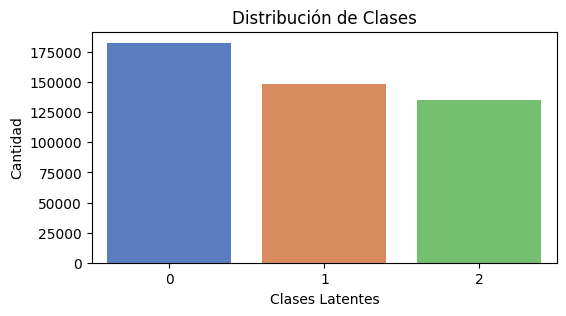

prediction_relation   VIC_EST_CIV  VIC_REL_AGR   AGR_EST_CIV
0                    0   casados(as)  esposos(as)   casados(as)
1                    1  solteros(as)        otros  solteros(as)
2                    2    unidos(as)  conviviente    unidos(as)

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3565344916.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


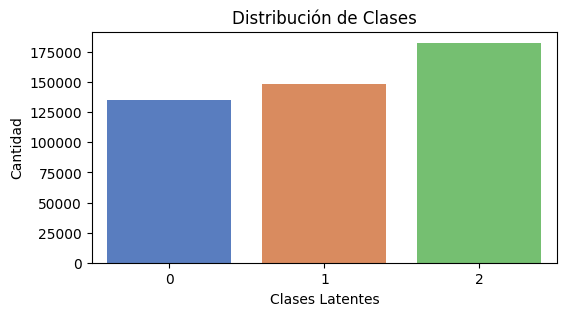

prediction_relation   VIC_EST_CIV  VIC_REL_AGR   AGR_EST_CIV
0                    0    unidos(as)  conviviente    unidos(as)
1                    1  solteros(as)        otros  solteros(as)
2                    2   casados(as)  esposos(as)   casados(as)

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3565344916.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


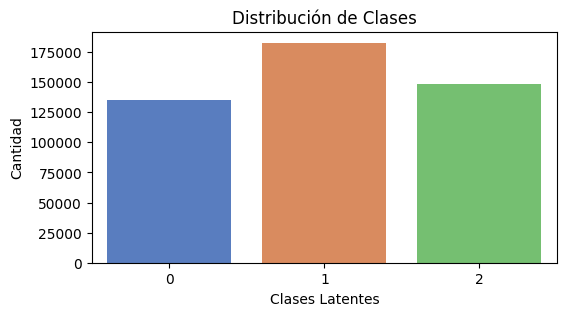

prediction_relation   VIC_EST_CIV  VIC_REL_AGR   AGR_EST_CIV
0                    0    unidos(as)  conviviente    unidos(as)
1                    1   casados(as)  esposos(as)   casados(as)
2                    2  solteros(as)        otros  solteros(as)

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3565344916.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="muted")


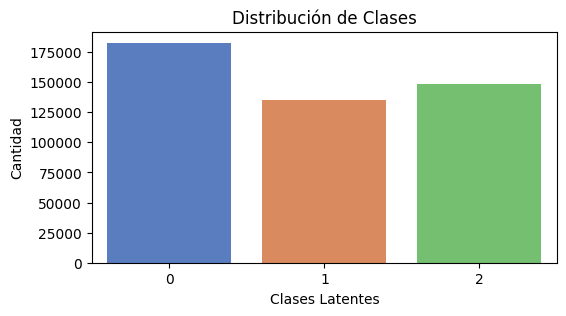

prediction_relation   VIC_EST_CIV  VIC_REL_AGR   AGR_EST_CIV
0                    0   casados(as)  esposos(as)   casados(as)
1                    1    unidos(as)  conviviente    unidos(as)
2                    2  solteros(as)        otros  solteros(as)

In [237]:
for index in range(top_4_relation.shape[0]):
    top = top_4_relation.iloc[index]
    model_p = top['model'] 

    # sanity checks
    assert X.dim() == 2, "input must be 2D (n_samples, n_features)"
    assert (X >= 0).all().item(), "categorical codes must be non-negative"
    

    df['prediction_relation'] = model_p.predict(torch.tensor(df[ENCODED_VARS].to_numpy(), dtype=torch.int32, device=device)).cpu()
    df_complete['prediction_relation'] = model_p.predict(torch.tensor(df_complete[ENCODED_VARS].to_numpy(), dtype=torch.int32, device=device)).cpu()
    # -- class sizes
    unique, counts = np.unique(df['prediction_relation'], return_counts=True)
    plt.figure(figsize=(6,3))
    sns.barplot(x=unique, y=counts, palette="muted")
    plt.title(f"Distribución de Clases")
    plt.xlabel("Clases Latentes")
    plt.ylabel("Cantidad")
    plt.show()
    
    # Count most frequent combination of VARIABLES per prediction
    group_profiles = (
        df_complete.groupby("prediction_relation")[VARIABLES]
        .agg(lambda x: x.value_counts().idxmax())   # most frequent
        .reset_index()
    )
    display(group_profiles)

In [238]:
model = top_4_relation.iloc[0]['model']

In [239]:
# Bootstrap robusto GPU-first para pomegranate GeneralMixtureModel
import os
import time
import pickle
import numpy as np
import torch
from copy import deepcopy
from tqdm import trange
from scipy.special import logsumexp  # solo usado si necesitas numpy fallback

# ---------- Configuración ----------
B = 1000
method = 'parametric'   # 'parametric' o 'nonparametric'
rng = np.random.default_rng(12345)
n, d = X_train_full.shape
S = len(model.distributions)
max_iter_replica = 2000
tol_replica = 1e-6
n_retries = 3
checkpoint_every = 100  # guarda checkpoint cada K réplicas
checkpoint_dir = "./bootstrap_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ---------- Device ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ---------- Helpers de conversión y validación ----------
def to_torch(x, dtype=torch.float32, device=device):
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    return torch.as_tensor(x, dtype=dtype, device=device)

def to_cpu_scalar(x):
    if isinstance(x, torch.Tensor):
        return float(x.detach().cpu().item())
    return float(x)

def safe_detach_cpu_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

# ---------- Preparar modelo y datos en device ----------
# mover modelo al device (pomegranate GeneralMixtureModel soporta .to(device))
try:
    model = model.to(device)
except Exception:
    # si falla, dejamos modelo como está; intentaremos pasar tensores al mismo device
    pass

# asegurar X como tensor en device
X_t = X_train_full.detach().to(device)

# si necesitas X en numpy para NP resampling, crea X_np
X_np = None
if method == 'nonparametric':
    X_np = safe_detach_cpu_np(X_t)

# priors (pi_hat) y copias de componentes (mantener como objetos pomegranate)
raw_priors = getattr(model, 'priors', None)
if raw_priors is None:
    pi_hat = np.full(S, 1.0 / S)
else:
    pi_hat = safe_detach_cpu_np(raw_priors)

components_hat = [deepcopy(c) for c in model.distributions]

# ---------- Almacenamiento (escalares en CPU, vectores grandes opcionales en disco) ----------
EN_boot = np.full(B, np.nan, dtype=float)
E_boot  = np.full(B, np.nan, dtype=float)
# si n grande evita reservar B x n en memoria GPU; lo guardamos en disco por bloques
store_e_per_obs = False  # si True, requerirá mucha memoria; usa con precaución
if method == 'parametric' and store_e_per_obs:
    e_boot = np.full((B, n), np.nan, dtype=float)
else:
    e_boot = None

success = np.zeros(B, dtype=bool)
error_msgs = [None] * B

# ---------- Funciones auxiliares ----------

def make_model_from_mle(pi_init, comps_init, max_iter=2000, tol=1e-6, random_state=None, device=device):
    comps_copy = [deepcopy(c) for c in comps_init]
    m = GeneralMixtureModel(distributions=comps_copy, priors=np.array(pi_init), max_iter=max_iter, tol=tol, random_state=random_state)
    try:
        m = m.to(device)
    except Exception:
        pass
    return m

def get_posteriors_from_model_tensor(m, X_t):
    """
    Devuelve tensor (n, S) con posterioris en el mismo device que X_t.
    Intenta usar m.predict_proba si devuelve torch.Tensor; si no, usa internals y torch ops.
    """
    # intentar predict_proba (puede devolver numpy or torch)
    if hasattr(m, 'predict_proba'):
        a = m.predict_proba(X_t)
        if isinstance(a, torch.Tensor):
            return a.to(device=X_t.device, dtype=torch.float32)
        else:
            return torch.as_tensor(a, device=X_t.device, dtype=torch.float32)

    # fallback a _emission_matrix que en pomegranate devuelve tensor si X_t es tensor
    if hasattr(m, '_emission_matrix'):
        logp = m._emission_matrix(X_t)  # esperado tensor (n, S) en device
        if not isinstance(logp, torch.Tensor):
            logp = torch.as_tensor(logp, device=X_t.device, dtype=torch.float32)
        lse = torch.logsumexp(logp, dim=1, keepdim=True)
        a = torch.exp(logp - lse)
        return a

    raise RuntimeError("No se puede extraer posterioris: adapta según tu versión de pomegranate.")

def safe_fit_with_retries(factory, Xb_t, n_retries=3, increase_smooth=False):
    last_err = None
    for attempt in range(n_retries):
        m = factory()
        try:
            try:
                m = m.to(device)
            except Exception:
                pass
            # fit acepta tensors; si no, intentará convertir
            m.fit(Xb_t)
            # comprobar log_probability si hay (devuelve tensor o scalar)
            if hasattr(m, 'log_probability'):
                lp = m.log_probability(Xb_t)
                # convertir a numpy/torch y comprobar finitos
                if isinstance(lp, torch.Tensor):
                    lp_np = lp.detach().cpu().numpy()
                else:
                    lp_np = np.asarray(lp)
                if np.any(np.isnan(lp_np)) or not np.isfinite(lp_np).all():
                    raise RuntimeError("log_probability contiene NaN/Inf")
            return m, None
        except Exception as e:
            last_err = e
            # intento heurístico de smoothing: modificar pseudocounts si existen
            if increase_smooth:
                try:
                    comps = factory().__dict__.get('distributions', [])
                    for comp in comps:
                        if hasattr(comp, 'pseudocount'):
                            comp.pseudocount = max(getattr(comp, 'pseudocount', 0), 1e-3)
                except Exception:
                    pass
            # seguir con siguiente intento
    return None, last_err

# ---------- Loop bootstrap GPU-first ----------
start_time = time.time()
for b in trange(B):
    try:
        # 1) generar réplica como tensor en device
        if method == 'parametric':
            sampled = model.sample(n)  # normalmente devuelve torch.Tensor en device
            Xb_t = sampled if isinstance(sampled, torch.Tensor) else torch.as_tensor(sampled, device=device)
        else:
            idx = rng.integers(0, n, size=n)
            Xb_np = X_np[idx]
            Xb_t = torch.as_tensor(Xb_np, device=device)

        # 2) ajustar con reintentos (inicializar desde MLE)
        model_b, err = safe_fit_with_retries(lambda: make_model_from_mle(pi_hat, components_hat, max_iter=max_iter_replica, tol=tol_replica), Xb_t, n_retries=n_retries, increase_smooth=True)
        if model_b is None:
            success[b] = False
            error_msgs[b] = str(err)
            continue

        # 3) obtener posterioris en tensor
        a_b_t = get_posteriors_from_model_tensor(model_b, Xb_t)   # (n, S) tensor
        if a_b_t.ndim != 2 or a_b_t.shape[1] != S:
            raise RuntimeError(f"Posterioris con forma inesperada: {tuple(a_b_t.shape)}")

        # 4) métricas (torch)
        hi_b_t = -(a_b_t * torch.log(a_b_t + 1e-16)).sum(dim=1)    # (n,)
        EN_b_t = hi_b_t.sum()                                      # tensor scalar
        E_b_val = 1.0 - (EN_b_t / (n * torch.log(torch.tensor(float(S), device=device))))
        # guardar escalares en CPU numpy
        EN_boot[b] = to_cpu_scalar(EN_b_t)
        E_boot[b]  = to_cpu_scalar(E_b_val)

        if method == 'parametric' and store_e_per_obs:
            e_b_t = 1.0 - torch.max(a_b_t, dim=1).values
            e_boot[b, :] = safe_detach_cpu_np(e_b_t)

        success[b] = True

    except Exception as ex:
        success[b] = False
        error_msgs[b] = str(ex)

    # checkpointing cada K réplicas
    if (b + 1) % checkpoint_every == 0:
        ck = {
            'b': b + 1,
            'EN_boot': EN_boot,
            'E_boot': E_boot,
            'e_boot': e_boot,
            'success': success,
            'error_msgs': error_msgs,
            'elapsed_seconds': time.time() - start_time
        }
        with open(os.path.join(checkpoint_dir, f'bootstrap_ck_b{b+1}.pkl'), 'wb') as f:
            pickle.dump(ck, f)

# ---------- Resumen y protección contra NaNs ----------
def summarize_scalar_boot_safe(arr_boot, orig, alpha=0.05):
    valid = arr_boot[~np.isnan(arr_boot)]
    n_valid = valid.size
    if n_valid == 0:
        return {'mean': np.nan, 'bias': np.nan, 'se': np.nan, 'ci': (np.nan, np.nan), 'n_valid': 0}
    mean_b = float(np.mean(valid))
    bias = float(mean_b - orig)
    se = float(np.std(valid, ddof=1)) if n_valid > 1 else np.nan
    lower, upper = np.percentile(valid, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': mean_b, 'bias': bias, 'se': se, 'ci': (float(lower), float(upper)), 'n_valid': int(n_valid)}

def summarize_vector_boot_safe(arr_boot_2d, orig_vec, alpha=0.05):
    mean_b = np.nanmean(arr_boot_2d, axis=0)
    bias = mean_b - orig_vec
    se = np.nanstd(arr_boot_2d, axis=0, ddof=1)
    lower = np.nanpercentile(arr_boot_2d, 100*alpha/2, axis=0)
    upper = np.nanpercentile(arr_boot_2d, 100*(1-alpha/2), axis=0)
    allnan = np.all(np.isnan(arr_boot_2d), axis=0)
    lower[allnan] = np.nan
    upper[allnan] = np.nan
    return {'mean': mean_b, 'bias': bias, 'se': se, 'ci': (lower, upper), 'n_valid_per_obs': np.sum(~np.isnan(arr_boot_2d), axis=0)}

# calcular estadísticas originales (a_hat, e_hat, EN_hat, E_hat) en device y mover escalars a CPU
a_hat_t = get_posteriors_from_model_tensor(model, X_t)
max_post_t = torch.max(a_hat_t, dim=1).values
e_hat = safe_detach_cpu_np(1.0 - max_post_t)
hi_t = -(a_hat_t * torch.log(a_hat_t + 1e-16)).sum(dim=1)
EN_hat = to_cpu_scalar(hi_t.sum())
E_hat = 1.0 - EN_hat / (n * np.log(S))

summary_EN = summarize_scalar_boot_safe(EN_boot, EN_hat)
summary_E  = summarize_scalar_boot_safe(E_boot, E_hat)
summary_e = None
if method == 'parametric' and store_e_per_obs:
    summary_e = summarize_vector_boot_safe(e_boot, e_hat)

# reporte final y checkpoint final
n_valid = int(success.sum())
print(f"Bootstrap finished: {n_valid}/{B} valid replicas; {B-n_valid} failed.")
if n_valid < max(10, B // 10):
    print("Advertencia: pocas réplicas válidas. Revisa error_msgs para las primeras fallidas:")
    failed_idx = np.where(~success)[0]
    print([error_msgs[i] for i in failed_idx[:10]])

with open(os.path.join(checkpoint_dir, 'bootstrap_final_summary.pkl'), 'wb') as f:
    pickle.dump({'EN_boot': EN_boot, 'E_boot': E_boot, 'e_boot': e_boot, 'success': success, 'error_msgs': error_msgs, 'summary_EN': summary_EN, 'summary_E': summary_E, 'summary_e': summary_e, 'EN_hat': EN_hat, 'E_hat': E_hat, 'e_hat': e_hat}, f)

print("Summary E:", summary_E)


Using device: cuda


100%|██████████| 1000/1000 [02:09<00:00,  7.70it/s]

Bootstrap finished: 1000/1000 valid replicas; 0 failed.
Summary E: {'mean': 0.9558282101154327, 'bias': 0.001473971807604224, 'se': 0.0003303693731448477, 'ci': (0.95517907589674, 0.9564875438809395), 'n_valid': 1000}


In [240]:
import joblib

for index in range(top_4_relation.shape[0]):
    top = top_4_relation.iloc[index]
    model_p = top['model'] 
    joblib.dump(model_p, f"./models/gmm_model_no_kmodes_relation_top{index}.pkl")

In [241]:
import pickle as pkl
model_relation = pkl.load(open("./models/gmm_model_no_kmodes_relation_top0.pkl", "rb"))
df['prediction_relation'] = model_relation.predict(torch.tensor(df[ENCODED_VARS_RELATION].to_numpy(), dtype=torch.int32)).cpu()

df['prediction_relation_probs'] = np.nan
df['prediction_relation_probs'] = model_relation.predict_proba(torch.tensor(df[ENCODED_VARS_RELATION].to_numpy(), dtype=torch.int32)).cpu()
posteriors = get_posteriors_from_model(model_relation, df_complete, ENCODED_VARS_RELATION, device=None)  # o device='cuda:0' si tu model acepta

probs_dict, preval = class_probability_matrix_from_posteriors(df_complete, posteriors, ENCODED_VARS_RELATION)

print(preval)
for col in ENCODED_VARS_RELATION:
    print(f"Probabilidades condicionales para {col}:")
    print(probs_dict[col].set_index(label_encoders[col.split('_ENC')[0]].inverse_transform(probs_dict[col].index)).round(3))

for var, table in probs_dict.items():
    table.index = label_encoders[var.split('_ENC')[0]].inverse_transform(table.index)
    latex = table.to_latex(float_format="%.3f")
    with open(f"../documento/plantilla/results_lca/prob_matrix_relation_{var}.tex", "w", encoding="utf8") as f:
        f.write(latex)


Class_1    0.452473
Class_2    0.281678
Class_3    0.265849
dtype: float64
Probabilidades condicionales para VIC_EST_CIV_ENC:
              Class_1  Class_2  Class_3
casados(as)     0.994    0.181    0.006
otro            0.000    0.100    0.000
solteros(as)    0.003    0.621    0.000
unidos(as)      0.003    0.097    0.994
Probabilidades condicionales para VIC_REL_AGR_ENC:
             Class_1  Class_2  Class_3
conviviente    0.015    0.244    0.851
esposos(as)    0.903    0.016    0.021
ex-conyuges    0.021    0.256    0.085
otros          0.060    0.484    0.043
Probabilidades condicionales para AGR_EST_CIV_ENC:
              Class_1  Class_2  Class_3
casados(as)       1.0    0.166    0.018
otro              0.0    0.097    0.000
solteros(as)      0.0    0.612    0.000
unidos(as)        0.0    0.125    0.982


In [242]:
# Definición de pesos basados en severidad percibida (debe ser justificado teóricamente)
weights = {
    'VIOLENCIA_SEXUAL': 3.0,
    'VIOLENCIA_FISICA': 2.0,
    'VIOLENCIA_PSICOLOGICA': 1.5,
    'VIOLENCIA_PATRIMONIAL': 1.5,
    'OTROS_AGRESORES': 1.0,
    'OTRAS_VICTIMAS': 1.0
}

# Cálculo de la Variable Dependiente Y (Severidad Ponderada)
df['Y_severidad'] = (
    df['VIOLENCIA_SEXUAL_ENC'] * weights['VIOLENCIA_SEXUAL'] +
    df['VIOLENCIA_FISICA_ENC'] * weights['VIOLENCIA_FISICA'] +
    df['VIOLENCIA_PSICOLOGICA_ENC'] * weights['VIOLENCIA_PSICOLOGICA'] +
    df['VIOLENCIA_PATRIMONIAL_ENC'] * weights['VIOLENCIA_PATRIMONIAL'] +
    df['OTROS_AGRESORES_ENC'] * weights['OTROS_AGRESORES'] +
    df['VIC_OTRAS_VICTIMAS_ENC'] * weights['OTRAS_VICTIMAS']
)

# La columna df['Y_severidad'] es ahora su variable dependiente Y.

In [243]:
df['Y_severidad']

0         5.5
1         7.0
2         7.0
3         5.0
4         5.5
         ... 
466017    3.5
466018    3.5
466019    1.5
466020    1.5
466021    1.5
Name: Y_severidad, Length: 466022, dtype: float64

In [244]:
df.columns[57:101]

Index(['ARTICULOVCM', 'ESTACIONES_DE_BOMBEROS_POR_DEPARTAMENTO',
       'CANTIDAD_PNC_POR_DEPARTAMENTO',
       'CANTIDAD_ORGANISMO_JUDICIAL_POR_DEPARTAMENTO',
       'CANTIDAD_IDDP_POR_DEPARTAMENTO', 'CANTIDAD_SALAS_MIXTAS',
       'CANTIDAD_TRIBUNALES_DE_SENTENCIA',
       'CANTIDAD_JUZGADOS_PRIMERA_INSTANCIA_PENAL',
       'CANTIDAD_JUZGADOS_PRIMERA_INSTANCIA_PENAL_NARCOACTIVIDAD_DELITOS_AMBIENTE',
       'CANTIDAD_JUZGADOS_ADOLESCENTES_Y_NINEZ', 'CANTIDAD_JUZGADOS_EJECUCION',
       'CANTIDAD_JUZGADOS_PAZ_PENAL_COMUNITARIOS',
       'CANTIDAD_JUZGADOS_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO',
       'CANTIDAD_TRIBUNALES_SENTENCIA_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO',
       'CANTIDAD_JUZGADOS_TRIBUNALES_MAYOR_RIESGO',
       'CANTIDAD_FISCALIAS_REGIONALES', 'CANTIDAD_FISCALIAS_DISTRITALES',
       'CANTIDAD_FISCALIAS_MUNICIPALES', 'CANTIDAD_AGENCIAS_FISCALES',
       'CANTIDAD_COORDINADORA_DEPARTAMENTAL',
       'CANTIDAD_COORDINADORA_MUNICIPAL', 'CANTIDAD_SECCIONES_ESPECIALES',
       'CANT

## Indicador de apoyo institucional

### Selección de variables

In [245]:
VARIABLES_APOYO_INSTITUCIONAL = [
    'HEC_DEPTO',
    'CANTIDAD_COMISARIAS',
    'CANTIDAD_ESTACIONES',
    'CANTIDAD_SUBESTACIONES',
    
    'CANTIDAD_JUZGADOS_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO',
    'CANTIDAD_TRIBUNALES_SENTENCIA_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO',
    
    'CANTIDAD_FISCALIAS_MUNICIPALES',
    'CANTIDAD_AGENCIAS_FISCALES',
    
    'CANTIDAD_CENTRO_ATENCION_PERMANENTE',
    'CANTIDAD_CENTRO_SALUD',
    'CANTIDAD_PUESTO_SALUD',
    'CANTIDAD_HOSPITAL'
]

### Estandarización por tasa

In [246]:
df_deptos = df[VARIABLES_APOYO_INSTITUCIONAL].drop_duplicates().reset_index().drop([1,2],axis=0).drop(columns=['index'],axis=1).reset_index().drop(columns=['index'],axis=1)

In [247]:
df_deptos

HEC_DEPTO  CANTIDAD_COMISARIAS  CANTIDAD_ESTACIONES  \
0        guatemala                 96.0                592.0   
1   quetzaltenango                 23.0                161.0   
2    huehuetenango                 33.0                231.0   
3           jalapa                  6.0                 24.0   
4        escuintla                 13.0                 65.0   
5      el progreso                 17.0                 51.0   
6     sacatepequez                 16.0                 48.0   
7    chimaltenango                 15.0                 60.0   
8       santa rosa                 14.0                 56.0   
9           solola                 18.0                 72.0   
10     totonicapan                  7.0                 21.0   
11   suchitepequez                 21.0                 63.0   
12      retalhuleu                  8.0                 24.0   
13      san marcos                 29.0                145.0   
14    alta verapaz                 17.0                 85.0   
15          quiche                 21.0                168.0   
16    baja verapaz                  8.0                 16.0   
17           peten                  5.0                 30.0   
18          izabal                  5.0                 25.0   
19          zacapa                 25.0                 75.0   
20      chiquimula                 10.0                 40.0   
21         jutiapa                  6.0                 36.0   

    CANTIDAD_SUBESTACIONES  \
0                   2064.0   
1                    644.0   
2                   1155.0   
3                     42.0   
4                    260.0   
5                    187.0   
6                    272.0   
7                    225.0   
8                    266.0   
9                    414.0   
10                    70.0   
11                   462.0   
12                   104.0   
13                   783.0   
14                   306.0   
15                   483.0   
16                    64.0   
17                    90.0   
18                    70.0   
19                   275.0   
20                   140.0   
21                   132.0   

    CANTIDAD_JUZGADOS_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO  \
0                                                48.0    
1                                                23.0    
2                                                33.0    
3                                                 0.0    
4                                                13.0    
5                                                 0.0    
6                                                 0.0    
7                                                15.0    
8                                                 0.0    
9                                                18.0    
10                                                0.0    
11                                               21.0    
12                                                0.0    
13                                               29.0    
14                                               17.0    
15                                               21.0    
16                                                0.0    
17                                                5.0    
18                                                5.0    
19                                                0.0    
20                                               10.0    
21                                                6.0    

    CANTIDAD_TRIBUNALES_SENTENCIA_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO  \
0                                                32.0                
1                                                23.0                
2                                                33.0                
3                                                 0.0                
4                                                13.0                
5                                                 0.0                
6                   

In [248]:
import pandas as pd

# Paso 1: Crear DataFrame de población
poblacion_data = [
    ('guatemala', 3557909),
    ('sacatepequez', 396167),
    ('el progreso', 194388),
    ('chimaltenango', 746366),
    ('escuintla', 802479),
    ('santa rosa', 446436),
    ('solola', 474240),
    ('totonicapan', 493864),
    ('quetzaltenango', 909879),
    ('suchitepequez', 612438),
    ('retalhuleu', 376398),
    ('san marcos', 1189274),
    ('huehuetenango', 1399367),
    ('quiche', 1081964),
    ('baja verapaz', 333537),
    ('alta verapaz', 1355134),
    ('peten', 622409),
    ('izabal', 446461),
    ('zacapa', 270473),
    ('chiquimula', 447544),
    ('jalapa', 400905),
    ('jutiapa', 552114),
]

df_poblacion = pd.DataFrame(poblacion_data, columns=['HEC_DEPTO', 'POBLACION'])

# Paso 2: Unir con df_deptos
df_merged = df_deptos.merge(df_poblacion, on='HEC_DEPTO', how='left')

# Paso 3: Calcular tasas por cada 100,000 habitantes
for col in VARIABLES_APOYO_INSTITUCIONAL[1:]:  # Excluye 'HEC_DEPTO'
    tasa_col = f'{col}_TASA'
    df_merged[tasa_col] = df_merged[col] / df_merged['POBLACION']

# Resultado
df_tasas = df_merged[['HEC_DEPTO'] + [f'{col}_TASA' for col in VARIABLES_APOYO_INSTITUCIONAL[1:]]]


In [249]:
df = df.merge(df_tasas, on='HEC_DEPTO', how='left', suffixes=('', '_TASA'))

In [250]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- Asumiendo que df_tasas ya contiene las tasas calculadas ---
# VARIABLES_APOYO_INSTITUCIONAL se asume que es la lista de columnas originales
# Ejemplo de cómo se vería la lista de columnas de tasas
VARIABLES_TASA = [col for col in df_tasas.columns if col.endswith('_TASA')]


## 1. Normalización Min-Max (Escala [0, 1])

# Inicializar el objeto MinMaxScaler
scaler_end = MinMaxScaler()

# Crear un DataFrame para los scores normalizados
df_scores = df_tasas[['HEC_DEPTO']].copy()

# Aplicar el normalizador a todas las columnas de tasas
# Nota: La transformación requiere que los datos sean numéricos y no contengan NaN
df_tasas_numericas = df_tasas[VARIABLES_TASA].fillna(0) # Reemplazar NaNs por 0 temporalmente si existen

# Ajustar y transformar los datos
scores_normalizados = scaler_end.fit_transform(df_tasas_numericas)

# Asignar los resultados de vuelta al DataFrame de scores
df_scores[VARIABLES_TASA] = scores_normalizados

# Opcional: Renombrar las columnas a un prefijo más claro (ej: _SCORE)
df_scores.columns = ['HEC_DEPTO'] + [col.replace('_TASA', '_SCORE') for col in VARIABLES_TASA]


## 2. Agregación del Indicador de Apoyo Institucional (Promedio Simple)

# Seleccionar solo las columnas de scores normalizados
score_cols = [col for col in df_scores.columns if col.endswith('_SCORE')]

# Calcular el promedio simple para generar el Indicador I_Apoyo
df_scores['I_APOYO_INSTITUCIONAL'] = df_scores[score_cols].mean(axis=1)


## 3. Resultado Final

print("\n--- Scores Normalizados [0, 1] ---")
print(df_scores[['HEC_DEPTO'] + score_cols].head())

print("\n--- Indicador I_APOYO_INSTITUCIONAL Final ---")
print(df_scores[['HEC_DEPTO', 'I_APOYO_INSTITUCIONAL']].sort_values(
    by='I_APOYO_INSTITUCIONAL', ascending=False
).head())


--- Scores Normalizados [0, 1] ---
        HEC_DEPTO  CANTIDAD_COMISARIAS_SCORE  CANTIDAD_ESTACIONES_SCORE  \
0       guatemala                   0.224519                   0.527614   
1  quetzaltenango                   0.204328                   0.572580   
2   huehuetenango                   0.184233                   0.522012   
3          jalapa                   0.082145                   0.073871   
4       escuintla                   0.096762                   0.163893   

   CANTIDAD_SUBESTACIONES_SCORE  \
0                      0.521235   
1                      0.661229   
2                      0.790165   
3                      0.000000   
4                      0.240394   

   CANTIDAD_JUZGADOS_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO_SCORE  \
0                                           0.355445          
1                                           0.665993          
2                                           0.621309          
3                                           0.0000

In [251]:
import pickle
pickle.dump(df_scores, open("./models/indicador_apoyo_institucional.pkl", "wb"))

In [252]:
df_scores['I_APOYO_INSTITUCIONAL']

0     0.218710
1     0.382664
2     0.465739
3     0.075066
4     0.239228
5     0.513333
6     0.199763
7     0.276308
8     0.306565
9     0.560717
10    0.086653
11    0.431087
12    0.229273
13    0.418810
14    0.183163
15    0.316442
16    0.267337
17    0.177555
18    0.186236
19    0.634983
20    0.245914
21    0.141350
Name: I_APOYO_INSTITUCIONAL, dtype: float64

### Cálculo de incertidumbre 

In [253]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Supuestos: df_tasas ya existe y contiene las columnas de tasas ---
# VARIABLES_TASA es la lista de columnas de tasas (ej. 'CANTIDAD_COMISARIAS_TASA', etc.)

N_BOOTSTRAP = 1000  # Número de iteraciones de remuestreo (típicamente 1000 o más)
ALPHA = 0.05        # Nivel de significancia (para un Intervalo de Confianza del 95%)

# Convertir las tasas a un array NumPy para facilitar el remuestreo
tasas_array = df_tasas[VARIABLES_TASA].values 
n_deptos = tasas_array.shape[0]

# DataFrame para almacenar los resultados del I_Apoyo en cada iteración
# Las filas son los departamentos, las columnas son las iteraciones del bootstrap
I_Apoyo_simulaciones = pd.DataFrame(index=df_tasas['HEC_DEPTO'])

# Bucle de Bootstrap
for i in range(N_BOOTSTRAP):
    
    # 1. Remuestreo a Nivel Departamental (con reemplazo)
    # Seleccionamos índices aleatorios de los 22 departamentos
    sample_indices = np.random.choice(n_deptos, size=n_deptos, replace=True)
    
    # Obtener la muestra de tasas (las filas remuestreadas)
    sample_tasas = tasas_array[sample_indices, :]
    
    # 2. Normalización Min-Max en la Muestra
    # Se inicializa un nuevo scaler en cada iteración
    scaler = MinMaxScaler()
    
    # Las escalas min/max se determinan *dentro* de la muestra remuestreada
    scores_normalizados = scaler.fit_transform(sample_tasas)
    
    # 3. Agregación (Cálculo del I_Apoyo)
    # El I_Apoyo es el promedio simple de los scores normalizados
    I_Apoyo_muestra = scores_normalizados.mean(axis=1)
    
    # 4. Almacenar resultados
    # Usamos los índices originales de los departamentos (no los remuestreados) para mapear
    # El I_Apoyo calculado para la muestra se mapea a sus departamentos originales (sample_indices)
    temp_df = pd.Series(I_Apoyo_muestra, index=df_tasas['HEC_DEPTO'].iloc[sample_indices])
    
    # Almacenamos el I_Apoyo calculado por la iteración 'i'
    # Si un departamento fue remuestreado múltiples veces, solo se guarda uno (problema potencial)
    # MEJOR FORMA: Guardar los I_Apoyo en un formato que preserve la alineación por índice.
    
    # Creamos un Series con el I_Apoyo para la muestra y lo unimos al DF de simulaciones
    I_Apoyo_simulaciones[f'B_{i}'] = pd.Series(I_Apoyo_muestra, index=df_tasas['HEC_DEPTO'].iloc[sample_indices]).groupby(level=0).mean()

# Llenar NaN si un departamento no fue remuestreado en alguna iteración (es raro, pero posible)
I_Apoyo_simulaciones = I_Apoyo_simulaciones.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3244185943.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  I_Apoyo_simulaciones[f'B_{i}'] = pd.Series(I_Apoyo_muestra, index=df_tasas['HEC_DEPTO'].iloc[sample_indices]).groupby(level=0).mean()
C:\Users\diego\AppData\Local\Temp\ipykernel_6844\3244185943.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  I_Apoyo_simulaciones[f'B_{i}'] = pd.Series(I_Apoyo_muestra, index=df_tasas['HEC_DEPTO'].iloc[sample_indices]).groupby(level=0).mean()
C:\Users\diego\AppData\Local\Temp\ipyker

In [254]:
# --- Asumiendo que I_Apoyo_simulaciones contiene los resultados de las 1000 iteraciones ---

ALPHA = 0.05
lower_percentile = ALPHA / 2 * 100     # 2.5
upper_percentile = 100 - (ALPHA / 2 * 100) # 97.5

# 1. Definir una función de resumen para calcular las 3 métricas
def calculate_ic(data):
    """Calcula la media y los percentiles para una Serie de datos."""
    return pd.Series({
        'I_APOYO_MEDIO': np.mean(data),
        'IC_INFERIOR_95': np.percentile(data, lower_percentile),
        'IC_SUPERIOR_95': np.percentile(data, upper_percentile)
    })

# 2. Aplicar la función a cada fila del DataFrame I_Apoyo_simulaciones
# (El eje de las iteraciones es el eje 1)
IC_I_Apoyo = I_Apoyo_simulaciones.apply(calculate_ic, axis=1)


# 3. Cálculo de la Incertidumbre (Amplitud del Intervalo)
IC_I_Apoyo['AMPLITUD_INCERTIDUMBRE'] = IC_I_Apoyo['IC_SUPERIOR_95'] - IC_I_Apoyo['IC_INFERIOR_95']


print("\n--- Resultados Finales del I_Apoyo y su Incertidumbre (IC 95%) ---")
# Mostrar el departamento más incierto (mayor amplitud)
print(IC_I_Apoyo.sort_values(by='AMPLITUD_INCERTIDUMBRE', ascending=False))


--- Resultados Finales del I_Apoyo y su Incertidumbre (IC 95%) ---
                I_APOYO_MEDIO  IC_INFERIOR_95  IC_SUPERIOR_95  \
HEC_DEPTO                                                       
solola               0.611457        0.554415        0.794663   
san marcos           0.486842        0.410667        0.622064   
suchitepequez        0.484583        0.425838        0.633514   
santa rosa           0.349314        0.297305        0.491618   
huehuetenango        0.511999        0.451264        0.636103   
quetzaltenango       0.424753        0.368312        0.548385   
quiche               0.364126        0.301468        0.466088   
retalhuleu           0.265128        0.218689        0.375086   
sacatepequez         0.227562        0.194121        0.332815   
izabal               0.223858        0.177956        0.315565   
baja verapaz         0.300753        0.257379        0.393419   
guatemala            0.242523        0.209635        0.336268   
chiquimula           0

In [255]:
IC_I_Apoyo.to_latex("../documento/plantilla/results_lca/ic_i_apoyo_institucional.tex", float_format="%.4f")

In [256]:
df_scores

HEC_DEPTO  CANTIDAD_COMISARIAS_SCORE  CANTIDAD_ESTACIONES_SCORE  \
0        guatemala                   0.224519                   0.527614   
1   quetzaltenango                   0.204328                   0.572580   
2    huehuetenango                   0.184233                   0.522012   
3           jalapa                   0.082145                   0.073871   
4        escuintla                   0.096762                   0.163893   
5      el progreso                   0.941032                   0.936405   
6     sacatepequez                   0.383350                   0.334962   
7    chimaltenango                   0.142944                   0.161297   
8       santa rosa                   0.276385                   0.353180   
9           solola                   0.354539                   0.465562   
10     totonicapan                   0.072759                   0.000000   
11   suchitepequez                   0.311098                   0.257042   
12      retalhuleu                   0.156649                   0.090473   
13      san marcos                   0.193742                   0.338209   
14    alta verapaz                   0.053456                   0.086053   
15          quiche                   0.134789                   0.480263   
16    baja verapaz                   0.189011                   0.023209   
17           peten                   0.000000                   0.024185   
18          izabal                   0.037512                   0.057393   
19          zacapa                   1.000000                   1.000000   
20      chiquimula                   0.169565                   0.199578   
21         jutiapa                   0.033579                   0.096614   

    CANTIDAD_SUBESTACIONES_SCORE  \
0                       0.521235   
1                       0.661229   
2                       0.790165   
3                       0.000000   
4                       0.240394   
5                       0.939972   
6                       0.637974   
7                       0.215683   
8                       0.538466   
9                       0.842362   
10                      0.040545   
11                      0.712300   
12                      0.188098   
13                      0.607059   
14                      0.132728   
15                      0.374624   
16                      0.095529   
17                      0.043682   
18                      0.057047   
19                      1.000000   
20                      0.228137   
21                      0.147283   

    CANTIDAD_JUZGADOS_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO_SCORE  \
0                                            0.355445          
1                                            0.665993          
2                                            0.621309          
3                                            0.000000          
4                                            0.426811          
5                                            0.000000          
6                                            0.000000          
7                                            0.529499          
8                                            0.000000          
9                                            1.000000          
10                                           0.000000          
11                                           0.903406          
12                                           0.000000          
13                                           0.642454          
14                                           0.330516          
15                                           0.511366          
16                                           0.000000          
17                                           0.211651          
18                                           0.295061          
19                                           0.000000          
20                                           0.588694          
21                     

## Calculo de pesos

In [257]:
# Primero hay que unificar los datos completos del indicador de apoyo institucional con el DataFrame principal df.

df = df.merge(df_scores[['HEC_DEPTO', 'I_APOYO_INSTITUCIONAL']], on='HEC_DEPTO', how='left')

In [258]:
df['I_APOYO_INSTITUCIONAL'] = df['I_APOYO_INSTITUCIONAL'].fillna(0.0)

In [259]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [260]:
df.columns

Index(['AGR_ALFAB', 'AGR_EDAD', 'AGR_ESCOLARIDAD', 'AGR_EST_CIV', 'AGR_GRUPET',
       'AGR_NACIONAL', 'AGR_SEXO', 'AGR_TRABAJA', 'ANO_EMISION', 'DEPTO_MCPIO',
       ...
       'CANTIDAD_SUBESTACIONES_TASA_TASA',
       'CANTIDAD_JUZGADOS_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO_TASA_TASA',
       'CANTIDAD_TRIBUNALES_SENTENCIA_VIOLENCIA_CONTRA_MUJ_FEMINICIDIO_TASA_TASA',
       'CANTIDAD_FISCALIAS_MUNICIPALES_TASA_TASA',
       'CANTIDAD_AGENCIAS_FISCALES_TASA_TASA',
       'CANTIDAD_CENTRO_ATENCION_PERMANENTE_TASA_TASA',
       'CANTIDAD_CENTRO_SALUD_TASA_TASA', 'CANTIDAD_PUESTO_SALUD_TASA_TASA',
       'CANTIDAD_HOSPITAL_TASA_TASA', 'I_APOYO_INSTITUCIONAL'],
      dtype='object', length=244)

In [261]:
VARIABLES_PCA = [
    'prediction_situation',
    'prediction_victim',
    'prediction_relation',
    'I_APOYO_INSTITUCIONAL',
]

In [262]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[VARIABLES_PCA])
X_scaled_df = pd.DataFrame(X_scaled, columns=VARIABLES_PCA)


pca = PCA(n_components=len(VARIABLES_PCA))
pca.fit(X_scaled)

PCA(n_components=4)

In [263]:
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f"Componente Principal {i+1}: Varianza Explicada = {variance:.4f}")

Componente Principal 1: Varianza Explicada = 0.2662
Componente Principal 2: Varianza Explicada = 0.2612
Componente Principal 3: Varianza Explicada = 0.2433
Componente Principal 4: Varianza Explicada = 0.2294


In [264]:
df_pesos = pd.DataFrame(
    pca.components_.T,
    index=VARIABLES_PCA,
    columns=[f'PC{i+1}' for i in range(len(VARIABLES_PCA))]
)
df_pesos.to_latex("../documento/plantilla/results_lca/pca_componentes_i_apoyo.tex", float_format="%.4f")

In [265]:
df_variance = pd.DataFrame(
    {
        'Varianza Explicada': pca.explained_variance_,
        'Razón de Varianza Explicada': pca.explained_variance_ratio_
    },
    index=[f'PC{i+1}' for i in range(len(VARIABLES_PCA))]
)
df_variance.to_latex("../documento/plantilla/results_lca/pca_variance_i_apoyo.tex", float_format="%.4f")

In [266]:
cargas_factoriales = pca.components_[3]

In [267]:
cargas_factoriales

array([ 0.64754264, -0.63425161,  0.39002547,  0.16215291])

In [268]:
df_pesos = pd.DataFrame({
    'Variable': VARIABLES_PCA,
    'Varianza Explicada (CP1)': pca.explained_variance_ratio_[1],
    'Peso_PCA (Carga Factorial)': cargas_factoriales
})

In [269]:
df_pesos

Variable  Varianza Explicada (CP1)  Peso_PCA (Carga Factorial)
0   prediction_situation                   0.26118                    0.647543
1      prediction_victim                   0.26118                   -0.634252
2    prediction_relation                   0.26118                    0.390025
3  I_APOYO_INSTITUCIONAL                   0.26118                    0.162153

In [270]:
# El peso del indicador compuesto es proporcional al valor absoluto de la carga factorial
df_pesos['Peso_Absoluto'] = np.abs(df_pesos['Peso_PCA (Carga Factorial)'])
df_pesos['Peso_Normalizado'] = df_pesos['Peso_Absoluto'] / df_pesos['Peso_Absoluto'].sum()


print("--- Pesos Generados por el Análisis de Componentes Principales (PCA) ---")
print(df_pesos)

# Opcional: Calcular el Índice Compuesto de Vulnerabilidad (CP1 Score)
# Las cargas factoriales se aplican a los datos estandarizados.
df['INDICE_VULNERABILIDAD_PCA'] = np.dot(X_scaled, cargas_factoriales)

--- Pesos Generados por el Análisis de Componentes Principales (PCA) ---
                Variable  Varianza Explicada (CP1)  \
0   prediction_situation                   0.26118   
1      prediction_victim                   0.26118   
2    prediction_relation                   0.26118   
3  I_APOYO_INSTITUCIONAL                   0.26118   

   Peso_PCA (Carga Factorial)  Peso_Absoluto  Peso_Normalizado  
0                    0.647543       0.647543          0.353082  
1                   -0.634252       0.634252          0.345835  
2                    0.390025       0.390025          0.212667  
3                    0.162153       0.162153          0.088416  


In [271]:
df_pesos

Variable  Varianza Explicada (CP1)  \
0   prediction_situation                   0.26118   
1      prediction_victim                   0.26118   
2    prediction_relation                   0.26118   
3  I_APOYO_INSTITUCIONAL                   0.26118   

   Peso_PCA (Carga Factorial)  Peso_Absoluto  Peso_Normalizado  
0                    0.647543       0.647543          0.353082  
1                   -0.634252       0.634252          0.345835  
2                    0.390025       0.390025          0.212667  
3                    0.162153       0.162153          0.088416

In [272]:
df_pesos.to_latex("../documento/plantilla/results_lca/pesos_pca_indice_vulnerabilidad.tex", float_format="%.4f")

# IVESVI

In [273]:
from typing import Dict, Any
def safe_transform(le, value):
    """Transforma con label encoder manejando valores desconocidos."""
    try:
        return int(le.transform([value])[0])
    except Exception:
        # intentamos buscar string normalizado (minusculas/strip)
        try:
            return int(le.transform([str(value).strip().lower()])[0])
        except Exception:
            raise ValueError(f"Valor no codificable por encoder: {value}")

def prepare_input_dataframe(raw: Dict[str, Any], label_encoders: Dict[str, Any]) -> pd.DataFrame:
    # Columnas de entrada cruda que usa el form
    VARIABLES = [
        "VIC_ALFAB","VIC_ES_INDIGENA","VIC_NIV_ESCOLARIDAD","VIC_TRABAJA","CANTIDAD_HIJOS",
        "AGR_ALFAB","AGR_ES_INDIGENA","AGR_NIV_ESCOLARIDAD","AGR_TRABAJA","AGR_SEXO",
        "VIOLENCIA_FISICA","VIOLENCIA_PSICOLOGICA","VIOLENCIA_SEXUAL","VIOLENCIA_PATRIMONIAL",
        "VIC_EST_CIV","VIC_REL_AGR","AGR_EST_CIV"
    ]
    df = pd.DataFrame([{k: raw.get(k) for k in VARIABLES}])
    # generar encoded cols
    for var in VARIABLES:
        enc_col = var + "_ENC"
        if label_encoders is None or var not in label_encoders:
            raise RuntimeError(f"No hay encoder para la variable {var}")
        le = label_encoders[var]
        df[enc_col] = df[var].apply(lambda v: safe_transform(le, v))
    return df

def score_from_probs(probs: np.ndarray, riesgo: list) -> float:
    s = 0.0
    for idx, p in enumerate(probs[0]):
        s += p * riesgo[idx]
    return s

def format4(x: float) -> str:
    return f"{x:.4f}"

# --- Predicción y presentación -------------------------------------------------
def gmm_full_predict(input_data: pd.DataFrame, depto: str, models: Dict[str, Any]):
    # arreglos de features según modelos
    X_eval_victim = input_data[["VIC_ALFAB_ENC","VIC_ES_INDIGENA_ENC","VIC_NIV_ESCOLARIDAD_ENC","VIC_TRABAJA_ENC","CANTIDAD_HIJOS_ENC"]].iloc[0].to_numpy().reshape(1, -1)
    X_eval_situation = input_data[["AGR_ALFAB_ENC","AGR_ES_INDIGENA_ENC","AGR_NIV_ESCOLARIDAD_ENC","AGR_SEXO_ENC","VIOLENCIA_FISICA_ENC","VIOLENCIA_PSICOLOGICA_ENC","VIOLENCIA_SEXUAL_ENC","VIOLENCIA_PATRIMONIAL_ENC"]].iloc[0].to_numpy().reshape(1, -1)
    X_eval_relation = input_data[['VIC_EST_CIV_ENC', 'VIC_REL_AGR_ENC', 'AGR_EST_CIV_ENC','AGR_TRABAJA_ENC','VIC_TRABAJA_ENC']].iloc[0].to_numpy().reshape(1, -1)

    probs_victim = models['victim'].predict_proba(X_eval_victim)
    probs_situation = models['situation'].predict_proba(X_eval_situation)
    probs_relation = models['relation'].predict_proba(X_eval_relation)

    # scores sin normalizar (ponderados por riesgo)
    raw_victim = score_from_probs(probs_victim, RIESGO_VICTIM)
    raw_situation = score_from_probs(probs_situation, RIESGO_SITUATION)
    raw_relation = score_from_probs(probs_relation, RIESGO_RELATION)

    # normalización (como en tu lógica original)
    prob_victim = raw_victim / len(RIESGO_VICTIM)
    prob_situation = raw_situation / len(RIESGO_SITUATION)
    prob_relation = raw_relation / len(RIESGO_RELATION)

    apoyo = 1.0 - i_apoyo_dict.get(depto, 0.0)
    combined_probs = (prob_relation + prob_situation + prob_victim + apoyo) / 4.0

    # resultado en formato legible
    result = {
        "IV_ES_PERFIL_VICTIM": float(prob_victim),
        "IV_ES_SITUATION": float(prob_situation),
        "IV_ES_RELATION": float(prob_relation),
        "IV_APOYO_INSTITUCIONAL_INV": float(apoyo),
        "IVESVI": float(combined_probs),
        "probs_victim": probs_victim.flatten().tolist(),
        "probs_situation": probs_situation.flatten().tolist(),
        "probs_relation": probs_relation.flatten().tolist()
    }
    return result
